 # Ames House Prices | Machine Learning

In this notebook, we will try to predict the prices of the houses in Ames (Iowa US) by using only linear regression models with and without regularization. We will start by loading and cleaning the data, then gain insights with a strong exploratory data analysis and finally build different linear regression models :

1. A baseline model
2. A simple model with only two variables
3. An intermediate model with 20 variables
4. A model using all the variables provided in the dataset

We will compare these models by using a training and test set and discuss the results.

Note that this notebook use functions defined in other notebooks and imported here, especially during the EDA and the building model parts. The `my_model_tools.ipynb` notebook describes a small engine allowing to easely prepare the data for modeling and quickly iterate to find the best feature engineering and encoding.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
blue, green, red = sns.color_palette()[:3]
sns.set()

To keep this notebook as clean as possible, we import some tools and functions to facilitate the exploratory data analysis, data preparation, model building and evaluation:

In [2]:
%run my_model_tools.ipynb
%run my_eda_functions.ipynb

# 1. Loading the data 

In [3]:
# Load the data
data = pd.read_csv('data/house-prices.csv')

data.info(verbose=False)
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Columns: 82 entries, Order to SalePrice
dtypes: float64(11), int64(28), object(43)
memory usage: 1.5+ MB


Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0    484  528275070           60        RL           NaN      8795   Pave   
1   2586  535305120           20        RL          75.0     10170   Pave   
2   2289  923228250          160        RM          21.0      2001   Pave   
3    142  535152150           20        RL          70.0     10552   Pave   
4   2042  903475060          190        RM          60.0     10120   Pave   

  Alley Lot Shape Land Contour    ...     Pool Area Pool QC  Fence  \
0   NaN       IR1          Lvl    ...             0     NaN    NaN   
1   NaN       Reg          Lvl    ...             0     NaN    NaN   
2   NaN       Reg          Lvl    ...             0     NaN    NaN   
3   NaN       IR1          Lvl    ...             0     NaN    NaN   
4   NaN       IR1          Bnk    ...             0     NaN  MnPrv   

  Misc Feature Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0          NaN        0       4    2009       WD           Normal     236000  
1          NaN        0       6    2006       WD           Normal     155000  
2          NaN        0       1    2007       WD           Normal      75000  
3          NaN        0       4    2010       WD           Normal     165500  
4          NaN        0       1    2007       WD           Normal     122000  

[5 rows x 82 columns]

In [4]:
# Drop the IDs variables
data.drop(columns=['Order', 'PID'], inplace=True)

### Variable Types

There are 4 kinds of variable in our data set:
* Continuous variables
* Discrete variables
* Ordinal variables
* Nominal variables

To facilitate our work in the next steps, we build 4 lists of variable names, one for each kind of variable:

In [5]:
# Continous variables
vars_continuous = [
    'Lot Frontage',
    'Lot Area',
    'Mas Vnr Area',
    'BsmtFin SF 1',
    'BsmtFin SF 2',
    'Bsmt Unf SF',
    'Total Bsmt SF',
    '1st Flr SF',
    '2nd Flr SF',
    'Low Qual Fin SF',
    'Gr Liv Area',
    'Garage Area',
    'Wood Deck SF',
    'Open Porch SF',
    'Enclosed Porch',
    '3Ssn Porch',
    'Screen Porch',
    'Pool Area',
    'Misc Val'
]

print('Number of continuous variables: ', len(vars_continuous))

Number of continuous variables:  19


In [6]:
# Discrete variables
vars_discrete = [
    'Year Built',
    'Year Remod/Add',
    'Bsmt Full Bath',
    'Bsmt Half Bath',
    'Full Bath',
    'Half Bath',
    'Bedroom AbvGr',
    'Kitchen AbvGr',
    'TotRms AbvGrd',
    'Fireplaces',
    'Garage Yr Blt',
    'Garage Cars',
    'Mo Sold',
    'Yr Sold',
]

print('Number of discrete variables: ', len(vars_discrete))

Number of discrete variables:  14


In [7]:
# Ordinal variables
vars_ordinal = [
    'Lot Shape',
    'Utilities',
    'Land Slope',
    'Overall Qual',
    'Overall Cond',
    'Exter Qual',
    'Exter Cond',
    'Bsmt Qual',
    'Bsmt Cond',
    'Bsmt Exposure',
    'BsmtFin Type 1',
    'BsmtFin Type 2',
    'Heating QC',
    'Electrical',
    'Kitchen Qual',
    'Functional',
    'Fireplace Qu',
    'Garage Finish',
    'Garage Qual',
    'Garage Cond',
    'Paved Drive',
    'Pool QC',
    'Fence'
]

print('Number of ordinal variables: ', len(vars_ordinal))

Number of ordinal variables:  23


In [8]:
# Nominal variables
vars_nominal = [
    'MS SubClass',
    'MS Zoning',
    'Street',
    'Alley',
    'Land Contour',
    'Lot Config',
    'Neighborhood',
    'Condition 1',
    'Condition 2',
    'Bldg Type',
    'House Style',
    'Roof Style',
    'Roof Matl',
    'Exterior 1st',
    'Exterior 2nd',
    'Mas Vnr Type',
    'Foundation',
    'Heating',
    'Central Air',
    'Garage Type',
    'Misc Feature',
    'Sale Type',
    'Sale Condition'
]

print('Number of nominal variables: ', len(vars_nominal))

Number of nominal variables:  23


# 2. Handling Missing Values

There are missing values in the data. We can plot the number of missing values per variable, splitted by variable kind:

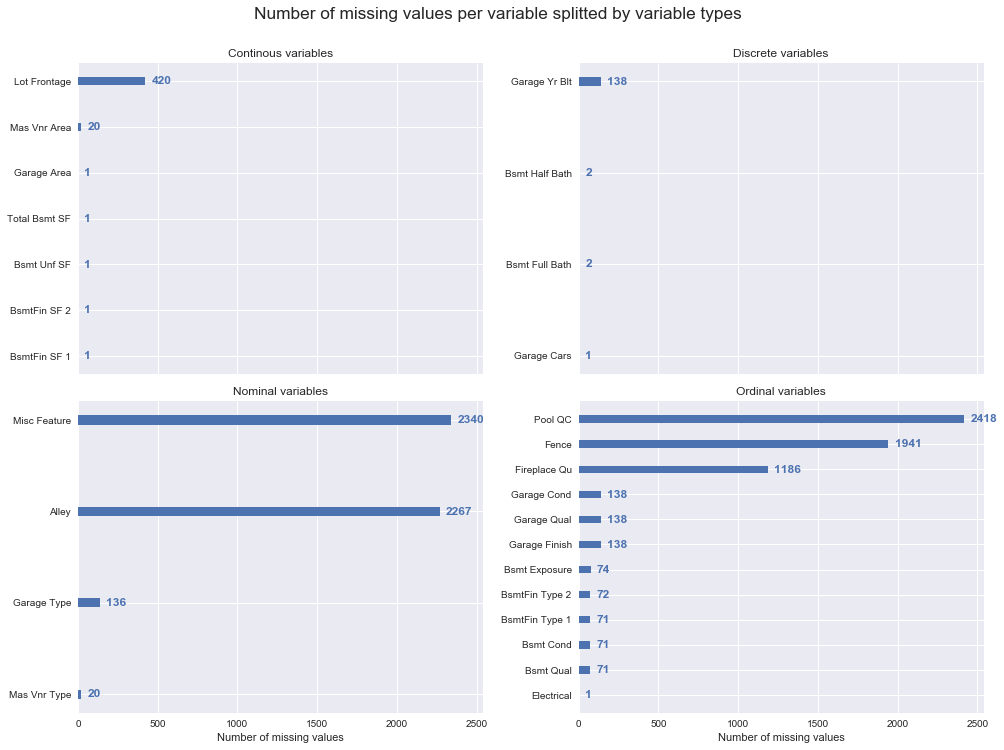

In [9]:
i = 0
titles = ['Continous variables', 'Discrete variables', 'Nominal variables', 'Ordinal variables']
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 10))
for vars in [vars_continuous, vars_discrete, vars_nominal, vars_ordinal]:
    row = i // 2
    col = i % 2
    i += 1
    
    # number of missing values
    vars_na = data.loc[:, vars].isnull().sum()
    vars_na = vars_na[vars_na > 0].sort_values(ascending=True)
    
    # horizontal bar plot
    y = np.arange(vars_na.shape[0])
    ax[row, col].barh(y, vars_na, tick_label=vars_na.index, align='center', height=vars_na.shape[0]/40)
    ax[row, col].set_title(titles[i - 1])
    
    # add number of missing values at the right of the bar
    for index, value in enumerate(vars_na):
        ax[row, col].text(x=value + 40, y=index, s=value, va='center', color=blue, fontweight='bold')
    if row == 1:
        ax[row, col].set_xlabel('Number of missing values')
        
plt.suptitle('Number of missing values per variable splitted by variable types', y=1.04, size='x-large')
plt.tight_layout()
plt.show()

Many of these missing values are not really missing values. In the documentation, we can see that some variables can have `NA` values that pandas interprets as missing values. We will simply replace `NA` codes by `None`.

Other explanation of missing values is when an house don't have a particular feature. For example, an house without a garage will have missing values in the Garage Area. These missing values can easely be  replaced by 0; it makes sense.

For other variables with missing values, we can generally replace them by a mean, median or mode value or simple logical rule. Exception is the `Lot Frontage` variable that needs some specific treatment.

### Continous & Discrete variables

Here are the rules used to handle missing values for continuous and discrete variables:
* When there are no garage or basement, we replace the missing values by `0`
* When no garage, the garage year built is filled with the house year built

In [10]:
# No basement and garage, missing values replaced by 0
vars = [
    'Total Bsmt SF', 
    'BsmtFin SF 1', 
    'BsmtFin SF 2', 
    'Bsmt Unf SF', 
    'Bsmt Half Bath', 
    'Bsmt Full Bath',
    'Garage Area', 
    'Garage Cars',
    'Mas Vnr Area'
]
for var in vars:
    data[var].fillna(0, inplace=True)
    
# No Garage, missing garage year built replaced by the house year built
# Strange observations:
# - observations with garage year built < year built
# - observations with garage year built > year remod/add
data.loc[data['Garage Yr Blt'].isnull(), 'Garage Yr Blt'] = data.loc[data['Garage Yr Blt'].isnull(), 'Year Built']

### Ordinal & Nominal variables

Here are the rules used to handle missing values for ordinal and nominal variables:
* `NA` original codes are replaces by `None` code
* `Electrical` missing value is replaced by its mode (SBrkr by far) 

In [11]:
# Replace missing values by None code
# Strange observations:
# - observation #1114 probably real missing values in garage variables
# - observation #602 probably real missing value in BsmtFin Type 2
vars = [
    'Misc Feature',
    'Alley',
    'Garage Type',
    'Mas Vnr Type',
    'Pool QC',
    'Fence',
    'Fireplace Qu',
    'Garage Cond',
    'Garage Qual',
    'Garage Finish',
    'Bsmt Exposure',
    'BsmtFin Type 2',
    'BsmtFin Type 1',
    'Bsmt Cond',
    'Bsmt Qual',    
]
for var in vars:
    data[var].fillna('None', inplace=True)

# Replace electrical value by its mode (SBrkr by far)
data['Electrical'].fillna(data['Electrical'].mode().values[0], inplace=True)  


### Lot Frontage

The lot frontage is by definiton a length with a value equal to a proportion of the lot perimeter. We should observe a positive correlation between the lot frontage and square root of the lot area variable. Instead of replacing lot frontage missing values by its mean or median value, we can use a linear regression to predict the missing values. Because there are some outliers, we will use an huber regressor.

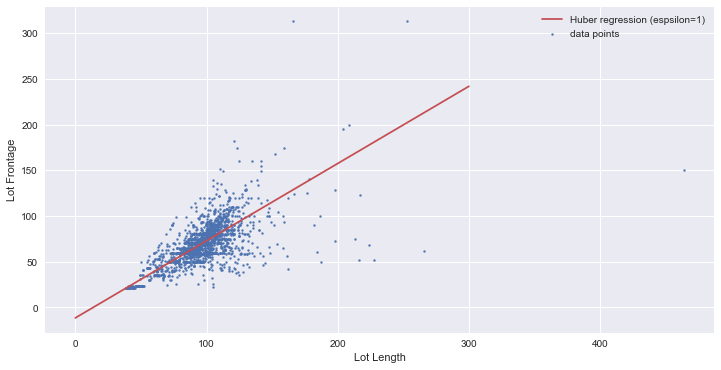

Slope:  0.8449832884279008
Intercept:  -11.463197445616172
Score: 0.3774969898391154


In [12]:
# Get the data
df = data.loc[data['Lot Frontage'].notnull(), ['Lot Area', 'Lot Frontage']]

# Huber regression: Lot Frontage VS sqrt(Lot Area)
x = np.sqrt(df['Lot Area']).values
y = df['Lot Frontage'].values
huber = HuberRegressor(epsilon=1)
huber.fit(x[:, np.newaxis], y)

# Plot the data points and the fitted model
x_values = np.linspace(0, 300, num=100)
y_pred = huber.predict(x_values[:, np.newaxis])

plt.figure(figsize=(12, 6))
plt.scatter(np.sqrt(data['Lot Area']), data['Lot Frontage'], s=4, label='data points')
plt.plot(x_values, y_pred, color=red, label='Huber regression (espsilon=1)')
plt.xlabel('Lot Length')
plt.ylabel('Lot Frontage')
plt.legend()
plt.show() 

print('Slope: ', huber.coef_[0])
print('Intercept: ', huber.intercept_)
print('Score:', huber.score(x[:, np.newaxis], y))

In [13]:
# Lot Frontage missing values replaced by the values predicted by our simple huber regression model
x = np.sqrt(data.loc[data['Lot Frontage'].isnull(), 'Lot Area']).values
lot_frontage_pred = huber.predict(x[:, np.newaxis])

data.loc[data['Lot Frontage'].isnull(), 'Lot Frontage'] = lot_frontage_pred

### Drop strange observations

During the handling of missing values, we identified some strange observations with probably real missing values. We decide to drop them because there are few.

* observation #602 probably real missing value in BsmtFin Type 2
* observation #1114 probably real missing values in garage variables

The `Garage Yr Built` variable has some strange values:
* observations with garage year built < year built
* observations with garage year built > year remod/add

We keep the variable for the moment, just remember it looks not very clean... 

In [14]:
# Drop observations with probably real missing values
data.drop(index=[602, 1114], inplace=True)

# 3. Outliers

## 3.1 The Target Variable

As stated in the tasks, we can see that the sale price distribution is strongly right skewed. We can solve this issue by taking the logarithmic transformation of the sale prices and use them as our new target variable to build models.

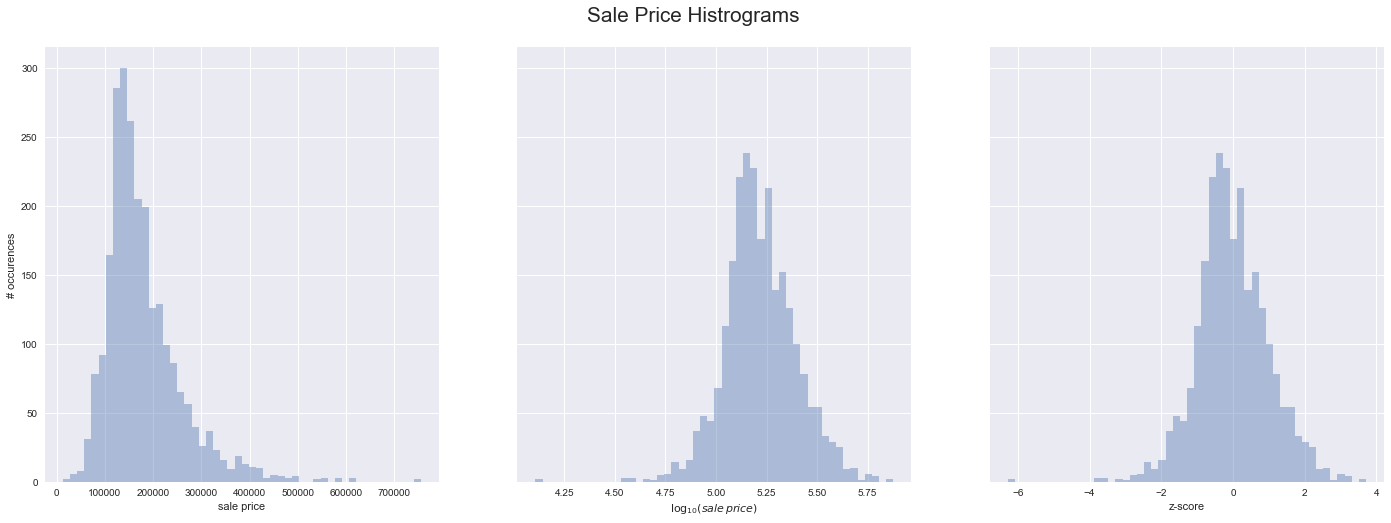

In [15]:
# Show Sale Price Histograms
eda_histograms('SalePrice', 
               data, 
               xlabels=['sale price', '$\log_{10}(sale\,price)$', 'z-score'], 
               suptitle='Sale Price Histrograms',
               transform=np.log10)

We can notice some outliers. We decide to drop observations with sale price > 600'000 (log10 ~ 5.78) and sale price < 40'002 (log10 ~ 4.6).  
The 40'002 threshold is due to an observation with a sale price of 40'001 that joke the more elegant 40'000 threshold :)

In [16]:
# Drop observations with sale price > 600'000 (log10(600000) = 5.778)
eda_remove_outliers_threshold('SalePrice', data, 600000, greaterThan=True)

Number of SalePrice outliers removed: 5


In [17]:
# Drop observations with sale price < 40'002 (log10(40000) ~ 4.6)
eda_remove_outliers_threshold('SalePrice', data, 40002, greaterThan=False)

Number of SalePrice outliers removed: 8


In [18]:
# Create the logarithmic transformed sale price target variable
data['SalePriceLog'] = np.log10(data['SalePrice'])
vars_continuous.append('SalePriceLog')

## 3.2 The Predictors

In this section, we draw bivariate scatter plots between the sale price and some continuous variables with the goal to identify and drop outliers. For the sake of brevity, only the more interesting plots are presented but each outliers dropped have been previously observed graphically, thanks to the easy to use `eda_bivariate_scatter` function.

Note that in this section, we don't treat discrete, ordinal and nominal variables. Because these kinds of variable can be used in different ways to build models, we will transformed these variables according to our needs during the data preparation phase for each model and decide how to treat potential outliers (drop them, capping threshold, merge categories, change value, etc.). Exception is the year build variable that need some outliers removal.

### Ground Living Area

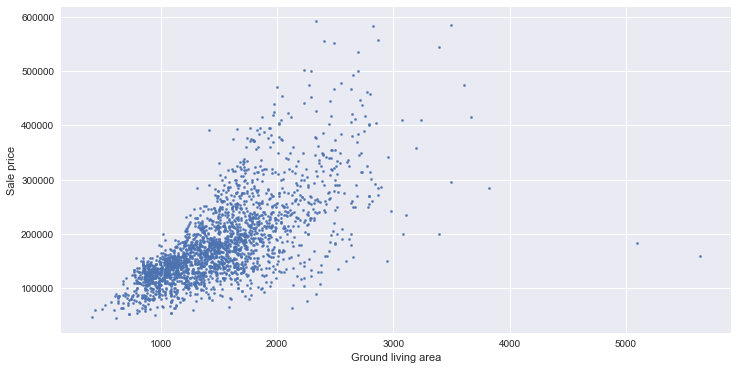

In [19]:
eda_bivariate_scatter('Gr Liv Area', 'SalePrice', data, xlabel='Ground living area', ylabel='Sale price', title='')

In [20]:
# Drop observations with ground living area > 4000
eda_remove_outliers_threshold('Gr Liv Area', data, 4000, greaterThan=True)

Number of Gr Liv Area outliers removed: 2


### Lot Area

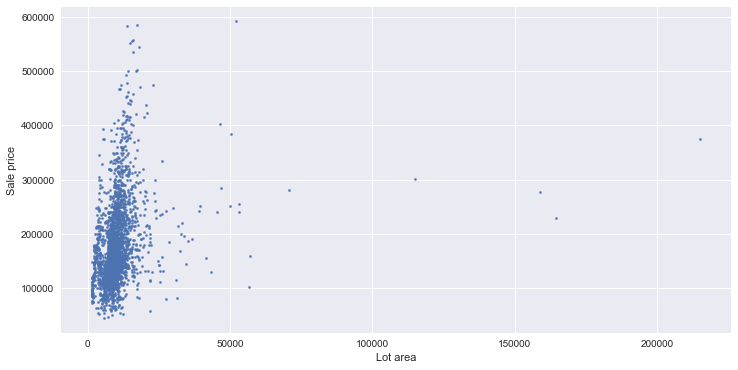

In [21]:
eda_bivariate_scatter('Lot Area', 'SalePrice', data, xlabel='Lot area', ylabel='Sale price', title='')

In [22]:
# Drop observations with lot area > 60000
eda_remove_outliers_threshold('Lot Area', data, 60000, greaterThan=True)

Number of Lot Area outliers removed: 5


### Year Built

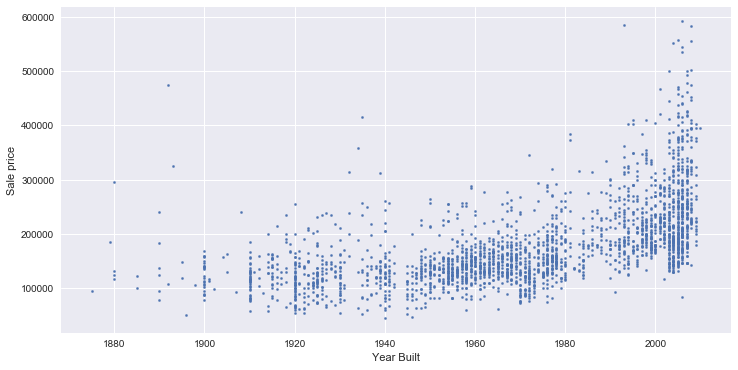

In [23]:
eda_bivariate_scatter('Year Built', 'SalePrice', data, xlabel='Year Built', ylabel='Sale price', title='')

In [24]:
# Drop observations with year built < 1940 and sale price > 290 000
filter = (data['Year Built'] < 1940) & (data['SalePrice'] > 290000)
eda_remove_outliers(data, filter)

Number of outliers removed: 7


In [25]:
# Drop observations with year built < 2000 and sale price > 500000
filter = (data['Year Built'] < 2000) & (data['SalePrice'] > 500000)
eda_remove_outliers(data, filter)

Number of outliers removed: 1


### Other variables

In [26]:
# Drop observations with total basement area > 3000
eda_remove_outliers_threshold('Total Bsmt SF', data, 3000, greaterThan=True)

# Drop observations with garage area > 1200
eda_remove_outliers_threshold('Garage Area', data, 1200, greaterThan=True)

# Drop observations with masonry veneer area > 1000
eda_remove_outliers_threshold('Mas Vnr Area', data, 1000, greaterThan=True)

# Drop observations with lot frontage > 250
eda_remove_outliers_threshold('Lot Frontage', data, 250, greaterThan=True)

# Drop observations with wood deck area > 800
eda_remove_outliers_threshold('Wood Deck SF', data, 800, greaterThan=True)

# Drop observations with open porch area > 500
eda_remove_outliers_threshold('Open Porch SF', data, 500, greaterThan=True)

# Drop observations with enclosed porch area > 500
eda_remove_outliers_threshold('Enclosed Porch', data, 500, greaterThan=True)

Number of Total Bsmt SF outliers removed: 1
Number of Garage Area outliers removed: 7
Number of Mas Vnr Area outliers removed: 9
Number of Lot Frontage outliers removed: 1
Number of Wood Deck SF outliers removed: 2
Number of Open Porch SF outliers removed: 3
Number of Enclosed Porch outliers removed: 2


# 4. Exploratory Data Analysis

With missing values removed and outliers dropped, it's time for some exploratory data analysis. We will not explore every variable but follow our intuition about which one could be good predictors :

1) Size matters, so we can expect to observe a strong correlation for some area variables:
* Living Area 
* Basement Area
* Lot area
* Garage Area (American love cars and drive long distance)

2) Time and Period
* Year Built (recent or old house ?)
* Year Remod/Add (recently refreshed ?)
* Year/Month Sold (market condition, behaviour)

3) Location and House Style
* Neighborhood
* Condition
* Zoning
* Building Type
* House Style

4) Sale Process
* Sale Condition
* Sale Type
* Year/Month Sold

5) Quality
* Overall Quality
* Exterior Quality
* Kitchen Quality
* etc.

6) Equipment & Convenience
* Air Central
* Heating
* Electrical
* etc

It is already a lot of plots and analysis...

## 4.1 Areas

### Ground Living Area

The ground living area variable is also right skewed. Taking its square root transformation to build our models later could be a good idea.

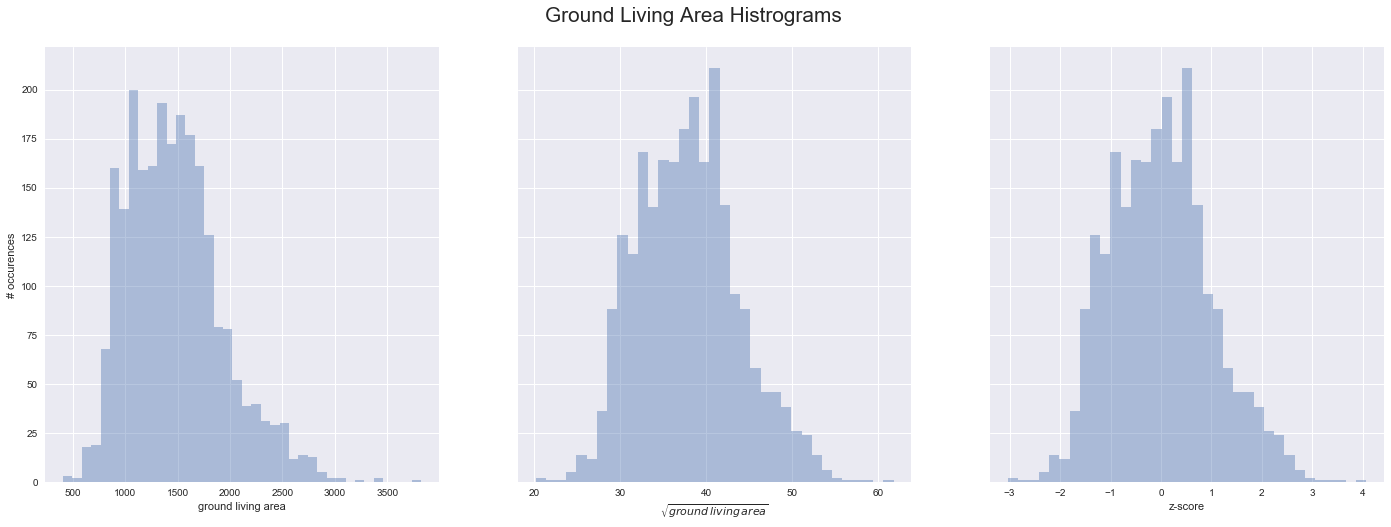

In [27]:
eda_histograms('Gr Liv Area', 
               data, 
               xlabels=['ground living area', '$\sqrt{ground\,living\,area}$', 'z-score'], 
               suptitle='Ground Living Area Histrograms',
               transform=np.sqrt)

A bivariate analysis with the sale price shows a strong "linear" correlation. We can also notice that at the same area, houses without a second floor are more expensive than houses with a second floor. Probably because they need a bigger lot, more roof, foundation area, etc. Accessibility could also be an explanation.

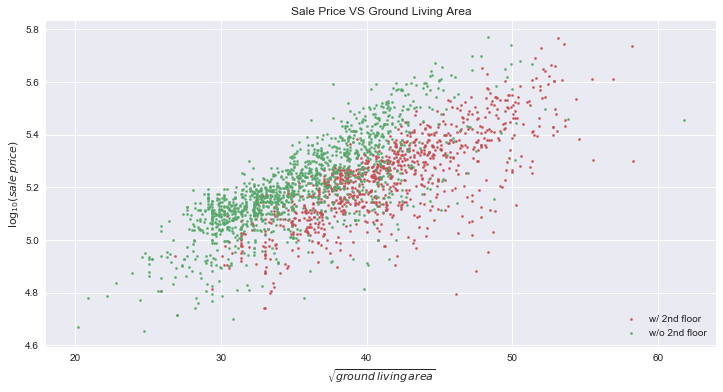

In [28]:
# Multivariate analysis of the sale price vs the ground living area
eda_multivariate_scatter(
    'Gr Liv Area', 
    'SalePriceLog', 
    data,
    split_var=(data['2nd Flr SF'] > 0).map({True: 'w/ 2nd floor', False: 'w/o 2nd floor'}),
    split_values=['w/ 2nd floor', 'w/o 2nd floor'],
    xlabel='$\sqrt{ground\,living\,area}$', 
    ylabel='$\log_{10}(sale\,price)$', 
    title='Sale Price VS Ground Living Area',
    transformx=np.sqrt,
    colors=[red, green]
)

Note that the ground living area variable is a linear combination of three other variables:
```
Gr Liv Area = 1st Flr SF + 2nd Flr SF + Low Qual Fin SF
```

### Basement Area

The sale price is also strongly positively correlated with the total basement area. Here, of course, we see that for the same basement area, houses with a second floor are more expensive (more living area). 

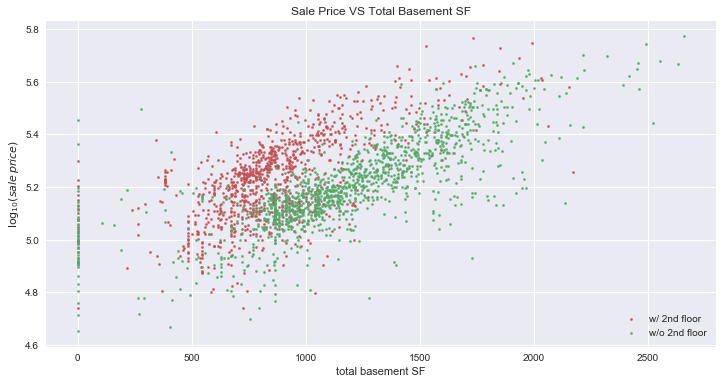

In [29]:
# Multivariate analysis of the sale price vs the total basement areaa
eda_multivariate_scatter(
    'Total Bsmt SF', 
    'SalePriceLog', 
    data,
    split_var=(data['2nd Flr SF'] > 0).map({True: 'w/ 2nd floor', False: 'w/o 2nd floor'}),
    split_values=['w/ 2nd floor', 'w/o 2nd floor'],
    xlabel='total basement SF', 
    ylabel='$\log_{10}(sale\,price)$', 
    title='Sale Price VS Total Basement SF',
    transformx=None,
    colors=[red, green]
)

Note that the ground living area variable is a linear combination of three other variables:
```
Total Bsmt SF = BsmtFin SF 1 + BsmtFin SF 2 + Bsmt Unf SF
```

### House Area

The ground living area doesn't include the basement area. The author suggest to engineer an `House Area` variable as the sum of the `Gr Liv Area` and `Total Bsmt SF` variables.

In [30]:
# Engineer a new variable for the house area (ground living area + basement area)
data['House Area'] = data['Gr Liv Area'] + data['Total Bsmt SF']
vars_continuous.append('House Area')

Its distribution is also right skewed but after a square root transformation, the distribution looks more like a normal distribution.

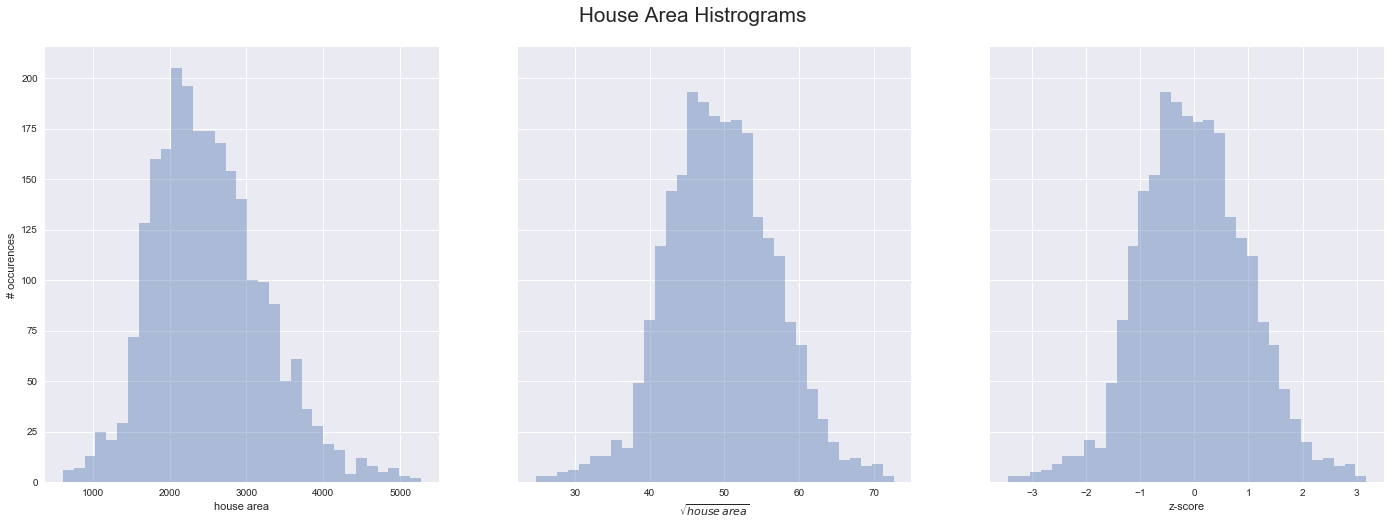

In [31]:
eda_histograms('House Area', 
               data, 
               xlabels=['house area', '$\sqrt{house\,area}$', 'z-score'], 
               suptitle='House Area Histrograms',
               transform=np.sqrt)

A bivariate analysis with the sale price shows an even better linear correlation.  
There isn't anymore interest to split the houses with and without second floor.

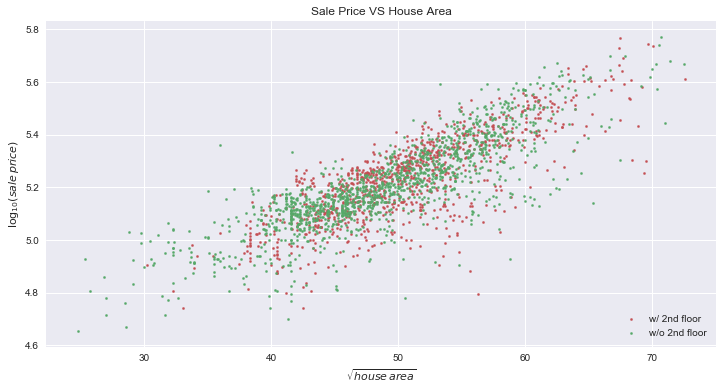

In [32]:
# Multivariate analysis of the sale price vs the ground living area
eda_multivariate_scatter(
    'House Area', 
    'SalePriceLog', 
    data,
    split_var=(data['2nd Flr SF'] > 0).map({True: 'w/ 2nd floor', False: 'w/o 2nd floor'}),
    split_values=['w/ 2nd floor', 'w/o 2nd floor'],
    xlabel='$\sqrt{house\,area}$', 
    ylabel='$\log_{10}(sale\,price)$', 
    title='Sale Price VS House Area',
    transformx=np.sqrt,
    colors=[red, green]
)

It is clear that the `House Area` variable is a nice engineered variable for simple model. It corresponds in fact to the sum of 6 continuous variables:
```
House Area = Gr Liv Area + Total Bsmt SF
House Area = 1st Flr SF + 2nd Flr SF + Low Qual Fin SF + BsmtFin SF 1 + BsmtFin SF 2 + Bsmt Unf SF
```

Just to have a rough idea of the variance explained just by the house area, square root transformed, let's fit a linear regression and compute the R2 score.

In [33]:
# Rough idea about the variance explained just by the house area, squared root transformed
x = np.sqrt(data['House Area']).values
X = x[:, np.newaxis]
y = data['SalePriceLog'].values

lr = LinearRegression()
lr.fit(X, y)
print('R2 Score: ', lr.score(X, y))

R2 Score:  0.6628944002671513


It appears that more than 60% of the variance could be explained by the house area variable alone.

### Lot Area

The lot area is probably also a strong predictor. We can see that its distribution can also be improved by a logarithmic transformation. 

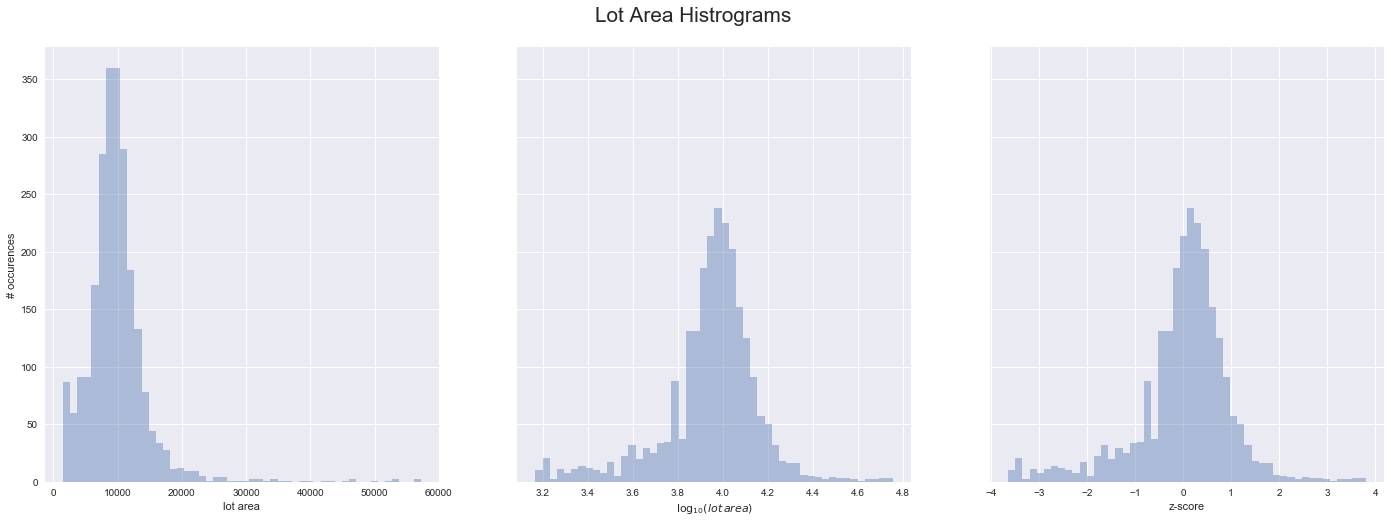

In [34]:
eda_histograms('Lot Area', 
               data, 
               xlabels=['lot area', '$\log_{10}(lot\,area)$', 'z-score'], 
               suptitle='Lot Area Histrograms',
               transform=np.log10)

The bivariate analysis below shows that there is a positive correlation between the lot area and the sale price and we could fit a linear regression. Moreover, this plot looks like the aggregation of multiples clusters.

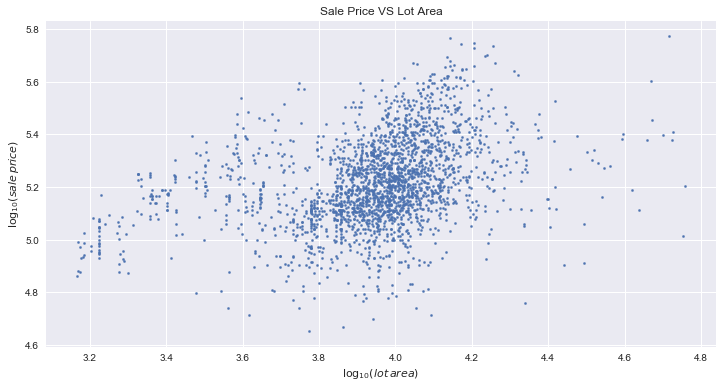

In [35]:
eda_bivariate_scatter('Lot Area', 
                      'SalePriceLog', 
                      data, 
                      transformx=np.log10,
                      xlabel='$\log_{10}(lot\,area)$',
                      ylabel='$\log_{10}(sale\,price)$',
                      title='Sale Price VS Lot Area'
                     )

Lot Area prices are surely related to the location, let's redraw the same plot but for some of the locations existing in the neighborhood variable: 

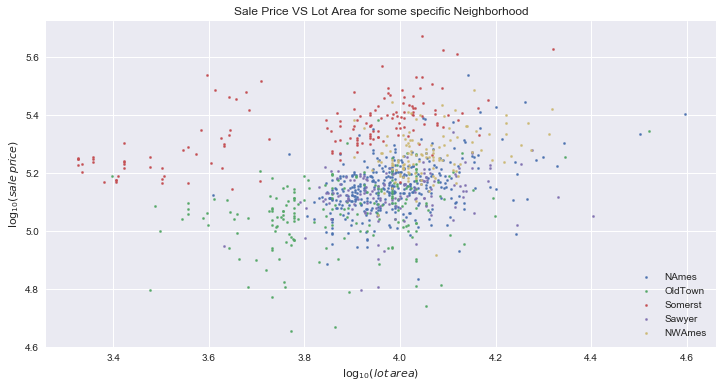

In [36]:
eda_multivariate_scatter(
    'Lot Area', 
    'SalePriceLog',
    data,
    transformx=np.log10,
    split_var='Neighborhood',
    split_values=eda_top_occurences_list('Neighborhood', data, n=5, step=2),
    xlabel='$\log_{10}(lot\,area)$', 
    ylabel='$\log_{10}(sale\,price)$', 
    title='Sale Price VS Lot Area for some specific Neighborhood'
)

We have only plotted the 1st, 3rd, 5th, 7th, 9th most popular locations but we can clearly see some clusters and fit linear regressions among them. The neighboorhod nominal variable will be an important predictor for sure.

### Garage Area

The bivariate analysis shows a strong positive correlation between the sale price and the garage area.

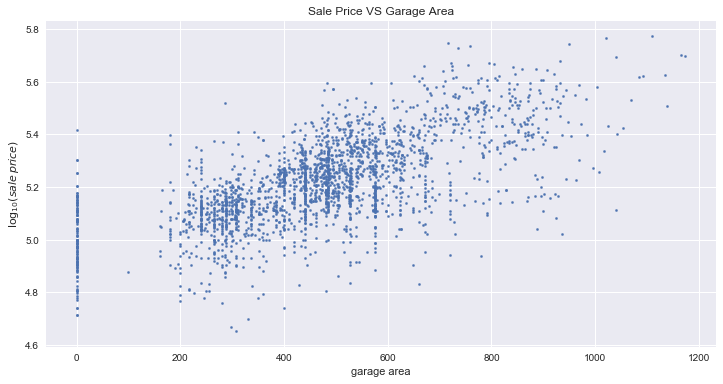

In [37]:
eda_bivariate_scatter('Garage Area', 
                      'SalePriceLog', 
                      data, 
                      transformx=None,
                      xlabel='garage area',
                      ylabel='$\log_{10}(sale\,price)$',
                      title='Sale Price VS Garage Area'
                     )

## 4.2 Period & Time 

Time and period are always important dimensions and most of the time the worst models enemies but it is another story :) 
Markets fluctuate and sometimes even crash, so we could have in our data these kinds of pattern and maybe discover that an important part of the sale price variance can be explained by when the sale occured. With time, trends, needs, quality of materials evolve and degrade also and it would make sense that new houses cost more than old ones.

Let's check that !

### Year Built ( Age )

From the `year built` and `year sold` variables, we can compute the age of the house when the sale occured. 

In [38]:
# Age of the house when sold
data['Age'] = data['Yr Sold'] - data['Year Built']
vars_discrete.append('Age')

We are interested by the median sale price in function of the age of the house during the sale. We expect to observe that recent houses tends to be more expensive than the older ones. It is also interesting to know the number of houses (sample size) we have for each "age".

The plot bellow presents these two informations on the same plot. The sale price is express by the left y scale axis (red curve) and the number of houses by the right y scale axis (blue curve).

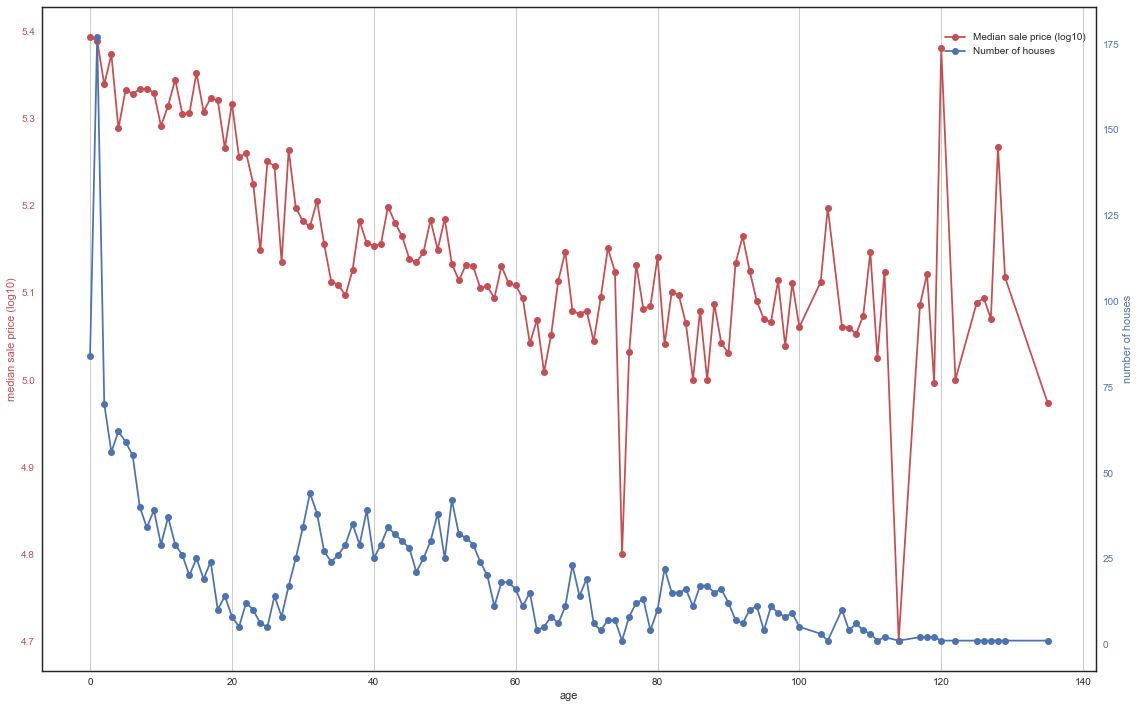

In [39]:
sale_price_medians = data['SalePriceLog'].groupby(data['Age']).agg(np.median)
houses = data['SalePriceLog'].groupby(data['Age']).count()

sns.set_style('white')
fig, ax1 = plt.subplots(figsize=(16, 10))

color = red
ax1.plot(sale_price_medians, color=color, marker='o', label='Median sale price (log10)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('age')
ax1.xaxis.grid(True)
ax1.set_ylabel('median sale price (log10)', color=color) 

ax2 = ax1.twinx()  

color = blue
ax2.plot(houses, color=color, marker='o', label='Number of houses')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('number of houses', color=color)

fig.tight_layout() 
fig.legend(bbox_to_anchor=(0.95, 0.95))
plt.show()

It confirms our intuition about the negative correlation. We could guess a quadratic relationship or maybe an indicator variable for houses older than 60 years.

### Year Remod/Add (Age Remod/Add)

Let's do exactly the same with the `Year Remod/Add` variable by engineering a variable that represent the number of years since the last remod/add when the sale occurred.

In [40]:
# Number of years since the last remod/add when sold
data['Age Remod/Add'] = data['Yr Sold'] - data['Year Remod/Add']
vars_discrete.append('Age Remod/Add')

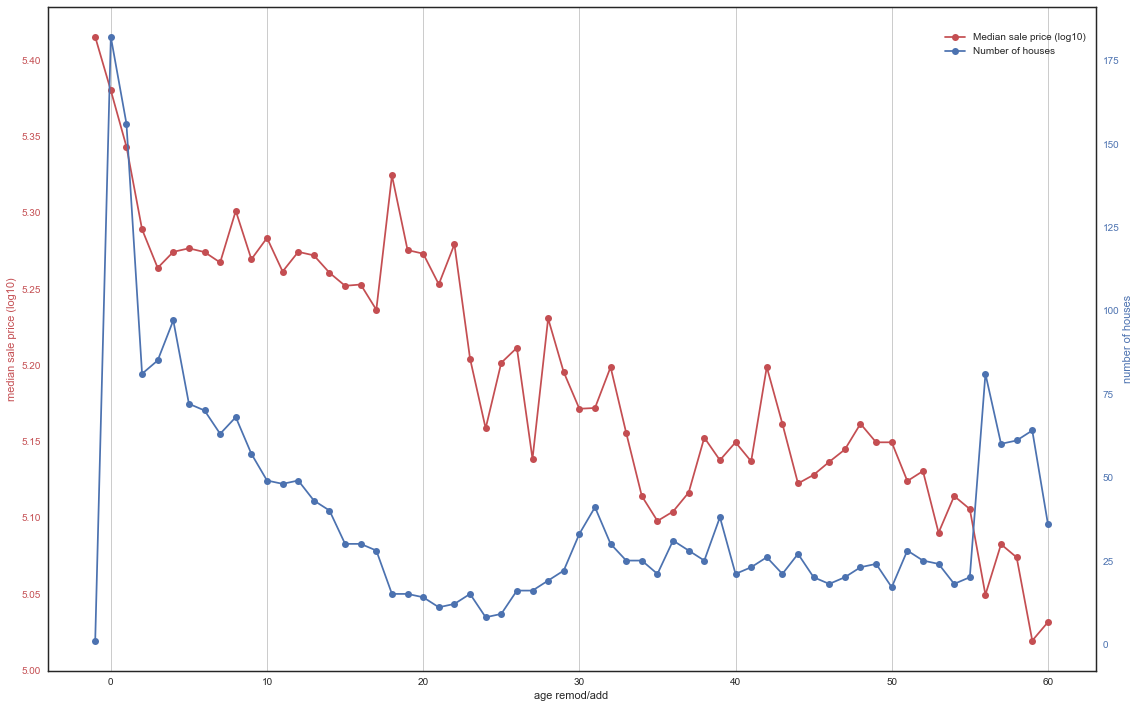

In [41]:
sale_price_medians = data['SalePriceLog'].groupby(data['Age Remod/Add']).agg(np.median)
houses = data['SalePriceLog'].groupby(data['Age Remod/Add']).count()

sns.set_style('white')
fig, ax1 = plt.subplots(figsize=(16, 10))

color = red
ax1.plot(sale_price_medians, color=color, marker='o', label='Median sale price (log10)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('age remod/add')
ax1.xaxis.grid(True)
ax1.set_ylabel('median sale price (log10)', color=color) 

ax2 = ax1.twinx()  

color = blue
ax2.plot(houses, color=color, marker='o', label='Number of houses')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('number of houses', color=color)

fig.tight_layout() 
fig.legend(bbox_to_anchor=(0.95, 0.95))
plt.show()

Without surprise, we see that houses refreshed recently are clearly more expensive (strong negative correlation). Note that the Year remod/add variable is equal to the year built variable when no refreshed has been done (54% of the houses has never been refreshed, new houses included).

### Year & Month Sold

Let's do the same as above but to see if there is a correlation between the sale price and the period when the sale occured. We know that there was a real estate bubble and a crash afterwards, we could observe interesting things.

Note that the documentation says that our data cover that sales during from 2006 to 2010.

In [42]:
# Engineer a sold date variable with the year and month sold variables
df_dates = pd.DataFrame({'year': data['Yr Sold'], 'month': data['Mo Sold'], 'day': np.ones(data.shape[0])})
data['Sold Date'] = pd.to_datetime(df_dates)

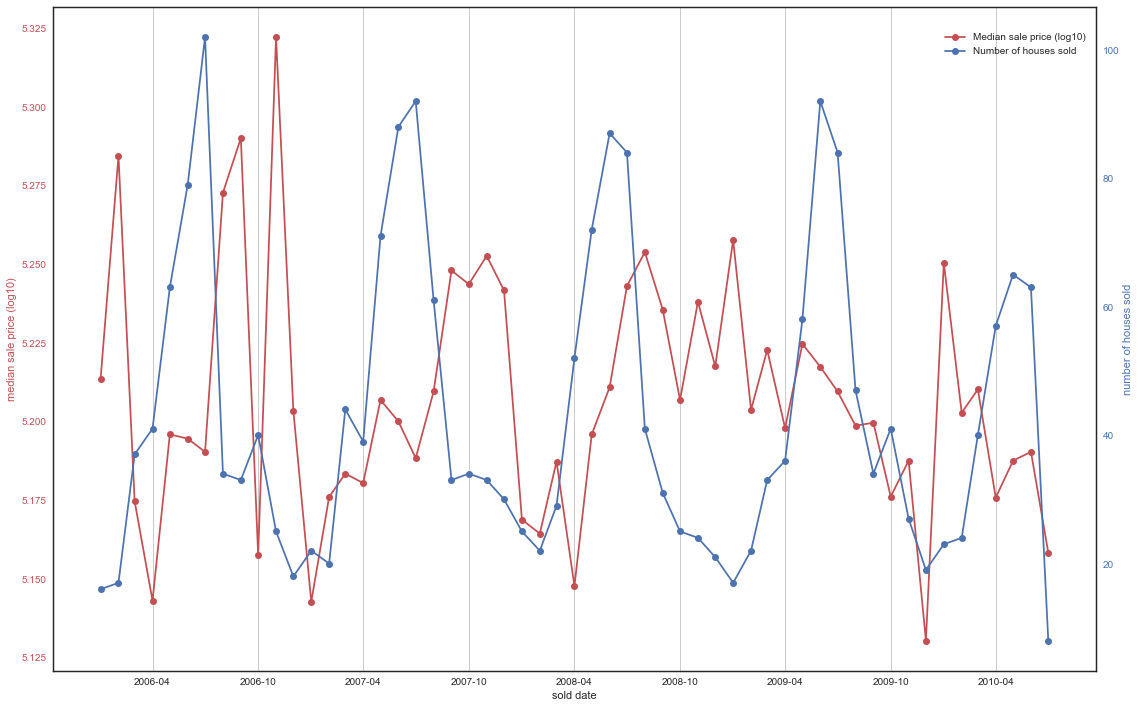

In [43]:
# median sale price group by sold date (year-month)
sale_price_medians = data['SalePriceLog'].groupby(data['Sold Date']).agg(np.median)

# number of houses sold group by sold date (year-month)
houses = data['SalePriceLog'].groupby(data['Sold Date']).count()

sns.set_style('white')
fig, ax1 = plt.subplots(figsize=(16, 10))

# plot the median sale price curve
color = red
ax1.plot(sale_price_medians, color=color, marker='o', label='Median sale price (log10)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('sold date')
ax1.xaxis.grid(True)
ax1.set_ylabel('median sale price (log10)', color=color) 

ax2 = ax1.twinx()  

# plot the number of houses sold
color = blue
ax2.plot(houses, color=color, marker='o', label='Number of houses sold')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('number of houses sold', color=color)

fig.tight_layout() 
fig.legend(bbox_to_anchor=(0.95, 0.95))
plt.show()

First, it appears that the sale price tends to decrease over the years. The blue curve (number of houses sold) is really interesting with its sinusoidal shape. Note that the sale price seems also to follow this higher frequency signal with some phase. When the number of houses sold is lower, the sale price tends to be higher and vice-versa. Looks like an offer-demand pattern.

Unfortunalty sinusoidal signal and linear regression are not good friends but by treating the month sold variable as a nominal variable with one indicator variable for each month, we could recover this signal in our model.

## 4.3 Location & House Style

### Neighborhood

We already saw that Neigborhood tends to create clusters and should be a good "stabilization" feature.  
In the bar blot below, we can see that some locations have few sales. We will need to handle these locations when building our models by grouping them in an `other` location for example...

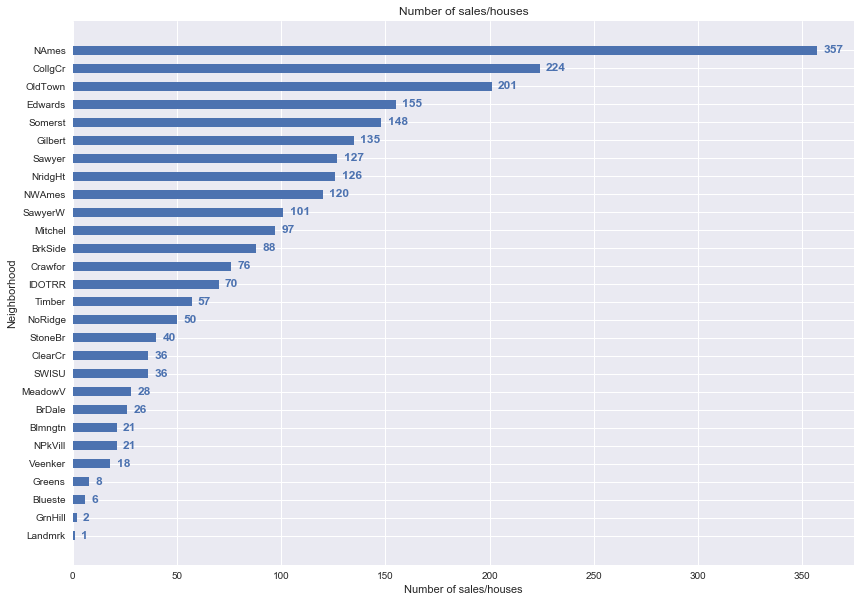

In [44]:
# barplot
sns.set_style('darkgrid')
eda_barh('Neighborhood',
         data,
         figsize=(14,10),
         xlabel='Number of sales/houses',
         ylabel='Neighborhood',
         title='Number of sales/houses',
         text_offset=3
        )

It is clear from this boxplot that some locations are more expensive than others:

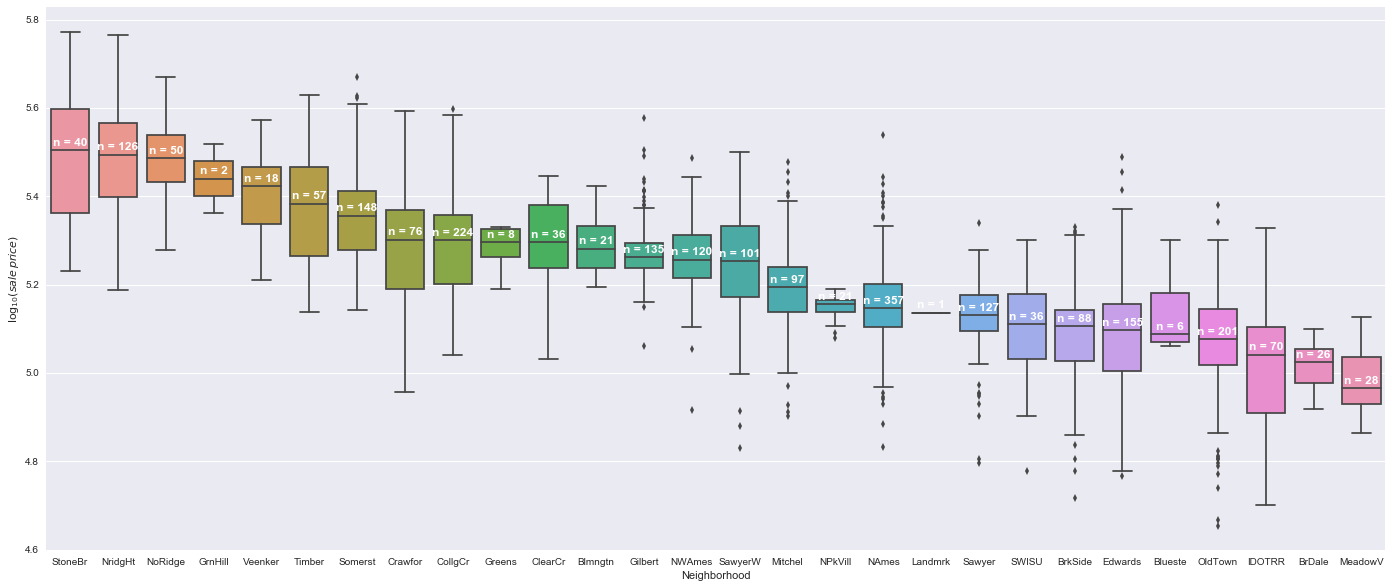

In [45]:
eda_saleprice_boxplot('Neighborhood', figsize=(24, 10), text_offset=0.01)

As we did for the lot area variable, let's plot a multivariate analysis of the sale price vs the house area, splitted by the most common locations:

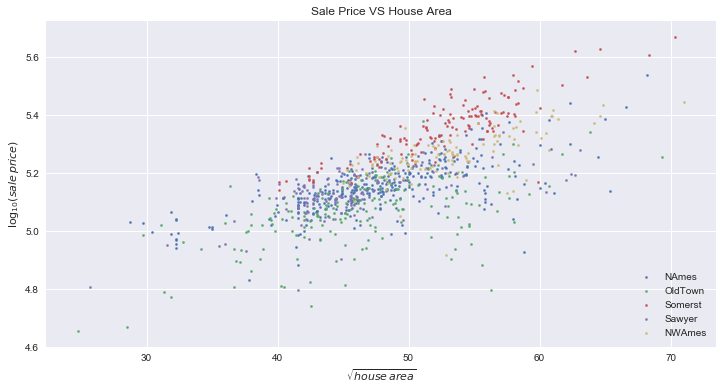

In [46]:
# sale price vs house area splitted by some neighborhood
eda_multivariate_scatter(
    'House Area', 
    'SalePriceLog',
    data,
    transformx=np.sqrt,
    split_var='Neighborhood',
    split_values=eda_top_occurences_list('Neighborhood', data, n=5, step=2),
    xlabel='$\sqrt{house\,area}$', 
    ylabel='$\log_{10}(sale\,price)$', 
    title='Sale Price VS House Area',
)

The neighborhood variable will be a good predictor!

### MS Zoning

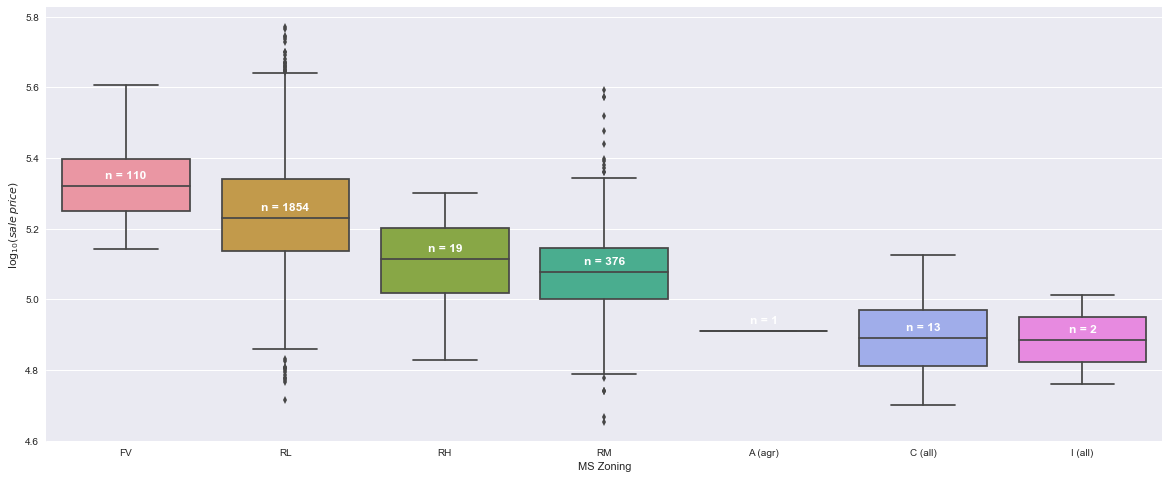

In [47]:
eda_saleprice_boxplot('MS Zoning', text_offset=0.02)

MS Zoning could be interesting even if most of the houses are in a RL Zone.  
We could probably remap this variable to reduce the number of dimensions with the following mapping:
* FV => FV
* RL => RL
* RH => R
* RM => R
* A (agr) => Other
* I (all) => Other
* C (all) => Other

### Condition 1

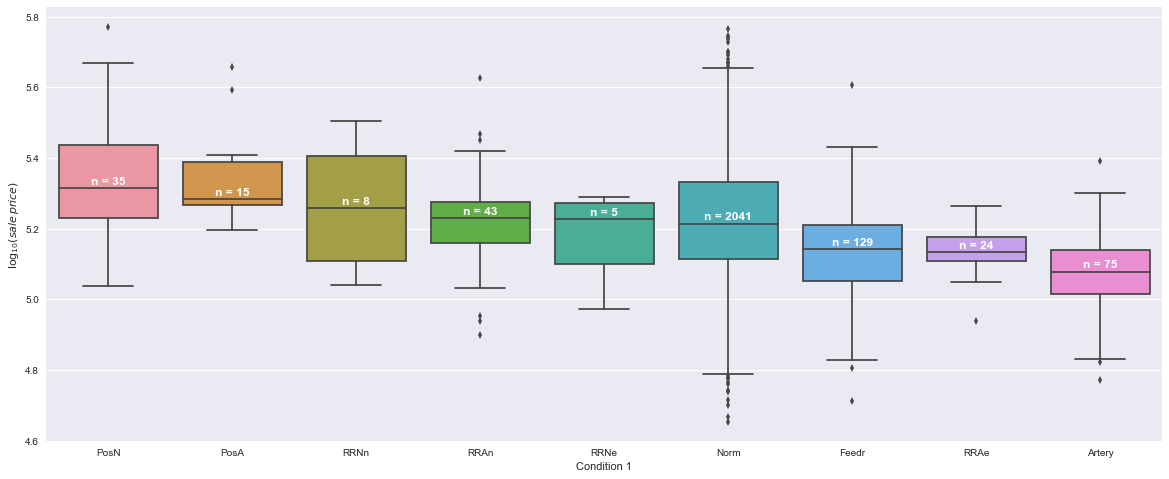

In [48]:
eda_saleprice_boxplot('Condition 1', text_offset=0.01)

Most of the houses have a normal condition, so it will not be in the top 5 best predictors but it could probably help if we remap the variable as follow:

* PosA => Pos
* PosN => Pos
* RRNn => RR
* RRAn => RR
* RRNe => RR
* RRAe => RR
* Feedr => Feedr
* Artery => Artery

### Building Type / House Style

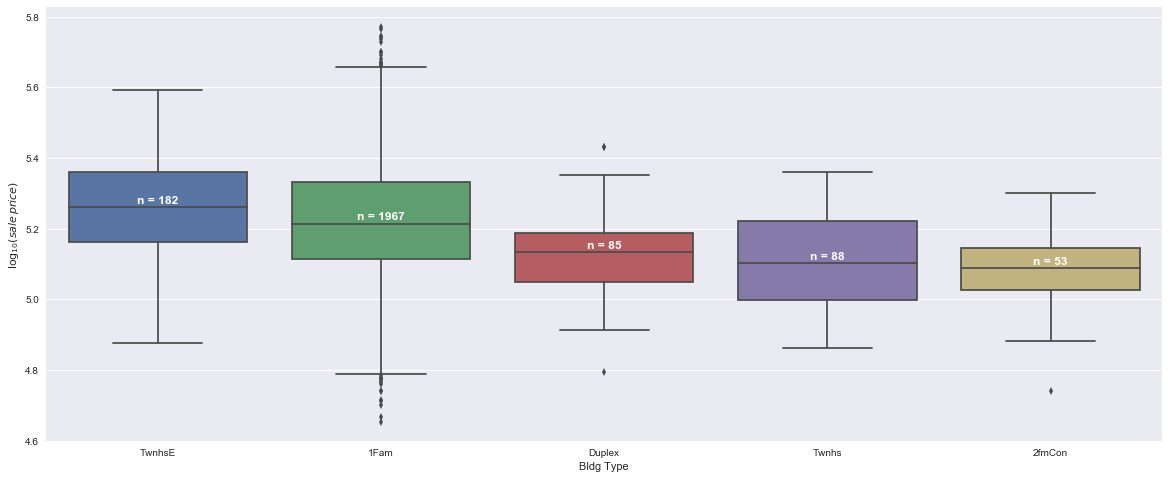

In [49]:
eda_saleprice_boxplot('Bldg Type', text_offset=0.01)

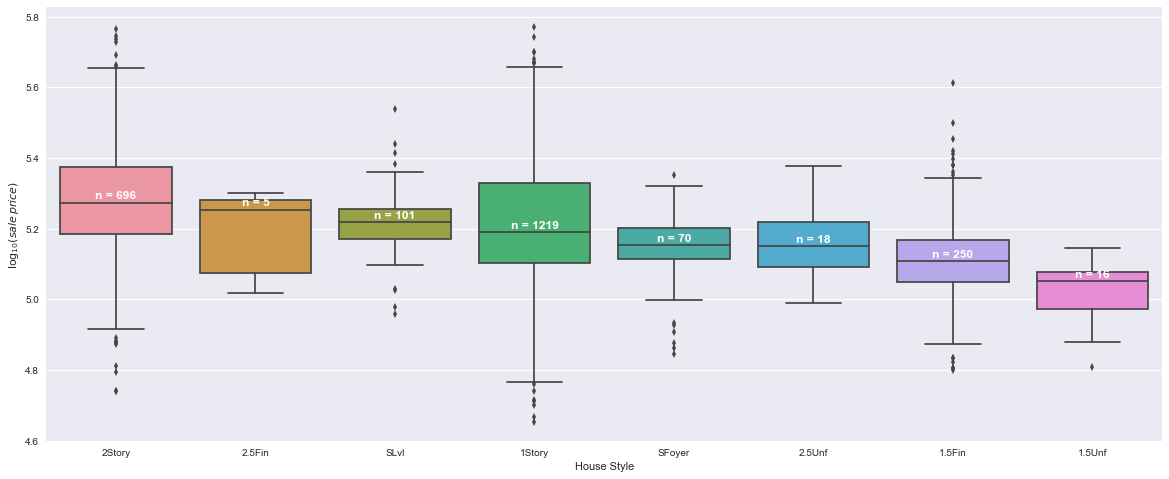

In [50]:
eda_saleprice_boxplot('House Style', text_offset=0.01)

These two variables present a common category but with sufficient spread in other ones that could help to explain the price of less common houses (building type looks more promising in this regards)

## 4.4 Sale Process


### Sale Condition

Partial sales are clearly more expensive. In fact, it corresponds to new house sales (age <= 1) for most of them, exception for 4 houses 2 years old and few some older ones. We can also expect to have significantly lower prices for abnormal sales and it would be logical to observe the same behaviour for the family sales (but not visible here).

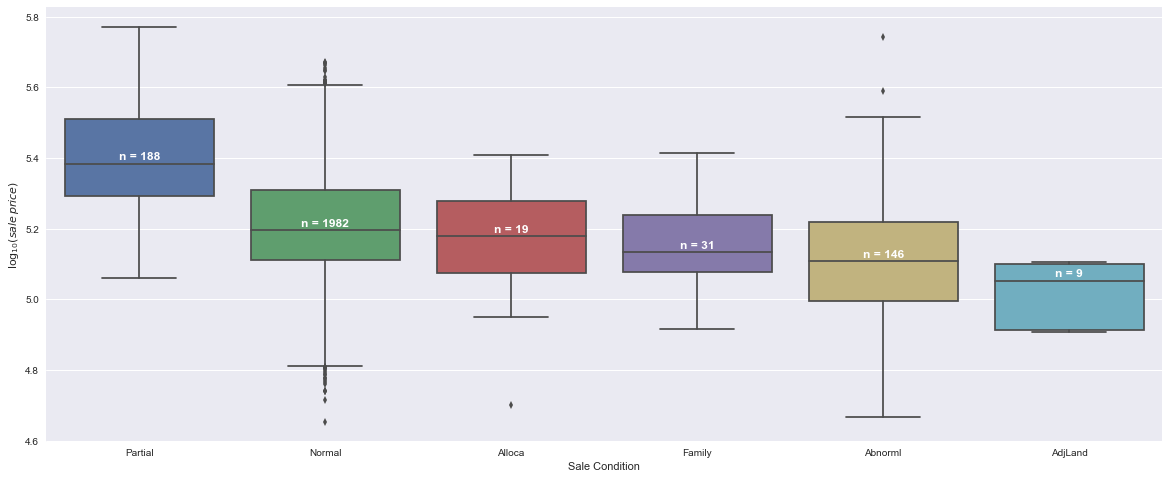

In [51]:
eda_saleprice_boxplot('Sale Condition', text_offset=0.01)

### Sale Type

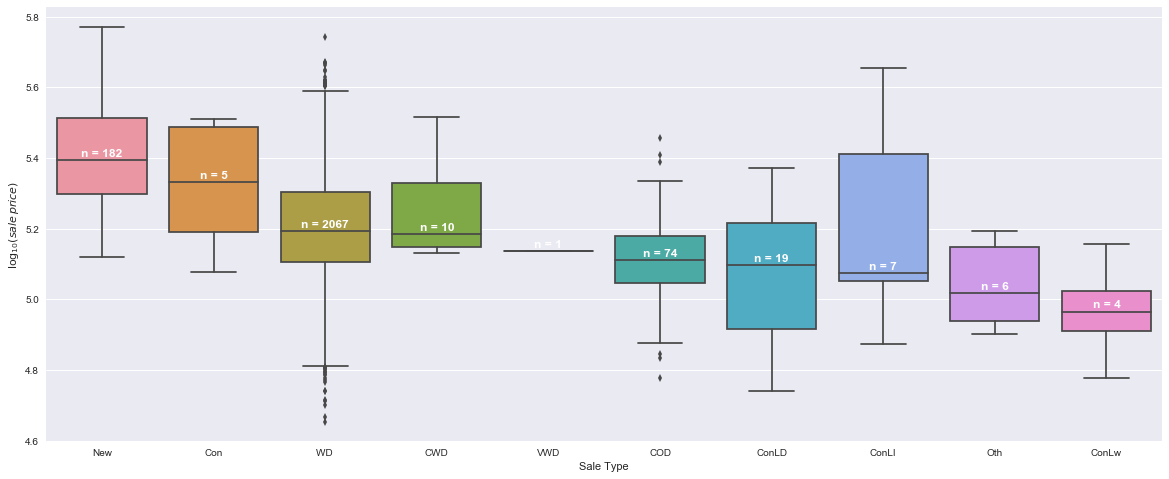

In [52]:
eda_saleprice_boxplot('Sale Type', text_offset=0.01)

Hard to conclude something now about this variable but many categories have not sufficient sample sizes. Note the `New` category that is nearly the same as the `Partial` sale condition and redundant. Here, we could improve this variable by the following mapping:

* WD: Warranty, CWD: Warranty, VWD: Warranty,
* Con: Contract, ConLw: Contract, ConLI: Contract, ConLD: Contract,
* New: New, COD: COD, Oth: Oth

## 4.5 Quality

### Overall Quality

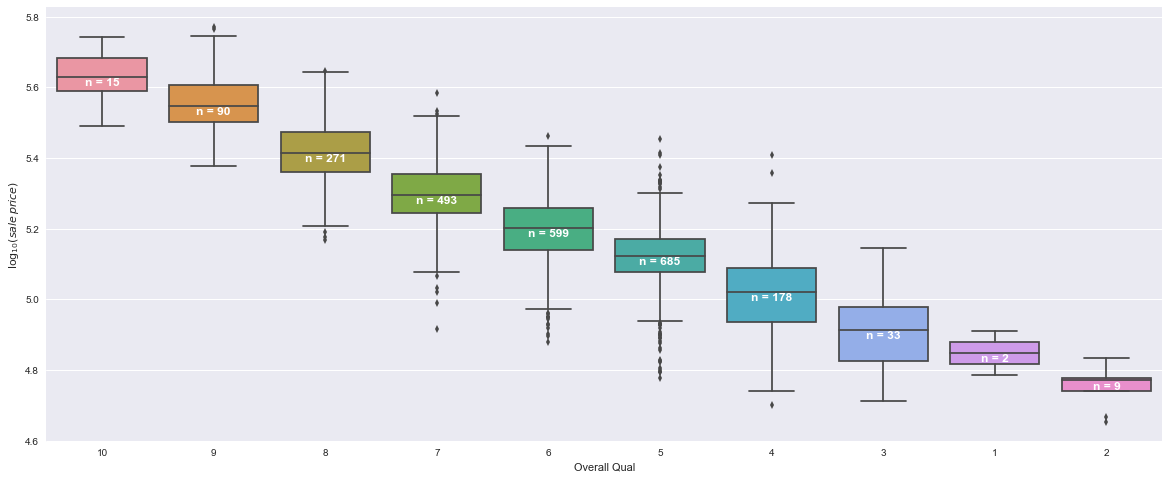

In [53]:
eda_saleprice_boxplot('Overall Qual', text_offset=-0.025)

We have a top best predictor here for sure! Sample sizes are well spreaded and the boxes are well aligned and the differences significant. Quality can be a subjective measure and it is surprising to observe a 10 rating variable with so perfection. The documentation says only : Rates the overall material and finish of the house... would be interesting to know how this variable is assesed (formula ?, criteria with scores, ...) 

If we plan to use this variable as a nominal variable, it could be usefull to merge the 1, 2, 3 & 4 scores together and also the 9 & 10 scores to have good sample sizes. We have probably here with the House Area our second best predictor to build our first model by using only two variables !

### Exterior Quality

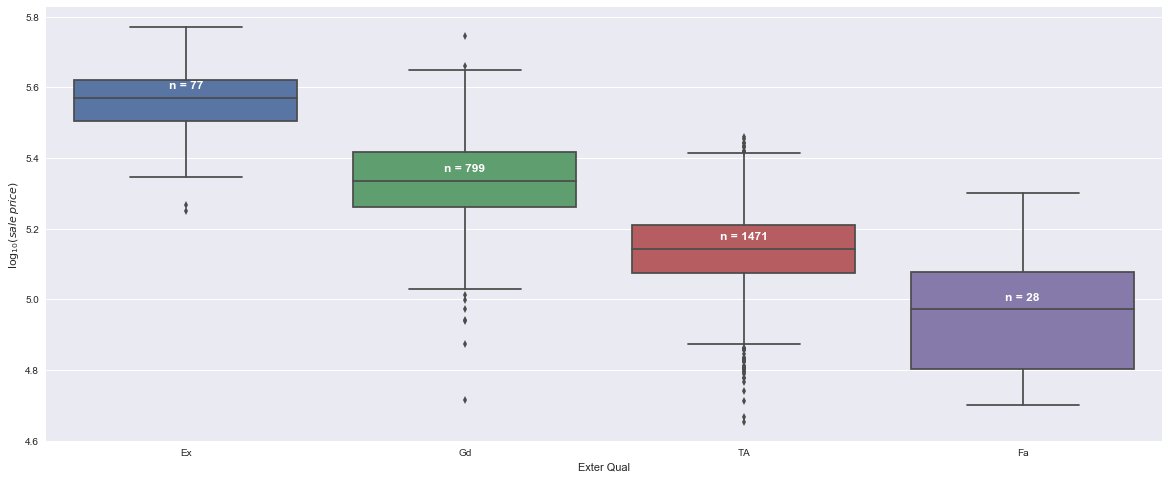

In [54]:
eda_saleprice_boxplot('Exter Qual')

Also a nice predictor, even if the sample sizes are less spreaded than for the overall quality variable. 

### Basement Quality

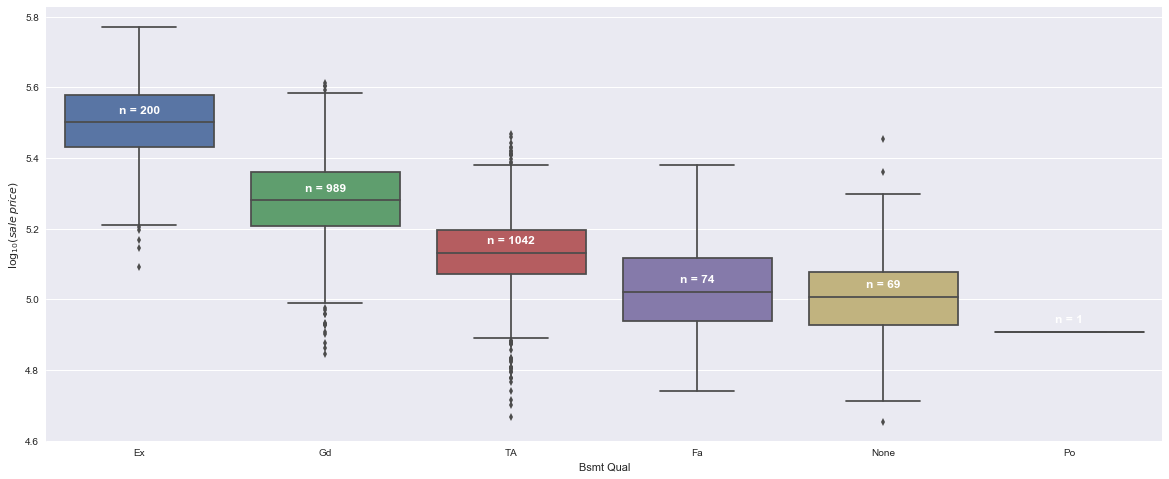

In [55]:
eda_saleprice_boxplot('Bsmt Qual')

Also a nice predictor (same concern as above). To get rid of the unique `Po` observation, we can remap it to the `Fa` category.  
Note that the `None` category is a dummy variable that indicates if the house has a basement or not.

### Kitchen Quality

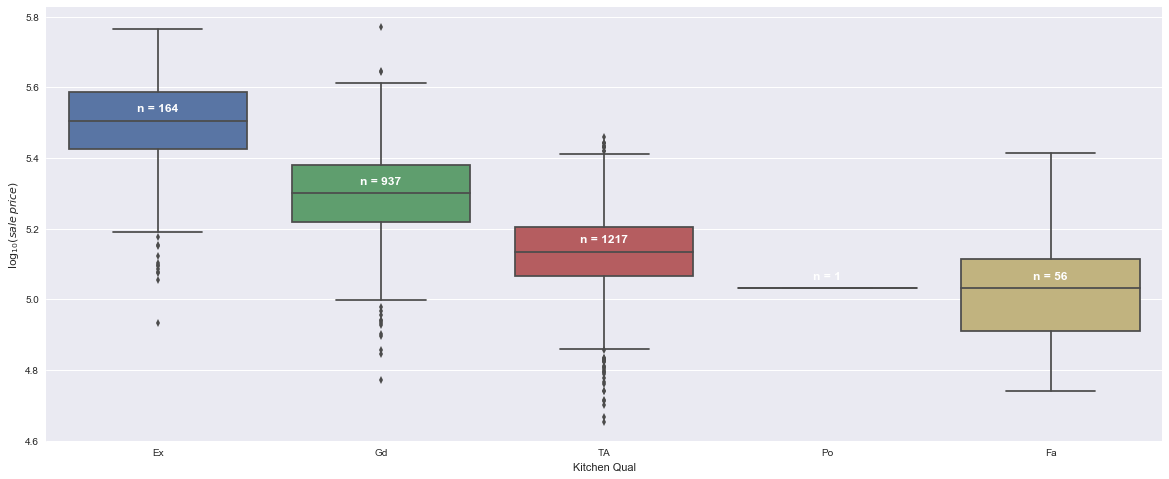

In [56]:
eda_saleprice_boxplot('Kitchen Qual')

Same idea as above: merge `Po` and `Fa` categories...

### Garage Quality

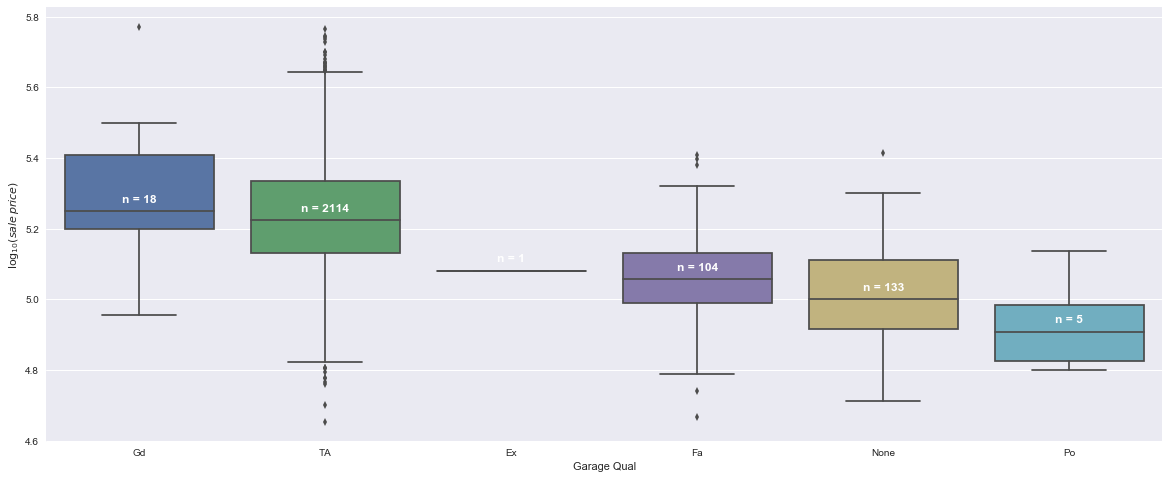

In [57]:
eda_saleprice_boxplot('Garage Qual')

We have previously suggested some mapping simplification to reduce the number of dimensions. Quality variables are ordinal variables, so we don't have necessarly to apply these mappings. The proposed mappings make more sense if we think we should treat these variables as nominal variables, then transformed as one hot encoded variables, in which case reducing the number of indicator variables (dimensions) can be valuable.

Suggested mapping:
* Ex => Gd
* Po => Fa

Note the `None` category that informs if the house as a garage or not.

### Heating Quality

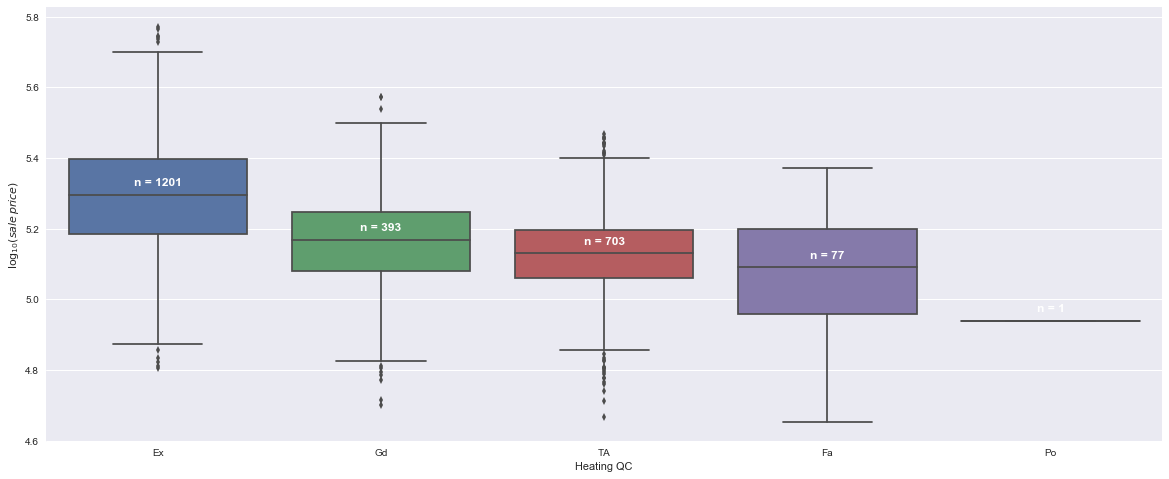

In [58]:
eda_saleprice_boxplot('Heating QC')

Ames climate is cold the winter and heating is definitively something important. Here we can see that more than half of the houses have excellent quality heating. We can maybe consider this variable as an indicator variable:
* Ex => 0
* All others => 1

### Fireplace Quality

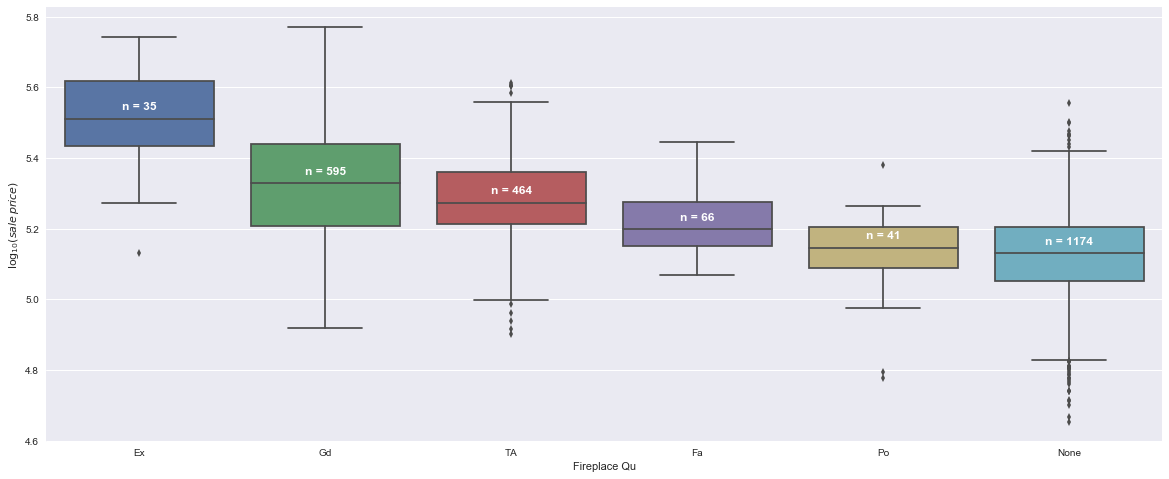

In [59]:
eda_saleprice_boxplot('Fireplace Qu')

Half of the houses don't have fireplace but there is a correlation with the sale price. Note the `None` category that indicates if the house has a fireplace.

## 4.6 Garage

### Garage Finish

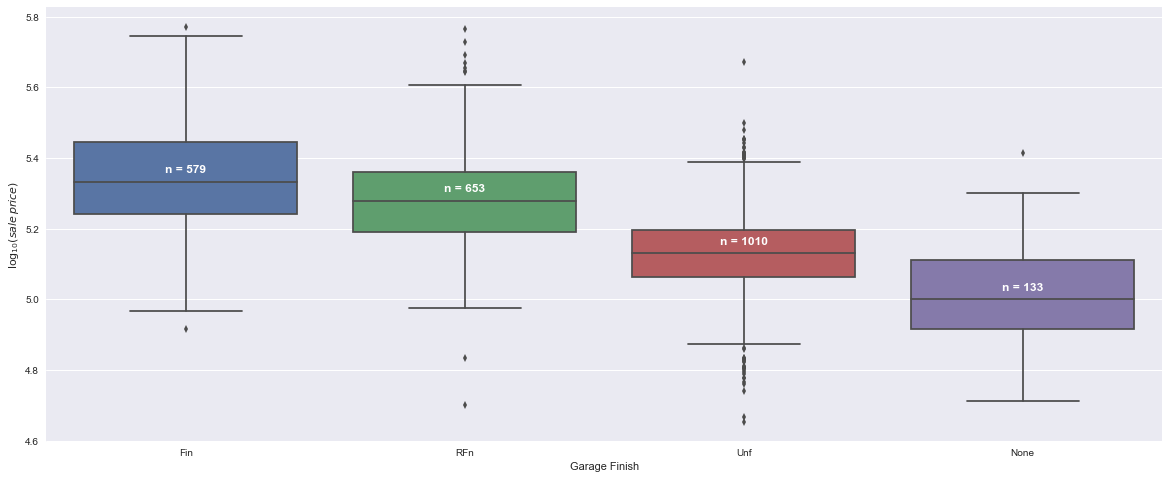

In [60]:
eda_saleprice_boxplot('Garage Finish')

Looks like a promising predictor because there is an clear positive correlation and the sample sizes are well spreaded. Half of the houses have unfinished garage intererior but 1/4 of them have a finished garage and cost significantly more. Note the `None` category that indicates if the house has a garage.

### Paved Drive

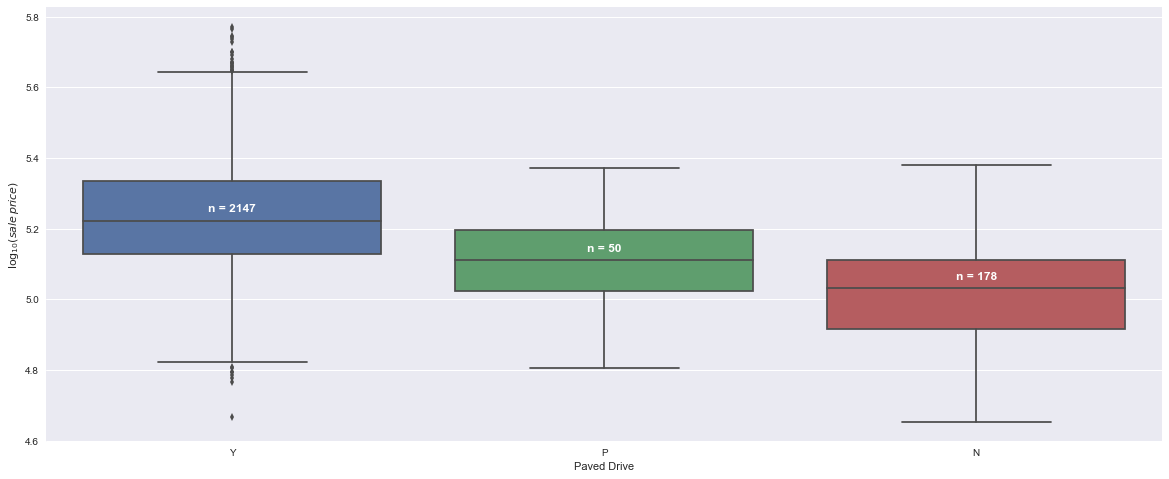

In [61]:
eda_saleprice_boxplot('Paved Drive')

There are surely a lot of snow in Ames during the winter. People just want paved driveway, nothing else. We can probably consider this variable as an indicator variable:
* Y => 0
* Other => 1  (negative correlation expected)

### Garage Cars

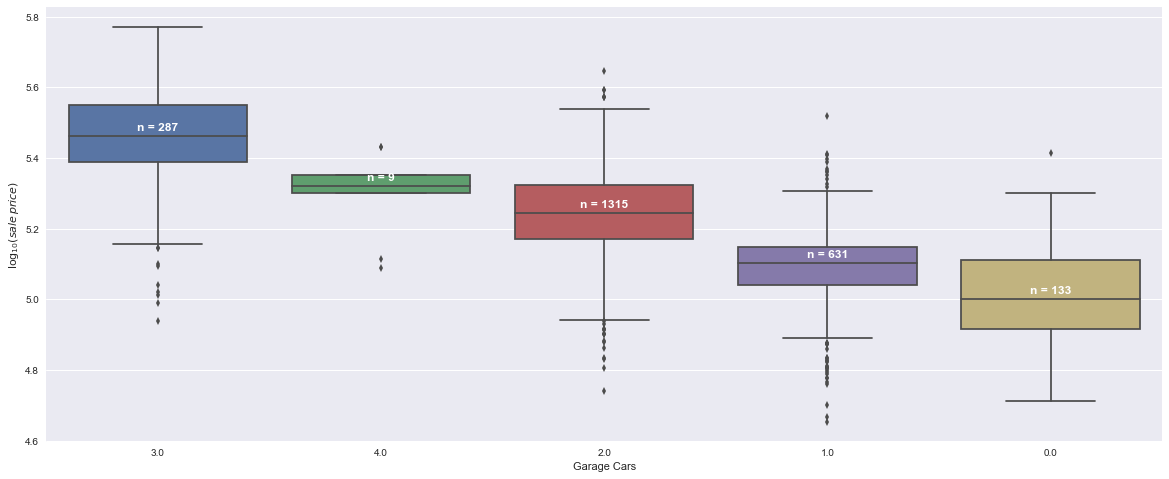

In [62]:
eda_saleprice_boxplot('Garage Cars', text_offset=0.015)

There is probably a strong correlation between the garage cars and the garage area variables. We will check that later and decide if we need to drop one of them but it looks a good predictor. Maybe capping this variable to three could be a good idea...

## 4.7 Equipement

### Electrical

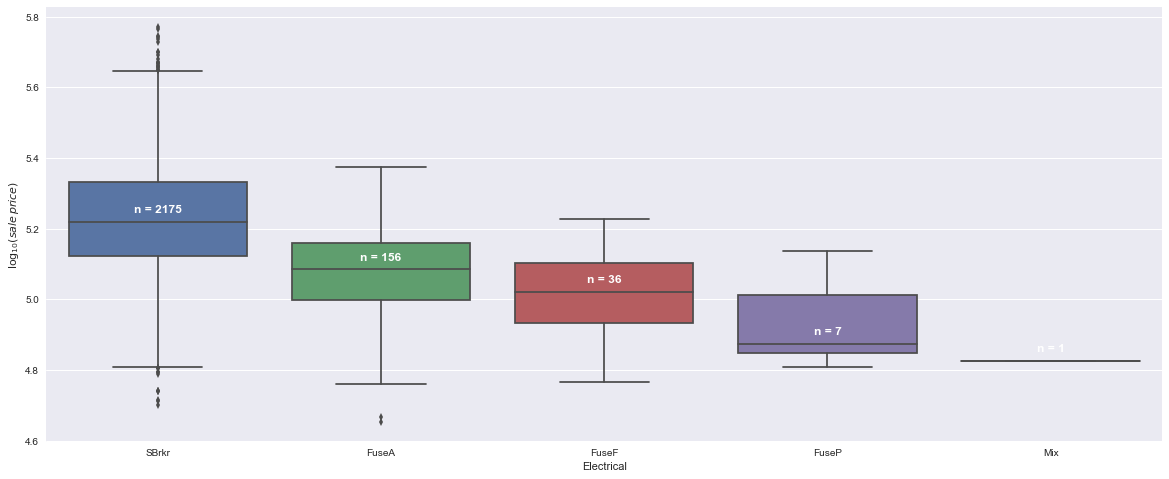

In [63]:
eda_saleprice_boxplot('Electrical')

People expect to have standard circuit breakers & romex, nothing else. An indicator variable seems indicated...
* SBrkr => 0 
* others => 1 (negative correlation expected)

### Heating

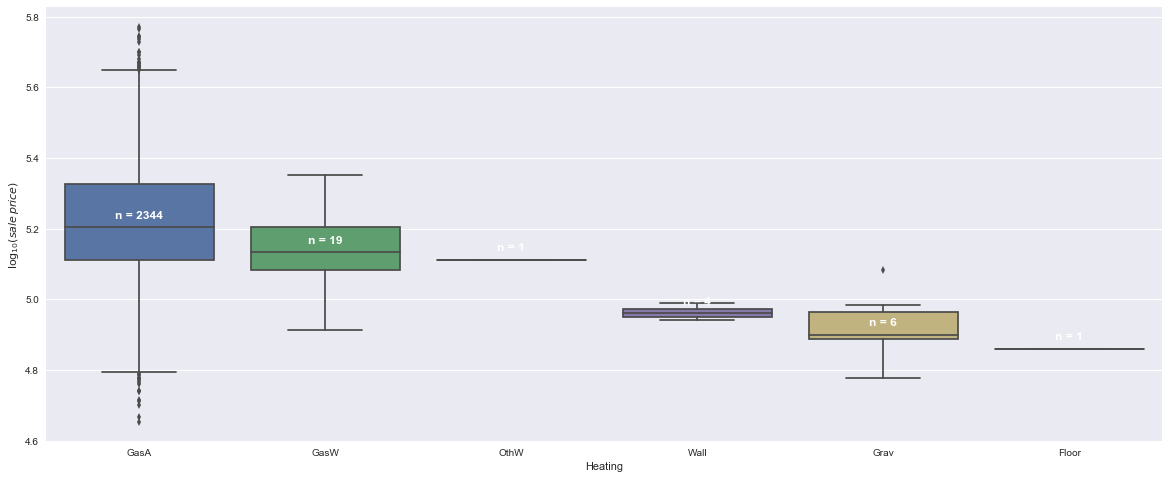

In [64]:
eda_saleprice_boxplot('Heating')

Looks not like a good predictor... (could be a dummy variable GasA => 0, Other => 1 or something similar)

### Central Air

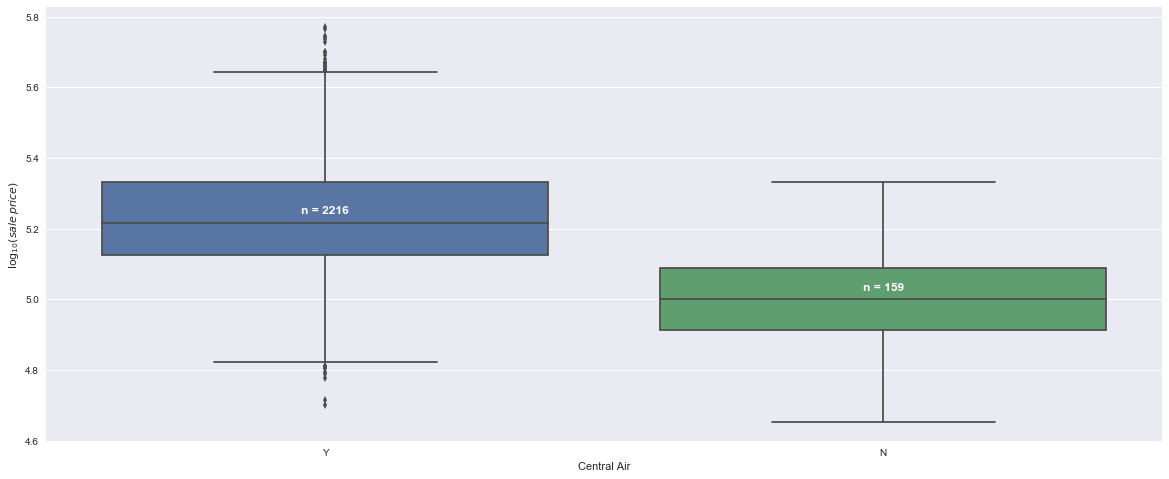

In [65]:
eda_saleprice_boxplot('Central Air')

Significant, already an indicator variable but we could invert the logic:
* Y => 0 
* N => 1 (negative correlation expected)

## 4.8 EDA Conclusion

It concludes our explonatory data analysis. We don't have cover all the variables and have essentially followed our intuition. We have gather some usefull insights and already have interesting modeling path to try and explore. We have seen that areas and quality are strongly correlated with the sale price. Location with the Neighborhood variable looks mandatory to explain parts of the variance. 

We also discovered interesting trends with the time/period variables. New houses cost clearly more than older ones. Over the timeline of our data, the sale price tends to decrease, the fault to the 2005 US real estate crash?. We also noticed a number of sales periodic behaviour, from mars/april to june/jully the number of sales increases and decreases afterwards. The sale price seems to follow an offer/demand pattern that create some higher frequency price fluctuations. 

We already learnt that basement and garage/cars are really important and confirmed that people expect some standard equipement and conveniences. If not reached, this lack of standards could help us to explain the price of the cheapest houses.

Even if we don't have explored all the variables, the visualization functions can easely be used in the rest of the notebook to decide if a variable merits its place in our models...

# 5. Correlation Matrix with some encoding and feature engineering

Before to go ahead with models, it can be interesting to look at the correlation between the variables to know if we have collinear or near collinear variables but also which variables have the strongest correlation with the sale price. This correlation analysis can't take into account the nominal variables. We need to take care about our interpretation about the correlation involving the ordinal variables because ordered values doesn't mean quantifiable values. 

First, we need to encode the data and it is a good opportunity to use the `ModelDataFrameBuilder` class that we will use extensively to build our models later (documentation of the class in the my_model_tools.ipynb). Concerning the encoding, for this analysis, we don't care too much about the mapping, we simply map integers for each categories specified in the documentation.

### Encoding/Mappings for Ordinal Variables

Nothing special here, we just map integers to each categories. Note that the `None` category is always mapped to the value `0`. We have also mapped a `0` value for categories that are the variable mode in a huge proportion compare to the other ones.

In [66]:
# Build a dictionnary that contain mappings for each variable
mappings = {}

mappings['Overall Qual'] = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
mappings['Overall Cond'] = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
mappings['Lot Shape']    = {'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3}
mappings['Utilities']    = {'AllPub': 0, 'NoSewr': 1, 'NoSeWa': 2, 'ELO': 3}
mappings['Land Slope']   = {'Gtl': 0, 'Mod': 1, 'Sev': 2}
mappings['Exter Qual']   = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
mappings['Exter Cond']   = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
mappings['Heating QC']   = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
mappings['Electrical']   = {'SBrkr': 0, 'FuseA': 1, 'FuseF': 2, 'FuseP': 3, 'Mix': 4}
mappings['Kitchen Qual'] = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
mappings['Functional']   = {'Typ': 0, 'Min1': 1, 'Min2': 2, 'Mod': 3, 'Maj1': 4, 'Maj2': 5, 'Sev': 6, 'Sal': 7}
mappings['Paved Drive']  = {'Y': 0, 'P': 1, 'N': 2}

# None codes are mapped to 0 when there is no garage, basement, fireplace, fence, pool
mappings['Pool QC']        = {'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
mappings['Fence']          = {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
mappings['Bsmt Qual']      = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
mappings['Bsmt Cond']      = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
mappings['Bsmt Exposure']  = {'None': 0, 'No': 0, 'Mn': 1, 'Av': 2, 'Gd': 3}
mappings['BsmtFin Type 1'] = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
mappings['BsmtFin Type 2'] = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
mappings['Fireplace Qu']   = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
mappings['Garage Finish']  = {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
mappings['Garage Qual']    = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
mappings['Garage Cond']    = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

### Cleaning Nominal Variables Categories

Nominal variables can't be used for this analysis but we profit to clean some inconsistencies in the nominal variable categories:

* Remove trailing space to Sale Type > WD category
* Fix typo in the Exterior 2nd variable categories: CmentBd, Brk Cmn, Wd Shng to be the same as the one in Exterior 1st variable
* Rename some categories in the MS Zoning variable: A (agr), C (all), I (all)

Nominal variable encoding/mapping will be done on the fly for each model depending our needs later.

In [67]:
# Sale Type: remove the trailing space to the WD code
data.loc[data['Sale Type'] == 'WD ', 'Sale Type'] = 'WD'

# Exterior 2nd: Inconsistent codes with Exterior 1st for codes: CmentBd, Brk Cmn, Wd Shng
data.loc[data['Exterior 2nd'] == 'CmentBd', 'Exterior 2nd'] = 'CemntBd'
data.loc[data['Exterior 2nd'] == 'Brk Cmn', 'Exterior 2nd'] = 'BrkComm'
data.loc[data['Exterior 2nd'] == 'Wd Shng', 'Exterior 2nd'] = 'WdShing'

# MS Zoning: Code renaming
data.loc[data['MS Zoning'] == 'A (agr)', 'MS Zoning'] = 'A'
data.loc[data['MS Zoning'] == 'C (all)', 'MS Zoning'] = 'C'
data.loc[data['MS Zoning'] == 'I (all)', 'MS Zoning'] = 'I'


### Feature Engineering

Remember in the exploratory data analysis, we have already engineer some new variables:

* `House Area = Gr Liv Area + Total Bsmt SF`
* `Age = Yr Sold - Year Built`
* `Age Remod/Add = Yr Sold - Year Remod/Add`

Let's engineer some new variables for this analysis:

* `Total Porch SF = Screen Porch + Open Porch SF + 3Ssn Porch + Enclosed Porch + Wood Deck SF`
* `Total SF = House Area + Total Porch SF + Garage Area`
* `Total Bath = Full Bath + Bsmt Full Bath + 0.5 * (Half Bath + Bsmt Half Bath)`

In [68]:
# Engineer Total Porch SF variable
data['Total Porch SF'] = data['Screen Porch'] + data['Open Porch SF'] + data['3Ssn Porch'] + data['Enclosed Porch'] + data['Wood Deck SF']
vars_continuous.append('Total Porch SF')

# Engineer Tota SF variable
data['Total SF'] = data['House Area'] + data['Total Porch SF'] + data['Garage Area']
vars_continuous.append('Total SF')

# Engineer Total Bath variable
data['Total Bath'] = data['Full Bath'] + data['Bsmt Full Bath'] + 0.5 * (data['Half Bath'] + data['Bsmt Half Bath'])
vars_discrete.append('Total Bath')

### Correlation Matrix

First, we need to prepare/encode the variables:

In [69]:
vars = []

# Create a Variable object for each continous variables
for var in vars_continuous:
    vars.append(Variable(var, VariableType.CONTINUOUS))

# Create a Variable object for each discrete variables
for var in vars_discrete:
    vars.append(Variable(var, VariableType.DISCRETE))
    
# Create a Variable object for each ordinal variables
for var in vars_ordinal:
    vars.append(Variable(var, VariableType.ORDINAL, mapping=mappings[var]))

We can now prepare the data without modifying our source dataframe:

In [70]:
# Create a ModelDataFrameBuilder object
mdfb = ModelDataFrameBuilder()

# Prepare the data by passing the source dataframe and the list of Variable objects
mdfb.prepare(data, vars)

# Get the prepared data
df = mdfb.data()
df.head()

Lot Frontage  Lot Area  Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  \
0     67.780739      8795           0.0         300.0           0.0   
1     75.000000     10170         522.0           0.0           0.0   
2     21.000000      2001          80.0           0.0           0.0   
3     70.000000     10552           0.0        1018.0           0.0   
4     60.000000     10120           0.0           0.0           0.0   

   Bsmt Unf SF  Total Bsmt SF  1st Flr SF  2nd Flr SF  Low Qual Fin SF  ...    \
0        652.0          952.0         980        1276                0  ...     
1        216.0          216.0        1575           0                0  ...     
2        546.0          546.0         546         546                0  ...     
3        380.0         1398.0        1700           0                0  ...     
4        925.0          925.0         964         925                0  ...     

   Electrical  Kitchen Qual  Functional  Fireplace Qu  Garage Finish  \
0           0             4           0             3              3   
1           0             4           0             4              1   
2           0             3           0             0              1   
3           0             4           0             4              2   
4           2             3           0             4              1   

   Garage Qual  Garage Cond  Paved Drive  Pool QC  Fence  
0            3            3            0        0      0  
1            3            3            0        0      0  
2            3            3            0        0      0  
3            3            3            0        0      0  
4            3            3            2        0      3  

[5 rows x 63 columns]

We want to compute the correlation matrix and look at the correlation of each variables with the log transformed sale price.

In [71]:
# Get the correlation matrix
df_corr = df.corr()

# Correlation with the sale price
df_corr.loc['SalePriceLog', :].sort_values(ascending=False)

SalePriceLog       1.000000
Total SF           0.850798
Overall Qual       0.826005
House Area         0.813639
Gr Liv Area        0.704249
Exter Qual         0.693641
Garage Cars        0.685923
Garage Area        0.668412
Kitchen Qual       0.666445
Total Bath         0.660824
Total Bsmt SF      0.649937
Year Built         0.646724
Bsmt Qual          0.639491
Garage Yr Blt      0.615222
1st Flr SF         0.613544
Garage Finish      0.608236
Year Remod/Add     0.588097
Full Bath          0.577711
Fireplace Qu       0.568130
Fireplaces         0.496769
Heating QC         0.487487
TotRms AbvGrd      0.474412
Mas Vnr Area       0.471362
BsmtFin SF 1       0.418939
Total Porch SF     0.385445
BsmtFin Type 1     0.380855
Bsmt Exposure      0.371483
Garage Qual        0.358961
Open Porch SF      0.348873
Garage Cond        0.344968
                     ...   
Lot Area           0.320616
Half Bath          0.295774
Bsmt Cond          0.277888
Bsmt Full Bath     0.273110
2nd Flr SF         0

We find results in phase with our EDA:

The top best predictors (excluded nominal variables) are:

* Total SF (even better than House Area) ~0.851
* House Area ~0.814 (included in Total SF)
* Overall Quality ~0.826

And we have strong positive correlation with
* Gr Liv Area ~0.704 (included in Total SF, House Area)
* Exterior Quality ~0.694
* Garage Area ~0.668 & Garage Cars ~0.686 (included in the Total SF)
* Kitchen Quality ~0.666
* Total Bath ~0.661
* Basement Quality ~0.639

And strong negative correlation with
* Age ~ -0.6247
* Age Remod/Add ~-0.59 

Our Age & Age Remod/Add variables are a little bit better than their counterpart Yr Built & Year Remod/Add.

What about correlation between all variables ?  
Because a heatmap would be hard to read, we will print the correlations between variables greater than 0.7 and lower than -0.7.

In [72]:
# only correlation >= 0.7 and < 1
filter = (np.abs(df_corr.stack()) > 0.7) & (np.abs(df_corr.stack()) < 1)

# ordered highest correlations (the [::2] allow to get rid of the duplicates from the matrix symmetry)
df_corr.stack()[filter].sort_values(ascending=False) [::2]

House Area      Total SF          0.969090
Garage Qual     Garage Cond       0.948418
Garage Area     Garage Cars       0.895041
Fireplaces      Fireplace Qu      0.864517
Garage Yr Blt   Year Built        0.859834
House Area      Gr Liv Area       0.852376
Total SF        SalePriceLog      0.850798
Gr Liv Area     Total SF          0.828043
Pool Area       Pool QC           0.826229
SalePriceLog    Overall Qual      0.826005
House Area      SalePriceLog      0.813639
                Total Bsmt SF     0.813460
BsmtFin Type 2  BsmtFin SF 2      0.804108
TotRms AbvGrd   Gr Liv Area       0.801614
Total Bsmt SF   Total SF          0.786077
1st Flr SF      Total Bsmt SF     0.773974
                House Area        0.765842
Total Porch SF  Wood Deck SF      0.754976
1st Flr SF      Total SF          0.751505
Exter Qual      Overall Qual      0.730548
BsmtFin SF 1    BsmtFin Type 1    0.722325
Full Bath       Total Bath        0.705470
Kitchen Qual    Exter Qual        0.705230
SalePriceLo

Of course, there are strong correlation between variables and engineered variables built from them.

But there are also other near collinear variables:

* Garage Qual & Garage Cond (need to remove one of them)
* Garage Cars & Garage Area (need to remove one of them)
* Garage Yr Built & Year Built (need to remove Garage Yr Built, already identified as not very clean)
* TotRms AbvGrd & Gr Liv Area (need to remove one of them, TotRms AbvGrd probably)

Note that there are some artificial strong correlation between these variables
* Fireplace Qu & Fireplaces (reinforced correlation: when no fireplace => Fireplace Qu = None)
* Pool Area & Pool QC (reinforced correlation: when no pool => Pool QC = None)
* BsmtFin Type 2 & BsmtFin SF 2 (reinforced correlation: when BsmtFin SF 2 = 0 => BsmtFin Type 2 = Unf

I don't like to drop variables, so will simply remember to not use these variables:

1. Garage Cond
2. Garage Cars (even if the correlation is strong than the Garage Area variable, I prefer to keep continuous variable)
3. Garage Yr Built
4. TotRms AbvGrd

# 6. Models with two variables

We can now start to build our model with two variables. From the correlation matrix analysis, it appears that we should obtain the best results by using the `Total SF` and `Overall Qual` variables. However, this analysis didn't take into account the nominal variables and we know from the EDA that the `Neighborhood` and `Sale Condition` (new house high prices and special low sales conditions) could be strong predictors. So, we will also build models with them and compare the different two variables models.

To asses our models, we will print the train/test RMSLE and train/test MAE. Minimizing the RMSLE (L2) should be done with a `LinearRegression` model. Minimizing the MAE (L1) should be done with a `HuberRegressor` model. From a business perspective, I don't see any justification to try to optimize the RMSLE.

So, the results presented by default below will be the one that minimize the MAE (HuberRegressor) but the results for the simpler LinearRegression will be printed for convenience. Changing the `USE_LINEAR_REGRESSION_MODEL` from `False` to `True` allow to choose the model to use...

## 6.1 Total SF & Sale Condition

Preparation of the data is done as follow:

1. We compute the square root transformation of the `Total SF` variable for better distribution (`fn` parameters)
2. We simplify the `Sale Condition` variable with the following mapping:
    - Every category mapped to Other, except Partial, Abnormal and Family sale conditions


Train Set Scores:
-----------------
RMSLE Baseline : 0.164798
MAE Baseline : 52417.16

RMSLE : 0.081941
MAE   : 24235.2
R2    : 0.78733

Test Set Scores:
----------------
RMSLE Baseline : 0.170028
MAE Baseline : 54103.79

RMSLE : 0.085542
MAE   : 25507.33
R2    : 0.76641


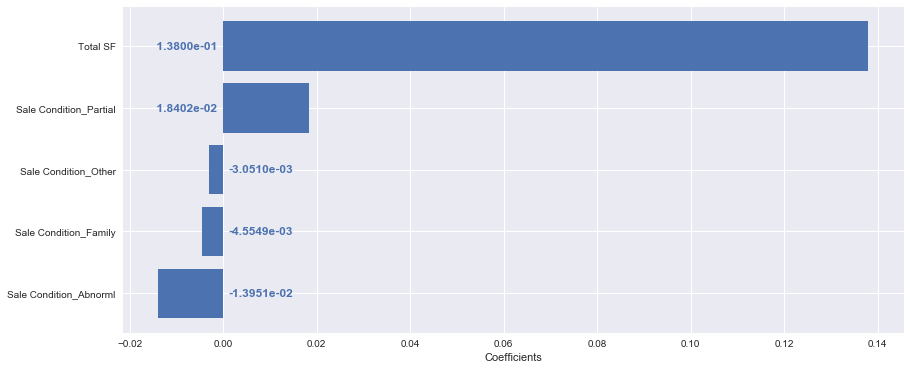

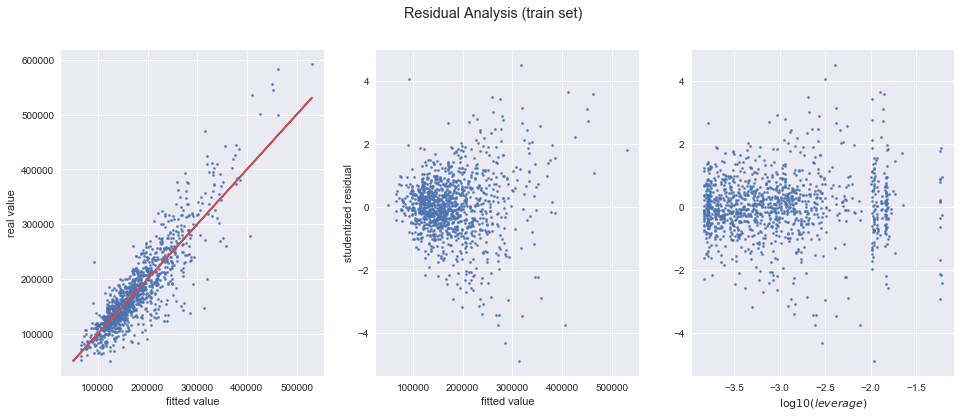

In [73]:
USE_LINEAR_REGRESSION_MODEL = False

# Mapping to use the ordinal overall qual variable as a nominal variable with dimension reduction
mapping_sale_condition = { 'Partial': 'Partial', 'Abnorml': 'Abnorml', 'Family': 'Family',
                           'Normal': 'Other', 'Alloca': 'Other', 'AdjLand': 'Other'}

# variables used to build the model
vars = [
    Variable('SalePriceLog', VariableType.CONTINUOUS),
    Variable('Total SF', VariableType.CONTINUOUS, fn=np.sqrt),
    Variable('Sale Condition', VariableType.NOMINAL, mapping=mapping_sale_condition),
]

# prepare the data
mdfb = ModelDataFrameBuilder()
mdfb.prepare(data, vars)

# Normalize the data
if not USE_LINEAR_REGRESSION_MODEL:
    mdfb.normalize(exclude=['SalePriceLog'], method='z-score')

# Get the prepared data
df = mdfb.data()

# build the model
if not USE_LINEAR_REGRESSION_MODEL:
    model = HuberRegressor(epsilon=1.5)
else:
    model = LinearRegression()
    
ma_2 = ModelAgent(model)
ma_2.fit_and_evaluate(df, 'SalePriceLog', inverse_fn=log10_inverse_fn)

# print model results
print_scores(ma_2)
if not USE_LINEAR_REGRESSION_MODEL:
    ma_2.plot_coefs(figsize=(14,6), offset=0.015)
    ma_2.residuals_analysis(plot=True)

Results by using a `LinearRegression()` model:

**Train Set Scores:**  

RMSLE Baseline : 0.164798  
MAE Baseline : 52417.16

RMSLE : 0.081561  
MAE   : 24478.69  
R2    : 0.78324  

**Test Set Scores:**

RMSLE Baseline : 0.170028  
MAE Baseline : 54103.79

RMSLE : 0.084999  
MAE   : 25729.55  
R2    : 0.76227  

It is a simple model but not a bad one. Not far to achieve the Pareto rule: having the 20% of variables that explain 80% of the variance :)  
The coefficients are clear, new houses increase the price, abnormal and family sales decrease it. The total area has of course more impact on the sale price. Note that the model tends to under evaluate the sale price and its predictions become less precise with incresing prices.

In [74]:
# Save the MAE & RMSLE for comparison later
mae_2_salecondition   = 25507.33  # huber regression
rmsle_2_salecondition = 0.084999  # linear regression

## 6.2 Total SF & Neighborhood

Preparation of the data is done as follow:

1. We compute the square root transformation of the `Total SF` variable for better distribution (`fn` parameters)
2. We group together the locations with low sample sizes in an `Other` location category:
    - Landmrk, GrnHill, Blueste, Greens, Veenker are grouped together


Train Set Scores:
-----------------
RMSLE Baseline : 0.164798
MAE Baseline : 52417.16

RMSLE : 0.06865
MAE   : 20209.93
R2    : 0.83876

Test Set Scores:
----------------
RMSLE Baseline : 0.170028
MAE Baseline : 54103.79

RMSLE : 0.070588
MAE   : 20127.93
R2    : 0.8508


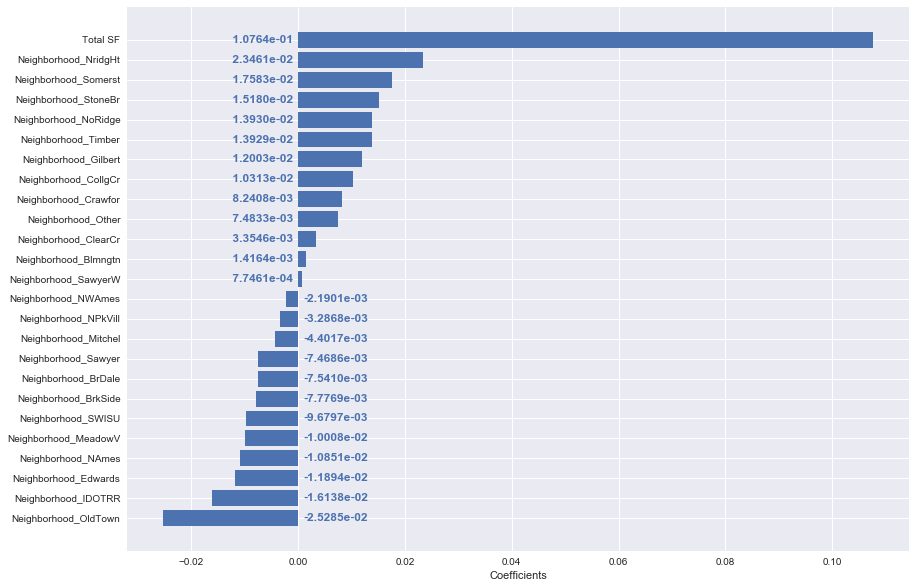

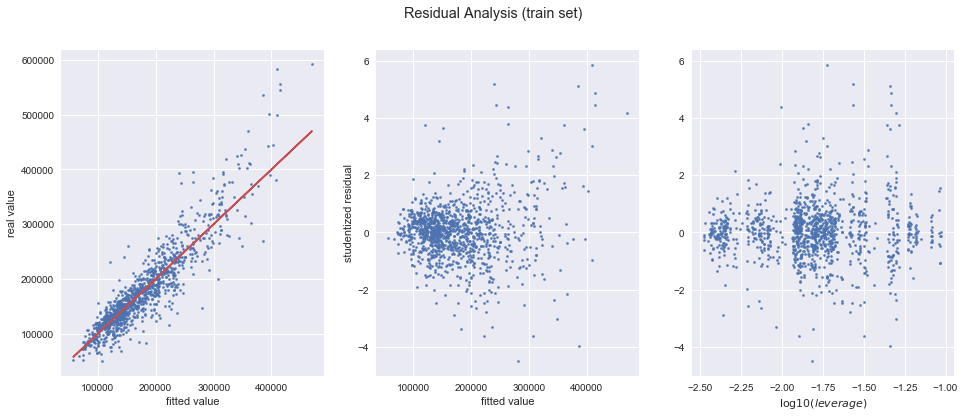

In [75]:
USE_LINEAR_REGRESSION_MODEL = False

# Mapping to use the ordinal overall qual variable as a nominal variable with dimension reduction
mapping_neighborhood = {
    'Landmrk': 'Other', 'GrnHill': 'Other', 'Blueste': 'Other', 'Greens': 'Other', 'Veenker': 'Other',
    'Blmngtn': 'Blmngtn', 'NPkVill': 'NPkVill', 'BrDale': 'BrDale', 'MeadowV': 'MeadowV',
    'BrkSide': 'BrkSide', 'ClearCr': 'ClearCr', 'CollgCr': 'CollgCr',
    'Crawfor': 'Crawfor', 'Edwards': 'Edwards', 'Gilbert': 'Gilbert',
    'IDOTRR': 'IDOTRR', 'Mitchel': 'Mitchel', 'NAmes': 'NAmes', 'NoRidge': 'NoRidge', 
    'NridgHt': 'NridgHt', 'NWAmes': 'NWAmes', 'OldTown': 'OldTown',
    'SWISU': 'SWISU', 'Sawyer': 'Sawyer', 'SawyerW': 'SawyerW',
    'Somerst': 'Somerst', 'StoneBr': 'StoneBr', 'Timber': 'Timber'
}

# variables used to build the model
vars = [
    Variable('SalePriceLog', VariableType.CONTINUOUS),
    Variable('Total SF', VariableType.CONTINUOUS, fn=np.sqrt),
    Variable('Neighborhood', VariableType.NOMINAL, mapping=mapping_neighborhood),
]

# prepare the data
mdfb = ModelDataFrameBuilder()
mdfb.prepare(data, vars)

# Normalize the data
if not USE_LINEAR_REGRESSION_MODEL:
    mdfb.normalize(exclude=['SalePriceLog'], method='z-score')

# Get the prepared data
df = mdfb.data()

# build the model
if USE_LINEAR_REGRESSION_MODEL:
    model = LinearRegression()
else:
    model = HuberRegressor(epsilon=1.8)
    
ma_2 = ModelAgent(model)
ma_2.fit_and_evaluate(df, 'SalePriceLog', inverse_fn=log10_inverse_fn)

# print model results
print_scores(ma_2)
if not USE_LINEAR_REGRESSION_MODEL:
    ma_2.plot_coefs(figsize=(14,10), offset=0.013)
    ma_2.residuals_analysis(plot=True)

Results by using a `LinearRegression()` model:

**Train Set Scores:**

RMSLE Baseline : 0.164798  
MAE Baseline : 52417.16

RMSLE : 0.068461  
MAE   : 20315.54  
R2    : 0.83763  

**Test Set Scores:**

RMSLE Baseline : 0.170028  
MAE Baseline : 54103.79

RMSLE : 0.070301  
MAE   : 20206.06  
R2    : 0.85031  

This model is clearly better than the previous one. We have reached the Pareto rules, Yay !
Note that this model tends also to under evaluate the sale price but the precision deviation with the increasing price is more controlled even if clearly visible. The coefficients give an idea about the cheaper and more expensive locations but it is too early to believe in their order...

In [76]:
# Save the MAE & RMSLE for comparison later
mae_2_neighborhood   = 20127.93  # huber regression
rmsle_2_neighborhood = 0.070301  # linear regression

## 6.3 Total SF & Overall Qual

Preparation of the data is done as follow:

1. We compute the square root transformation of the `Total SF` variable for better distribution (`fn` parameters)
2. We use the `Overall Qual` variable as a nominal variable and we apply one hot encoding. We reduce the number of dimensions by applying the following mapping:
    * 1, 2, 3, 4 => 1
    * 5 => 2
    * 6 => 3
    * 7 => 4
    * 8 => 5
    * 9, 10 => 6
    
Note: Using directly this variable without creation of dummy variables and no change in mapping give the same results. I just find more interesting to vizualise it as a one hot encoded variable with reduced dimensions. For intermediate and all variables models, we will use it directly without transformations...


Train Set Scores:
-----------------
RMSLE Baseline : 0.164798
MAE Baseline : 52417.16

RMSLE : 0.06803
MAE   : 19341.93
R2    : 0.86577

Test Set Scores:
----------------
RMSLE Baseline : 0.170028
MAE Baseline : 54103.79

RMSLE : 0.069216
MAE   : 19969.54
R2    : 0.86555


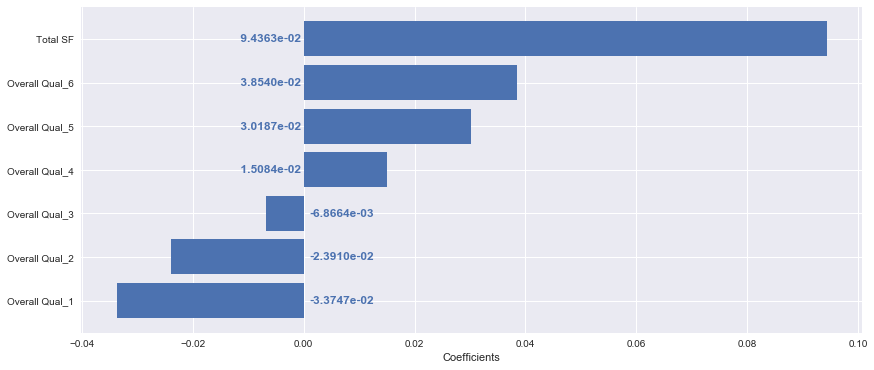

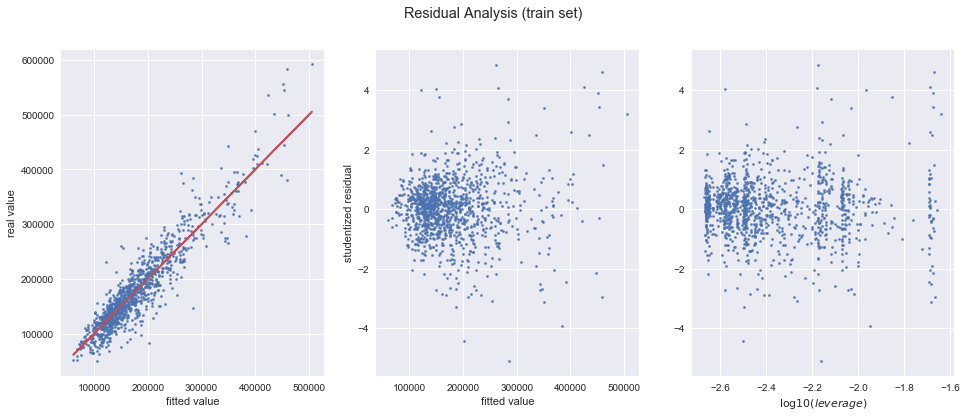

In [77]:
USE_LINEAR_REGRESSION_MODEL = False

# Mapping to use the ordinal overall qual variable as a nominal variable with dimension reduction
mapping_overall_qual = {1: 1, 2: 1, 3: 1, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5, 9: 6, 10: 6}

# variables used to build the model
vars = [
    Variable('SalePriceLog', VariableType.CONTINUOUS),
    Variable('Total SF', VariableType.CONTINUOUS, fn=np.sqrt),
    Variable('Overall Qual', VariableType.NOMINAL, mapping=mapping_overall_qual)
]

# prepare the data
mdfb = ModelDataFrameBuilder()
mdfb.prepare(data, vars)

# Normalize the data
if not USE_LINEAR_REGRESSION_MODEL:
    mdfb.normalize(exclude=['SalePriceLog'], method='z-score')

# Get the prepared data
df = mdfb.data()

# build the model
if USE_LINEAR_REGRESSION_MODEL:
    model = LinearRegression()
else:
    model = HuberRegressor(epsilon=1.8)
    
ma_2 = ModelAgent(model)
ma_2.fit_and_evaluate(df, 'SalePriceLog', inverse_fn=log10_inverse_fn)

# print model results
print_scores(ma_2)
if not USE_LINEAR_REGRESSION_MODEL:
    ma_2.plot_coefs(figsize=(14,6), offset=0.012)
    ma_2.residuals_analysis(plot=True)

Results by using a `LinearRegression()` model:

**Train Set Scores:** 

RMSLE Baseline : 0.164798  
MAE Baseline : 52417.16  

RMSLE : 0.06791  
MAE   : 19515.91  
R2    : 0.86505  

**Test Set Scores:**   

RMSLE Baseline : 0.170028  
MAE Baseline : 54103.79  

RMSLE : 0.068888  
MAE   : 19987.06  
R2    : 0.86521  

This last model is again better from a small margin, however its global behaviour from cheap to the most expensive houses looks much better/balanced.

In [78]:
# Save the MAE & RMSLE for comparison later
mae_2_overallqual   = 19969.54  # huber regression
rmsle_2_overallqual = 0.068888  # linear regression

mae_baseline = 54103.79
rmsle_baseline = 0.170028

## 6.4 Two Variables Models Comparison

Overall, these models are already good to predict prices with minimal effort with a mean absolute error around 20'000 dollars, with a tendency to under evaluate the prices. From a business perspective, I would prefer the "Neighborhood" model because it is a totally objective variable; quality is more subjective.

Let's draw bar plots to compare the models MAE & RMSLE:

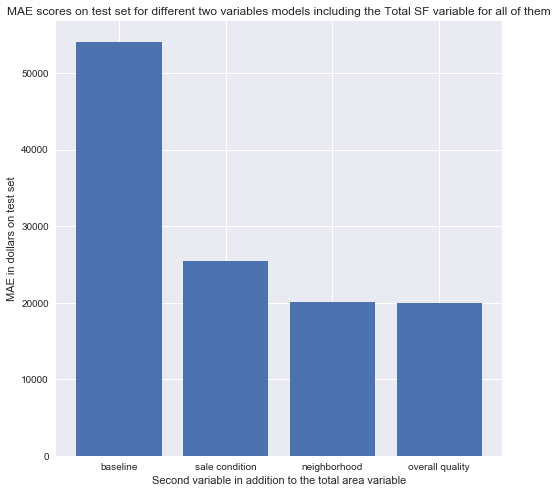

In [79]:
# Plot MAE Scores comparison
mae_scores = [mae_baseline, mae_2_salecondition, mae_2_neighborhood, mae_2_overallqual]
labels = ['baseline', 'sale condition', 'neighborhood', 'overall quality']

plt.figure(figsize=(8, 8))
plt.bar(np.arange(len(mae_scores)), mae_scores, tick_label=labels)
plt.xlabel('Second variable in addition to the total area variable')
plt.ylabel('MAE in dollars on test set')
plt.title('MAE scores on test set for different two variables models including the Total SF variable for all of them')
plt.show()

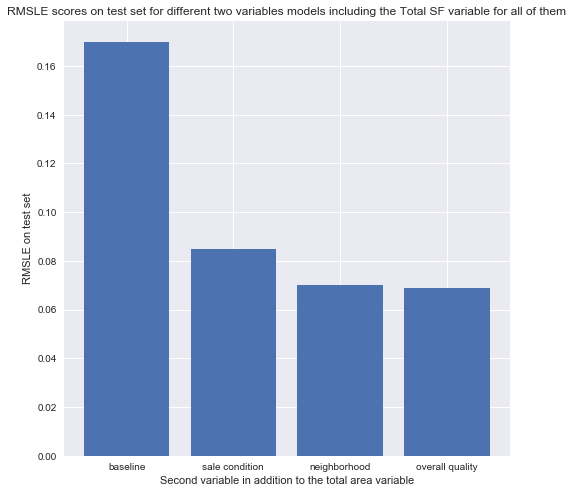

In [80]:
# Plot RMSLE Scores comparison
rmsle_scores = [rmsle_baseline, rmsle_2_salecondition, rmsle_2_neighborhood, rmsle_2_overallqual]
labels = ['baseline', 'sale condition', 'neighborhood', 'overall quality']

plt.figure(figsize=(8, 8))
plt.bar(np.arange(len(rmsle_scores)), rmsle_scores, tick_label=labels)
plt.xlabel('Second variable in addition to the total area variable')
plt.ylabel('RMSLE on test set')
plt.title('RMSLE scores on test set for different two variables models including the Total SF variable for all of them')
plt.show()

# 7. Intermediate Model with 20 Variables

Preparation of the data is done as follow:

1. We compute the square root transformation of the `Gr Liv Area` variable
2. We compute the logarithmic transformation of the `Lot Area` variable
2. We remap/regroup categories with not sufficient sample size (ordinal & nominal variables)
    
**Note 1:** Here, we use the quality variables scores directly (no split in dummy variables)

**Note 2:** The `Exterior 1st` mapping looks weird but it is the result of multiple iterations by looking the coefficients of each dummy variables and keeping the ones that has the more effect on the sale price.

**Note 3:** Analysis of the distribution of the continous variable says that it could be better to apply square root transformation to most of them but it negates our MAE results... So, I don't touch it...

**Note 4:** I tried a lot of preparations with different engineered variables (has fireplace, has second floor, has basement, polynomial feature of age variables, houses 60+ years old, etc. but never found one better than the ones we engineered during the EDA. Only exception for the `Total Bath` variable that I tried for joke with its 1/2 factor :)

Globally, this model is issued from the insight gathered during the EDA and follow the pattern:

`Area | Location | Period/Time | Quality | Sale Process | Equipement/Convenience `

And because more variables where allowed simply use the detailed area variables for the basement, use multiple quality variables, enough to get an idea about the location, its environment/type of house, and the well known age, age remod/add and sale condition variables. Nothing really new, the new variables come from a lot of tests & combinaison trials.

**Note 5:** In fact, I tried so much data preapration that I am convinced that if its possible to decrease the MAE by some thousands dollars again it is by the engineering of a winner variable that I did think about it or by splitting the data and building different models for each one (example: one model for recent houses, one for other houses)

In [81]:
# Mappings used for the intermediate model
mappings = {}

mappings['Overall Qual'] = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
mappings['Overall Cond'] = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
mappings['Exter Qual']   = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
mappings['Fireplace Qu'] = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

mappings['Neighborhood'] = {
    'Landmrk': 'Other', 'GrnHill': 'Other', 'Blueste': 'Other', 'Greens': 'Other', 'Veenker': 'Other',
    'Blmngtn': 'Blmngtn', 'NPkVill': 'NPkVill', 'BrDale': 'BrDale', 'MeadowV': 'MeadowV',
    'BrkSide': 'BrkSide', 'ClearCr': 'ClearCr', 'CollgCr': 'CollgCr',
    'Crawfor': 'Crawfor', 'Edwards': 'Edwards', 'Gilbert': 'Gilbert',
    'IDOTRR': 'IDOTRR', 'Mitchel': 'Mitchel', 'NAmes': 'NAmes', 'NoRidge': 'NoRidge', 
    'NridgHt': 'NridgHt', 'NWAmes': 'NWAmes', 'OldTown': 'OldTown',
    'SWISU': 'SWISU', 'Sawyer': 'Sawyer', 'SawyerW': 'SawyerW',
    'Somerst': 'Somerst', 'StoneBr': 'StoneBr', 'Timber': 'Timber'
}

mappings['Condition 1'] = {'Norm': 'Norm', 'Feedr': 'Feedr', 'Artery': 'Artery', 
                           'RRAn': 'RR', 'RRAe': 'RR', 'RRNn': 'RR', 'RRNe': 'RR',
                           'PosN': 'Pos', 'PosA': 'Pos',}

mappings['Sale Condition'] = {'Partial': 'Partial', 'Abnorml': 'Abnorml', 'Family': 'Family',
                              'Normal': 'Normal', 'Alloca': 'Other', 'AdjLand': 'Other'}

mappings['Exterior 1st'] = {
    'ImStucc': 'Other', 'PreCast': 'Other', 'CBlock': 'Other', 'Stone': 'Other', 
    'AsphShn': 'Other', 'BrkComm': 'Other', 'Other': 'Other',
    'VinylSd': 'Other', 'Stucco': 'Other', 'Wd Sdng': 'Other', 'WdShing': 'Other', 'MetalSd': 'Other', 'CemntBd': 'Other',
    'Plywood': 'Plywood', 'BrkFace': 'BrkFace', 'HdBoard': 'HdBoard', 'AsbShng': 'AsbShng'}

mappings['Functional'] = {'Typ': 0, 'Min1': 1, 'Min2': 2, 'Mod': 3, 'Maj1': 4, 'Maj2': 5, 'Sev': 6, 'Sal': 7}


Train Set Scores:
-----------------
RMSLE Baseline : 0.164798
MAE Baseline : 52417.16

RMSLE : 0.04336
MAE   : 11857.6
R2    : 0.94065

Test Set Scores:
----------------
RMSLE Baseline : 0.170028
MAE Baseline : 54103.79

RMSLE : 0.04338
MAE   : 11894.49
R2    : 0.94478


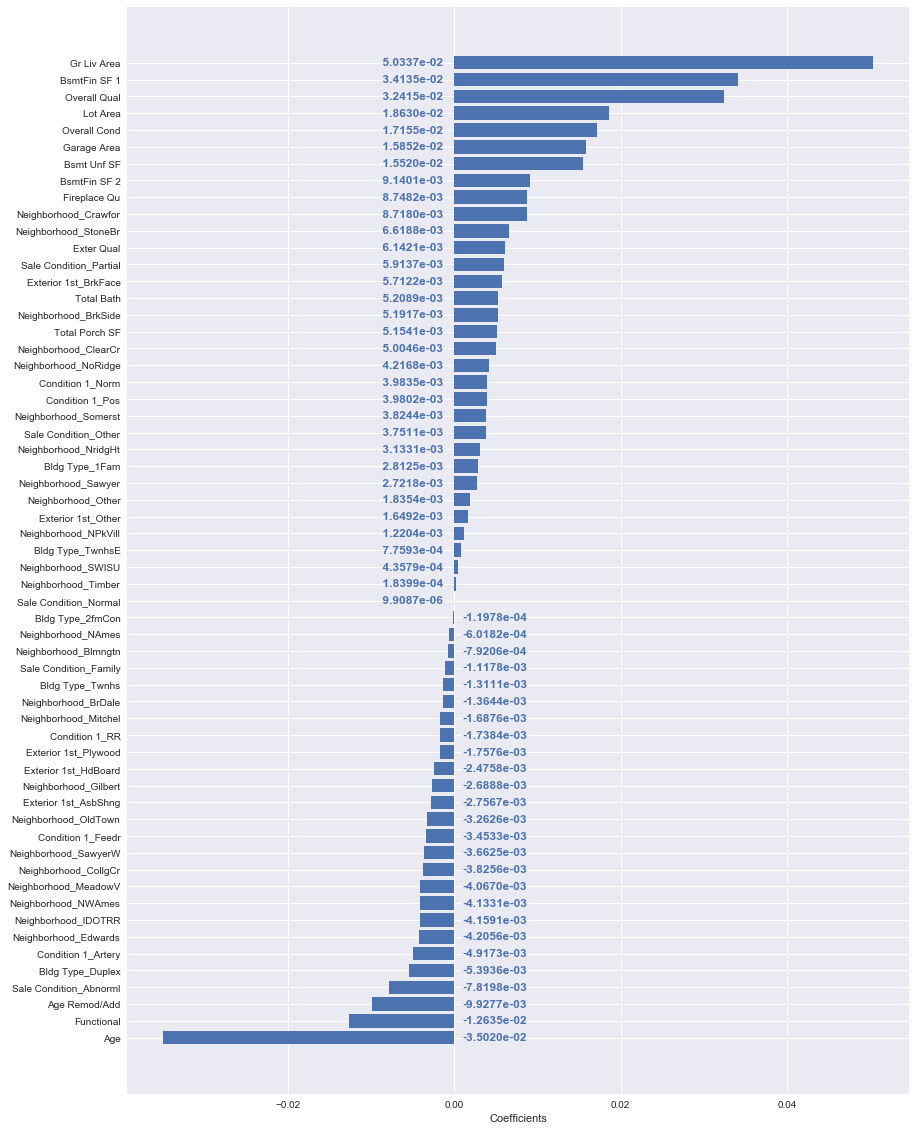

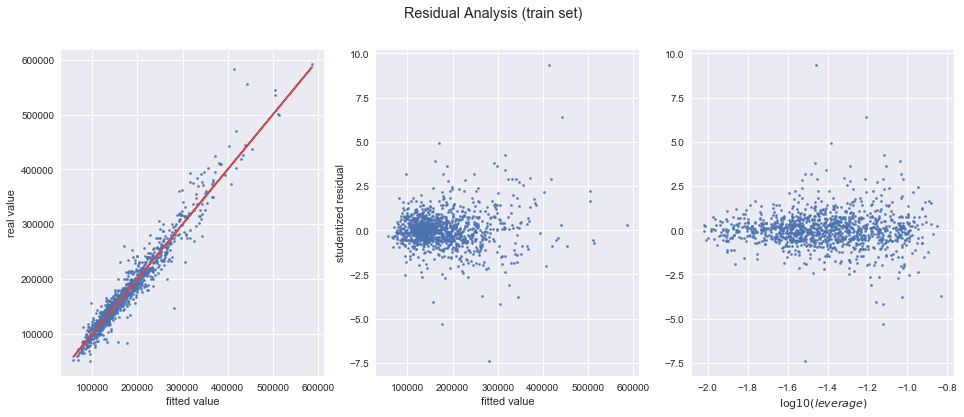

In [82]:
USE_LINEAR_REGRESSION_MODEL = False

# variables used to build the model
vars = [
    Variable('SalePriceLog', VariableType.CONTINUOUS),
    
    # Area variables
    Variable('Gr Liv Area', VariableType.CONTINUOUS, fn=np.sqrt),
    Variable('BsmtFin SF 1', VariableType.CONTINUOUS, ),
    Variable('BsmtFin SF 2', VariableType.CONTINUOUS, ),
    Variable('Bsmt Unf SF', VariableType.CONTINUOUS),
    Variable('Lot Area', VariableType.CONTINUOUS, fn=np.log10),
    Variable('Garage Area', VariableType.CONTINUOUS),    
    Variable('Total Porch SF', VariableType.CONTINUOUS),  
    
    # Period/Time variables
    Variable('Age', VariableType.DISCRETE),
    Variable('Age Remod/Add', VariableType.DISCRETE),
    
    # Quality variables
    Variable('Overall Qual', VariableType.ORDINAL, mapping=mappings['Overall Qual']),
    Variable('Overall Cond', VariableType.ORDINAL, mapping=mappings['Overall Cond']),
    Variable('Exter Qual', VariableType.ORDINAL, mapping=mappings['Exter Qual']),
    Variable('Fireplace Qu', VariableType.ORDINAL, mapping=mappings['Fireplace Qu']),
    
    # Location & House type variables
    Variable('Neighborhood', VariableType.NOMINAL, mapping=mappings['Neighborhood']),
    Variable('Condition 1', VariableType.NOMINAL, mapping=mappings['Condition 1']),
    Variable('Bldg Type', VariableType.NOMINAL), 
    
    # Sale process variable
    Variable('Sale Condition', VariableType.NOMINAL, mapping=mappings['Sale Condition']),
    
    # Other variables
    Variable('Exterior 1st', VariableType.NOMINAL, mapping=mappings['Exterior 1st']),
    Variable('Functional', VariableType.ORDINAL, mapping=mappings['Functional']),
    Variable('Total Bath', VariableType.DISCRETE),
]

# prepare the data
mdfb = ModelDataFrameBuilder()
mdfb.prepare(data, vars)

# Normalize the data
if not USE_LINEAR_REGRESSION_MODEL:
    mdfb.normalize(exclude=['SalePriceLog'])

# Get the prepared data
df = mdfb.data()

# build the model
if not USE_LINEAR_REGRESSION_MODEL:
    model = HuberRegressor(epsilon=1.31)
else:
    model = LinearRegression()
    
ma_20 = ModelAgent(model)
ma_20.fit_and_evaluate(df, 'SalePriceLog', inverse_fn=log10_inverse_fn)

# print model results
print_scores(ma_20)

if not USE_LINEAR_REGRESSION_MODEL:
    ma_20.plot_coefs(figsize=(14,20), offset=0.009)
    ma_20.residuals_analysis(plot=True)

Results by using a `LinearRegression()` model: 

**Train Set Scores:**

MAE Baseline : 52417.16

RMSLE : 0.042857  
MAE   : 11989.91  
R2    : 0.9415  

**Test Set Scores:**

MAE Baseline : 54103.79

RMSLE : 0.043681  
MAE   : 12030.49  
R2    : 0.94441  

We have a serious model (I hope) to predict Ames house sale prices. It explain about 94% of the variance with a mean absolute error of less than 12'000$. The coefficients describe well which criteria has the more impact on the sale price and seems logical (Condition 1_Norm & Condition 1_Pos is the only exception and could be merged with little negative impact on the MAE). We have few variables with low coefficients and the few of them are one hot encoded variables, so it is good sign that we choice variables with care.

We can try to apply Ridge and Lasso regularization but probably without any effect for the Ridge regularization that can't nullify coefficients. We could however have some good suprise with the Lasso regularization...

## 7.1 Applying Ridge Regularization

Ridge regression try to minimize the L2 norm (MSE). We use grid search method to find the best ridge constraint that minimize the MSE.

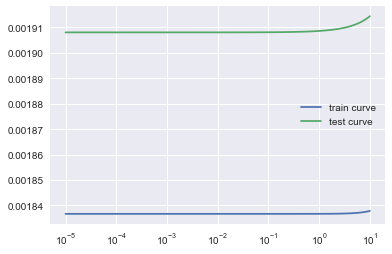

Best Ridge Constraint: 1e-05


In [83]:
# Find the best ridge hyper parameter with Grid Search
alphas = np.logspace(-5, 1, num=100)

gs = GridSearch(df, 'SalePriceLog', inverse_fn=log10_inverse_fn)
gs.run(alphas, method='Ridge')
best_ridge20_alpha = gs.best_alpha()

gs.plot_validation_curves()
print('Best Ridge Constraint:', best_ridge20_alpha)

In [84]:
# Apply Ridge Regularization with the best hyperparamter found
model = Ridge(alpha=best_ridge20_alpha)
ma_20_ridge = ModelAgent(model)
ma_20_ridge.fit_and_evaluate(df, 'SalePriceLog', inverse_fn=log10_inverse_fn)

# print model results
print_scores(ma_20_ridge)


Train Set Scores:
-----------------
RMSLE Baseline : 0.164798
MAE Baseline : 52417.16

RMSLE : 0.042857
MAE   : 11989.91
R2    : 0.9415

Test Set Scores:
----------------
RMSLE Baseline : 0.170028
MAE Baseline : 54103.79

RMSLE : 0.043681
MAE   : 12030.49
R2    : 0.94441


The ridge constraint is null, there is nothing to regularized. It is a simple `LinearRegression`.

## 7.2 Applying Lasso Regularization

Lasso regression try to minimize the L1 norm (MAE). We use grid search method to find the best lasso constraint that minimize the MAE.

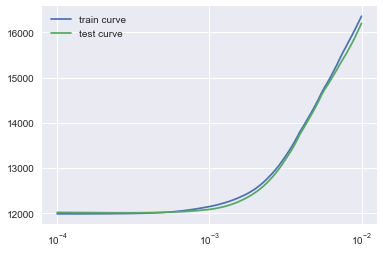

Best Lasso Constraint: 0.00026560877829466864


In [85]:
# Find the best ridge hyper parameter with Grid Search
alphas = np.logspace(-4, -2, num=100)

gs = GridSearch(df, 'SalePriceLog', inverse_fn=log10_inverse_fn)
gs.run(alphas, method='Lasso', max_iter=10000)
best_lasso20_alpha = gs.best_alpha()

gs.plot_validation_curves()
print('Best Lasso Constraint:', best_lasso20_alpha)


Train Set Scores:
-----------------
RMSLE Baseline : 0.164798
MAE Baseline : 52417.16

RMSLE : 0.042893
MAE   : 11993.83
R2    : 0.94131

Test Set Scores:
----------------
RMSLE Baseline : 0.170028
MAE Baseline : 54103.79

RMSLE : 0.043614
MAE   : 12011.56
R2    : 0.94438


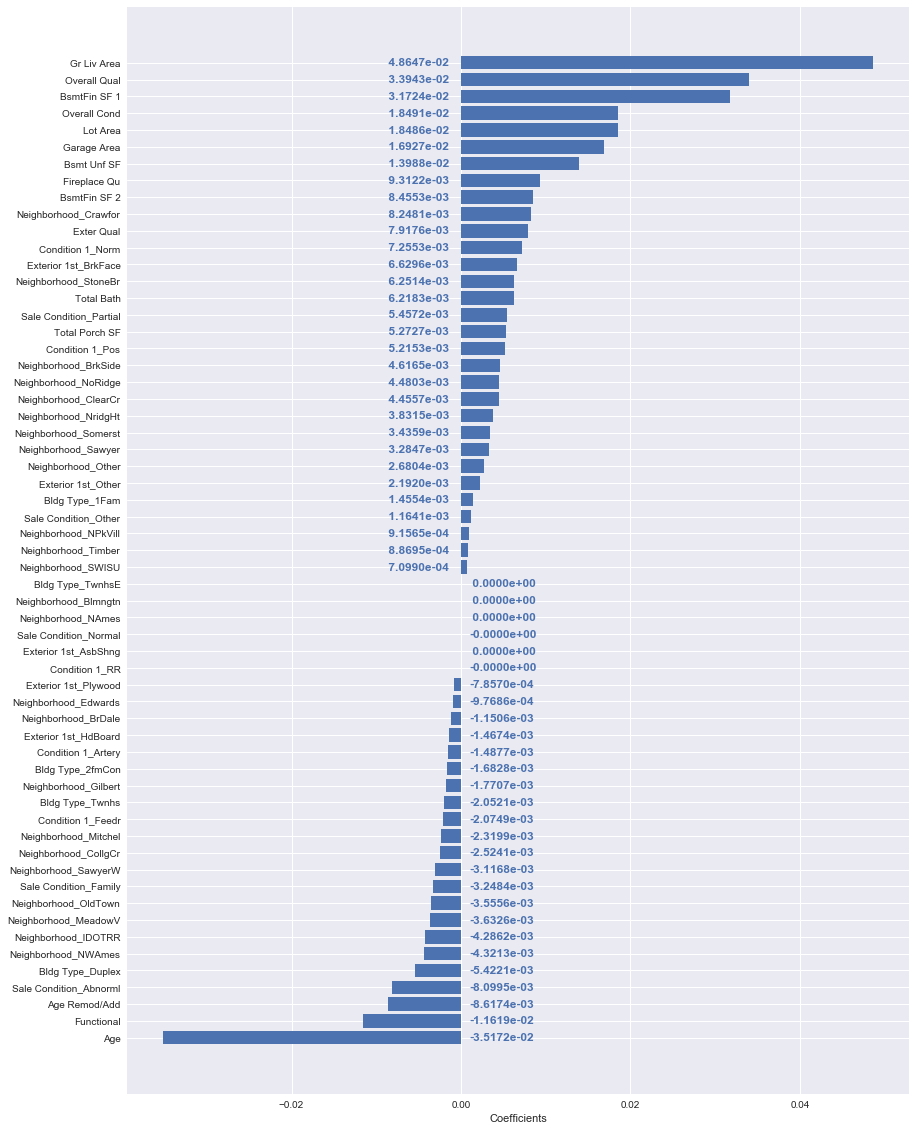

In [86]:
# Apply Lasso Regularization with the best hyperparamter found
model = Lasso(alpha=best_lasso20_alpha)
ma_20_lasso = ModelAgent(model)
ma_20_lasso.fit_and_evaluate(df, 'SalePriceLog', inverse_fn=log10_inverse_fn)

# print model results
print_scores(ma_20_lasso)
ma_20_lasso.plot_coefs(figsize=(14,20), offset=0.009)

The Lasso regularization was able to remove 6 variables from the model for a minimal negative impact on the MAE. It is not better from a MAE perspective but the model is a little bit simpler... Note that the order of coefficients have changed but the idea remains the same globally (less intuitive however).

## 7.3 Best result for the Intermediate Model (20 variables)

We obtained the best result without the need of regularization method. The Lasso model return a simpler model by removing 6 variables but with a litte worth MAE at the end and less intuite coefficients to interpret.

Here are the best results obtained:

Best Test RMSLE = 0.043681  
Best Test MAE = 11894.49

In [87]:
# Save the MAE & RMSLE for comparison later
mae_20   = 11894.49  # huber regression
rmsle_20 = 0.043681  # linear regression

# 8. Model with all variables

For this last part, the idea is to use all the variables. We will compete with the computer and see if it is able to  build a better model with minimal effort/thinking/undersanding than our 20 variables model and its EDA.

So, the idea is to keep the data as much as possible as they are in the data source. We apply basic encoding rules, we only remap categories when there are sample size/coefficient issue. We start with the same previously engineered features and remove the features that we know colinear/near colinear with other features.

### Encoding / Mapping

In [88]:
mappings = {}

# Ordinal variable mappings (nothing new here, None => 0)
mappings['Overall Qual'] = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
mappings['Overall Cond'] = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
mappings['Lot Shape']    = {'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3}
mappings['Utilities']    = {'AllPub': 0, 'NoSewr': 1, 'NoSeWa': 2, 'ELO': 3}
mappings['Land Slope']   = {'Gtl': 0, 'Mod': 1, 'Sev': 2}
mappings['Exter Qual']   = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
mappings['Exter Cond']   = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
mappings['Heating QC']   = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
mappings['Electrical']   = {'SBrkr': 0, 'FuseA': 1, 'FuseF': 2, 'FuseP': 3, 'Mix': 4}
mappings['Kitchen Qual'] = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
mappings['Functional']   = {'Typ': 0, 'Min1': 1, 'Min2': 2, 'Mod': 3, 'Maj1': 4, 'Maj2': 5, 'Sev': 6, 'Sal': 7}
mappings['Paved Drive']  = {'Y': 0, 'P': 1, 'N': 2}
mappings['Pool QC']        = {'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
mappings['Fence']          = {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
mappings['Bsmt Qual']      = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
mappings['Bsmt Cond']      = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
mappings['Bsmt Exposure']  = {'None': 0, 'No': 0, 'Mn': 1, 'Av': 2, 'Gd': 3}
mappings['BsmtFin Type 1'] = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
mappings['BsmtFin Type 2'] = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
mappings['Fireplace Qu']   = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
mappings['Garage Finish']  = {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
mappings['Garage Qual']    = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
mappings['Garage Cond']    = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}


# Nominal variable mappings (mapping required to avoid sample size/coefficient issues)
mappings['MS Zoning'] = {'A': 'Other', 'C': 'Other', 'I': 'Other',
                         'FV': 'FV', 'RH': 'RH', 'RM': 'RM', 'RL': 'RL', 'RP': 'RP'}

mappings['Neighborhood'] = {
    'Landmrk': 'Other', 'GrnHill': 'Other', 'Blueste': 'Other', 'Greens': 'Other', 'Veenker': 'Other',
    'Blmngtn': 'Blmngtn', 'NPkVill': 'NPkVill', 'BrDale': 'BrDale', 'MeadowV': 'MeadowV',
    'BrkSide': 'BrkSide', 'ClearCr': 'ClearCr', 'CollgCr': 'CollgCr',
    'Crawfor': 'Crawfor', 'Edwards': 'Edwards', 'Gilbert': 'Gilbert',
    'IDOTRR': 'IDOTRR', 'Mitchel': 'Mitchel', 'NAmes': 'NAmes', 'NoRidge': 'NoRidge', 
    'NridgHt': 'NridgHt', 'NWAmes': 'NWAmes', 'OldTown': 'OldTown',
    'SWISU': 'SWISU', 'Sawyer': 'Sawyer', 'SawyerW': 'SawyerW',
    'Somerst': 'Somerst', 'StoneBr': 'StoneBr', 'Timber': 'Timber'
}

mappings['Central Air'] = {'Y': 1, 'N': 0} 
mappings['Mas Vnr Type'] = {'BrkFace': 'BrkFace', 'Stone': 'Stone', 'BrkCmn': 'Other', 'CBlock': 'Other', 'None': 'None'}
mappings['Misc Feature'] = {'Shed': 'Shed', 'None': 'None', 'Elev': 'Other', 'Gar2': 'Other', 'Othr': 'Other',  'TenC': 'Other'}

### Data Preparation

The following variables are excluded from the start because colinear/near colinear with others variables, used to engineer other features:

* Gr Liv Area
* Total Bsmt SF
* Year Built
* Year Remod/Add
* MS SubClass (combination of year built, house style, building type etc...)
* Garage Cond
* Garage Cars
* Garage Yr Blt
* TotRms AbvGrd

The following transformations are applied:

* Lot Area : log10

Other:

* The `Mo Sold` variable is one hot encoded (periodic behaviour)
* `Central Air` as an indicator variable

In [89]:
# variables used to build the model
vars = [
    
    Variable('SalePriceLog', VariableType.CONTINUOUS),
    
    # NOT USED VARIABLES: linear combinaison of other features
    #Variable('Gr Liv Area', VariableType.CONTINUOUS),
    #Variable('Total Bsmt SF', VariableType.CONTINUOUS), 
    #Variable('Year Built', VariableType.DISCRETE),
    #Variable('Year Remod/Add', VariableType.DISCRETE),
    
    # NOT USED VARIABLES: colinearity with other variable discovered from the correlation matrix analysis
    #Variable('Garage Cond', VariableType.ORDINAL, mappings['Garage Cond']), 
    #Variable('Garage Cars', VariableType.DISCRETE),
    #Variable('Garage Yr Blt', VariableType.DISCRETE), 
    #Variable('TotRms AbvGrd', VariableType.DISCRETE),
    #Variable('MS SubClass', VariableType.NOMINAL),
    
    
    # --------------------
    # Continuous variables
    # --------------------
    Variable('Lot Area', VariableType.CONTINUOUS, fn=np.log10),
    Variable('Mas Vnr Area', VariableType.CONTINUOUS),
    Variable('BsmtFin SF 1', VariableType.CONTINUOUS),
    Variable('BsmtFin SF 2', VariableType.CONTINUOUS),
    Variable('Bsmt Unf SF', VariableType.CONTINUOUS),
    Variable('1st Flr SF', VariableType.CONTINUOUS),
    Variable('2nd Flr SF', VariableType.CONTINUOUS),
    Variable('Low Qual Fin SF', VariableType.CONTINUOUS),
    Variable('Garage Area', VariableType.CONTINUOUS),
    Variable('Wood Deck SF', VariableType.CONTINUOUS), 
    Variable('Open Porch SF', VariableType.CONTINUOUS),
    Variable('Enclosed Porch', VariableType.CONTINUOUS),
    Variable('Screen Porch', VariableType.CONTINUOUS),
    
    # SPOIL: Continuous variables that will be eliminated by a first Lasso model
    Variable('3Ssn Porch', VariableType.CONTINUOUS),
    Variable('Lot Frontage', VariableType.CONTINUOUS),
    Variable('Misc Val', VariableType.CONTINUOUS), 
    Variable('Pool Area', VariableType.CONTINUOUS),
    
    
    
    # ------------------
    # Discrete variables
    # ------------------
    Variable('Age', VariableType.DISCRETE),
    Variable('Age Remod/Add', VariableType.DISCRETE),
    Variable('Mo Sold', VariableType.NOMINAL),  # Month Sold as Nominal Variable (periodic behaviour)
    Variable('Bsmt Full Bath', VariableType.DISCRETE),
    Variable('Full Bath', VariableType.DISCRETE),
    Variable('Half Bath', VariableType.DISCRETE),
    Variable('Fireplaces', VariableType.DISCRETE),
    Variable('Kitchen AbvGr', VariableType.DISCRETE),
    
    # SPOIL: Discrete variables that will be eliminated by a first Lasso model
    Variable('Bedroom AbvGr', VariableType.DISCRETE),
    Variable('Bsmt Half Bath', VariableType.DISCRETE),
    Variable('Yr Sold', VariableType.DISCRETE),
     
    
    
    # -----------------
    # Ordinal variables
    # -----------------
    Variable('Utilities', VariableType.ORDINAL, mappings['Utilities']), 
    Variable('Land Slope', VariableType.ORDINAL, mappings['Land Slope']), 
    Variable('Overall Qual', VariableType.ORDINAL, mappings['Overall Qual']), 
    Variable('Overall Cond', VariableType.ORDINAL, mappings['Overall Cond']), 
    Variable('Exter Qual', VariableType.ORDINAL, mappings['Exter Qual']), 
    Variable('Bsmt Qual', VariableType.ORDINAL, mappings['Bsmt Qual']), 
    Variable('Bsmt Cond', VariableType.ORDINAL, mappings['Bsmt Cond']), 
    Variable('Bsmt Exposure', VariableType.ORDINAL, mappings['Bsmt Exposure']), 
    Variable('BsmtFin Type 1', VariableType.ORDINAL, mappings['BsmtFin Type 1']), 
    Variable('Heating QC', VariableType.ORDINAL, mappings['Heating QC']), 
    Variable('Electrical', VariableType.ORDINAL, mappings['Electrical']), 
    Variable('Kitchen Qual', VariableType.ORDINAL, mappings['Kitchen Qual']), 
    Variable('Functional', VariableType.ORDINAL, mappings['Functional']), 
    Variable('Fireplace Qu', VariableType.ORDINAL, mappings['Fireplace Qu']), 
    Variable('Garage Qual', VariableType.ORDINAL, mappings['Garage Qual']), 
    Variable('Paved Drive', VariableType.ORDINAL, mappings['Paved Drive']), 
    Variable('Pool QC', VariableType.ORDINAL, mappings['Pool QC']), 
    
    # SPOIL: Ordinal variables that will be eliminated by a first Lasso model
    Variable('BsmtFin Type 2', VariableType.ORDINAL, mappings['BsmtFin Type 2']), 
    Variable('Exter Cond', VariableType.ORDINAL, mappings['Exter Cond']), 
    Variable('Fence', VariableType.ORDINAL, mappings['Fence']),
    Variable('Garage Finish', VariableType.ORDINAL, mappings['Garage Finish']),
    Variable('Lot Shape', VariableType.ORDINAL, mappings['Lot Shape']), 
    
    
    
    # ------------------
    # Nominal variables
    # ------------------
    Variable('MS Zoning', VariableType.NOMINAL, mapping=mappings['MS Zoning']), 
    Variable('Land Contour', VariableType.NOMINAL),
    Variable('Lot Config', VariableType.NOMINAL), 
    Variable('Neighborhood', VariableType.NOMINAL, mapping=mappings['Neighborhood']),
    Variable('Condition 1', VariableType.NOMINAL), 
    Variable('Condition 2', VariableType.NOMINAL), 
    Variable('Bldg Type', VariableType.NOMINAL),
    Variable('House Style', VariableType.NOMINAL),
    Variable('Roof Style', VariableType.NOMINAL), 
    Variable('Exterior 1st', VariableType.NOMINAL),
    Variable('Exterior 2nd', VariableType.NOMINAL),
    Variable('Mas Vnr Type', VariableType.NOMINAL, mapping=mappings['Mas Vnr Type']), 
    Variable('Foundation', VariableType.NOMINAL), 
    Variable('Heating', VariableType.NOMINAL), 
    Variable('Central Air', VariableType.ORDINAL, mapping=mappings['Central Air']), 
    Variable('Garage Type', VariableType.NOMINAL),
    Variable('Misc Feature', VariableType.NOMINAL, mapping=mappings['Misc Feature']), 
    Variable('Sale Condition', VariableType.NOMINAL), 
    Variable('Roof Matl', VariableType.NOMINAL),
    
    # SPOIL: Nominal variables that will be eliminated by a first Lasso model
    Variable('Alley', VariableType.NOMINAL),
    Variable('Sale Type', VariableType.NOMINAL),
    Variable('Street', VariableType.NOMINAL),  
]

### Model with all the variables


Train Set Scores:
-----------------
RMSLE Baseline : 0.164798
MAE Baseline : 52417.16

RMSLE : 0.039087
MAE   : 10624.73
R2    : 0.95407

Test Set Scores:
----------------
RMSLE Baseline : 0.170028
MAE Baseline : 54103.79

RMSLE : 0.045802
MAE   : 12411.04
R2    : 0.94126


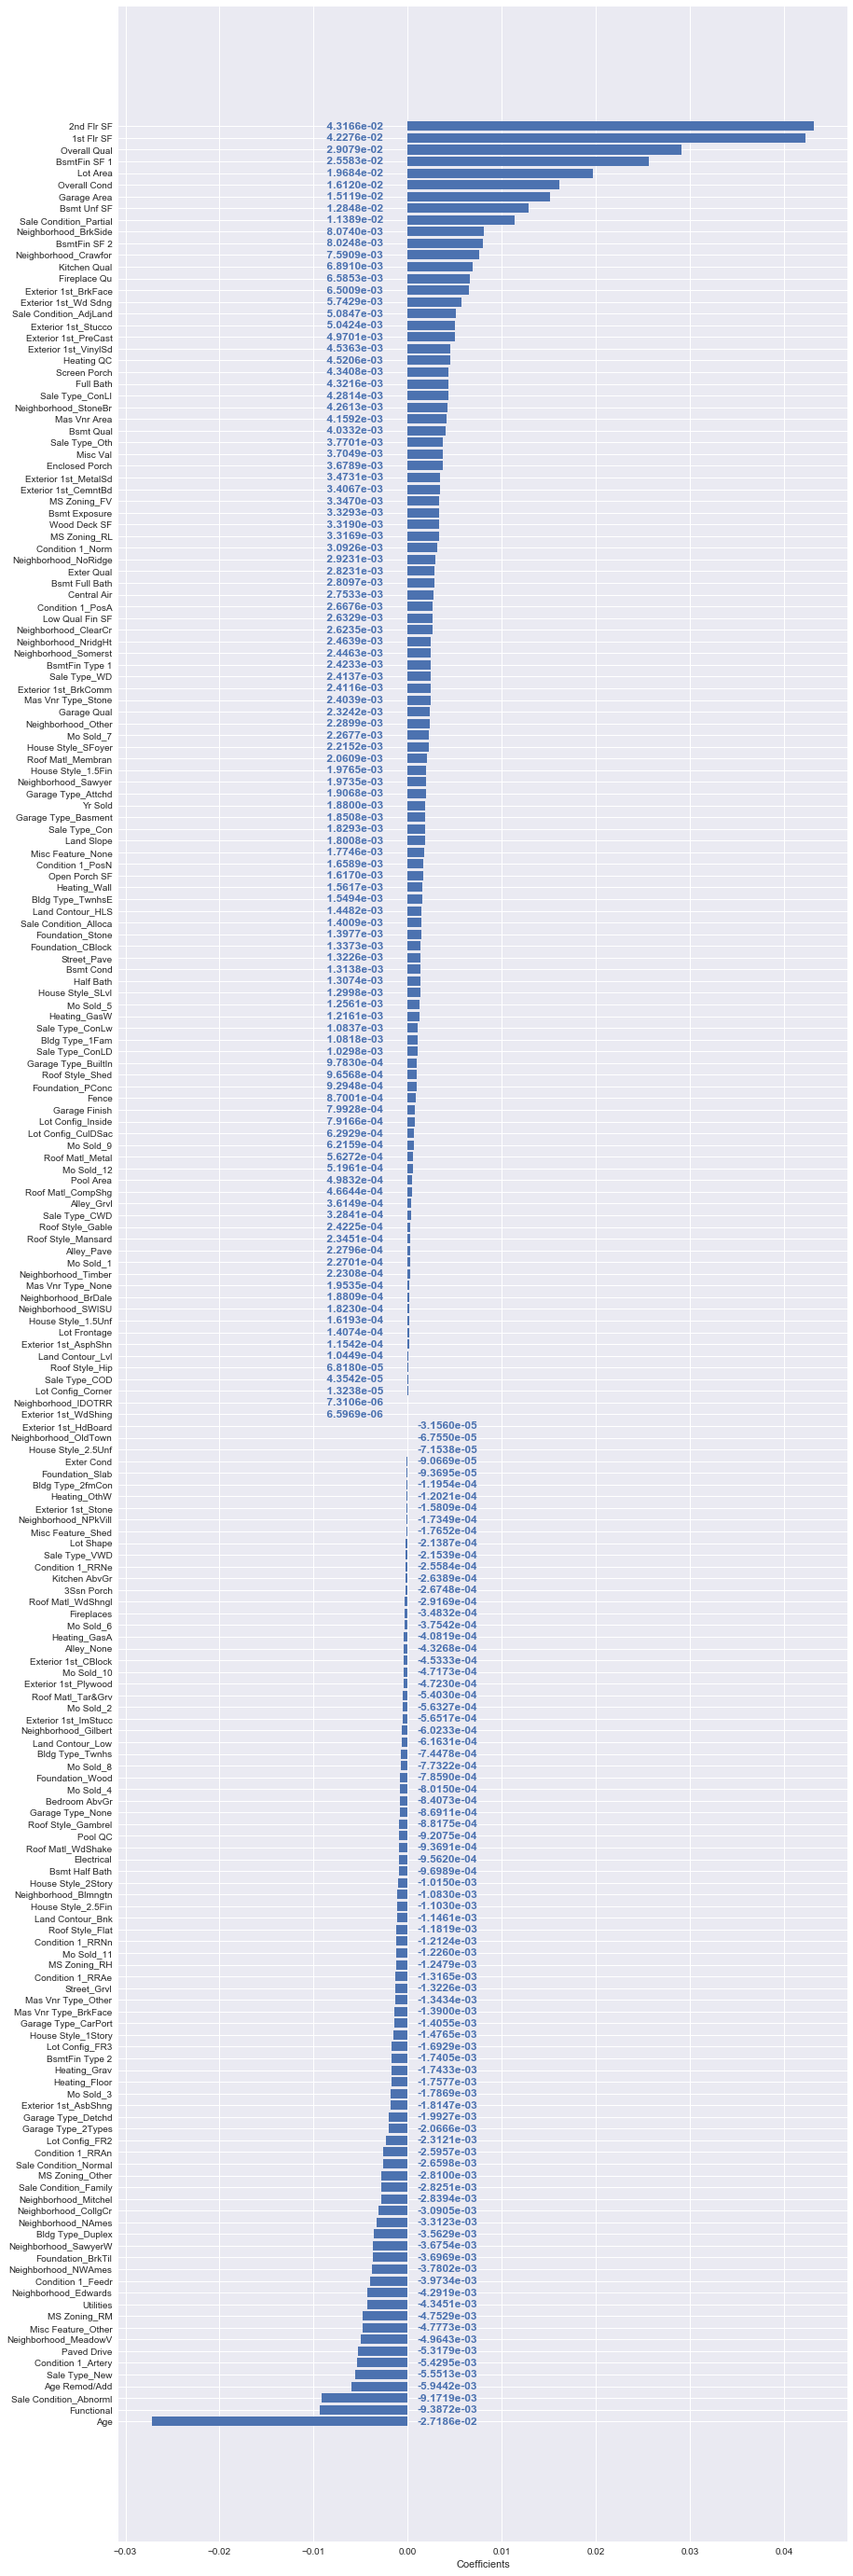

In [90]:
USE_LINEAR_REGRESSION_MODEL = False

# prepare the data
mdfb = ModelDataFrameBuilder()
mdfb.prepare(data, vars)

# Merge nominal variables (Condition & Exterior)
mdfb.merge_dummy_variables('Condition 1', 'Condition 2')
mdfb.merge_dummy_variables('Exterior 1st', 'Exterior 2nd')

# Normalize the data
if not USE_LINEAR_REGRESSION_MODEL:
    mdfb.normalize(exclude=['SalePriceLog'])

# Get the prepared data
df = mdfb.data()

# build the model
if not USE_LINEAR_REGRESSION_MODEL:
    model = HuberRegressor(epsilon=1.9)
else:
    model = LinearRegression()

ma_all = ModelAgent(model)
ma_all.fit_and_evaluate(df, 'SalePriceLog', inverse_fn=log10_inverse_fn)

# print model results
print_scores(ma_all)
if not USE_LINEAR_REGRESSION_MODEL:
    ma_all.plot_coefs(figsize=(14,50), offset=0.009)

Results by using a `LinearRegression()` model:

**Train Set Scores:**

RMSLE Baseline : 0.164798  
MAE Baseline : 52417.16  

RMSLE : 0.038368  
MAE   : 10812.69  
R2    : 0.95519  

**Test Set Scores:**

RMSLE Baseline : 0.170028  
MAE Baseline : 54103.79  

RMSLE : 0.046904   
MAE   : 12753.83  
R2    : 0.93793  

In [91]:
# Save the MAE & RMSLE for comparison later
mae_all  = 12411.04  # huber regression
rmsle_all = 0.046904  # linear regression

Even if we can see that a lot of variables are not strong predictors and the apparent complexity of the model, it's definitively a very good result in regards of the amount of effort done to obtain it. 

One interesting thing to do now is applying Lasso regularization to reduce the number of dimensions. We will also try to rebuild a new model without the variables that our Lasso model will discard and reapply on it Lasso regularization to try to compress even more the number of dimensions and have only the more interesting features...

But before, we will quickly apply Ridge regularization to have a complete L2 norm comparison bar chart.

## 8.1 Ridge Regularization

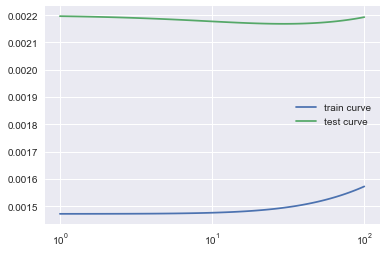

Best Ridge Constraint: 29.836472402833405


In [92]:
# Find the best ridge hyper parameter with Grid Search
alphas = np.logspace(0, 2, num=100)

gs = GridSearch(df, 'SalePriceLog', inverse_fn=log10_inverse_fn)
gs.run(alphas, method='Ridge')
best_ridge_all_alpha = gs.best_alpha()

gs.plot_validation_curves()
print('Best Ridge Constraint:', best_ridge_all_alpha)

In [93]:
# Apply Ridge Regularization with the best hyperparameter found
model = Ridge(alpha=best_ridge_all_alpha)
ma_all_ridge = ModelAgent(model)
ma_all_ridge.fit_and_evaluate(df, 'SalePriceLog', inverse_fn=log10_inverse_fn)

# print model results
print_scores(ma_all_ridge)


Train Set Scores:
-----------------
RMSLE Baseline : 0.164798
MAE Baseline : 52417.16

RMSLE : 0.038664
MAE   : 10974.89
R2    : 0.95505

Test Set Scores:
----------------
RMSLE Baseline : 0.170028
MAE Baseline : 54103.79

RMSLE : 0.046564
MAE   : 12723.19
R2    : 0.93883


**We can see that applying ridge regularization improve the test RMSLE.**

In [94]:
# Save the RMSLE for comparison later
rmsle_all_ridge = 0.046564  # ridge regression

## 8.2 Lasso Regularization | Itération 1

Bacause Lasso regularization can discard variables, it has the power to really simplify our rough model:

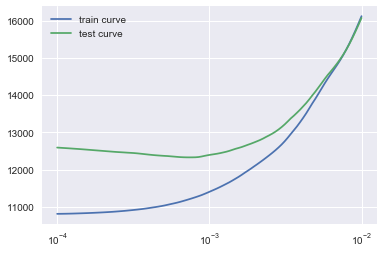

Best Lasso Constraint: 0.0007390722033525775


In [95]:
# Find the best ridge hyper parameter with Grid Search
alphas = np.logspace(-4, -2, num=100)

gs = GridSearch(df, 'SalePriceLog', inverse_fn=log10_inverse_fn)
gs.run(alphas, method='Lasso', max_iter=10000)
best_lasso_all_alpha = gs.best_alpha()

gs.plot_validation_curves()
print('Best Lasso Constraint:', best_lasso_all_alpha)


Train Set Scores:
-----------------
RMSLE Baseline : 0.164798
MAE Baseline : 52417.16

RMSLE : 0.039645
MAE   : 11204.67
R2    : 0.95231

Test Set Scores:
----------------
RMSLE Baseline : 0.170028
MAE Baseline : 54103.79

RMSLE : 0.044702
MAE   : 12326.95
R2    : 0.94172


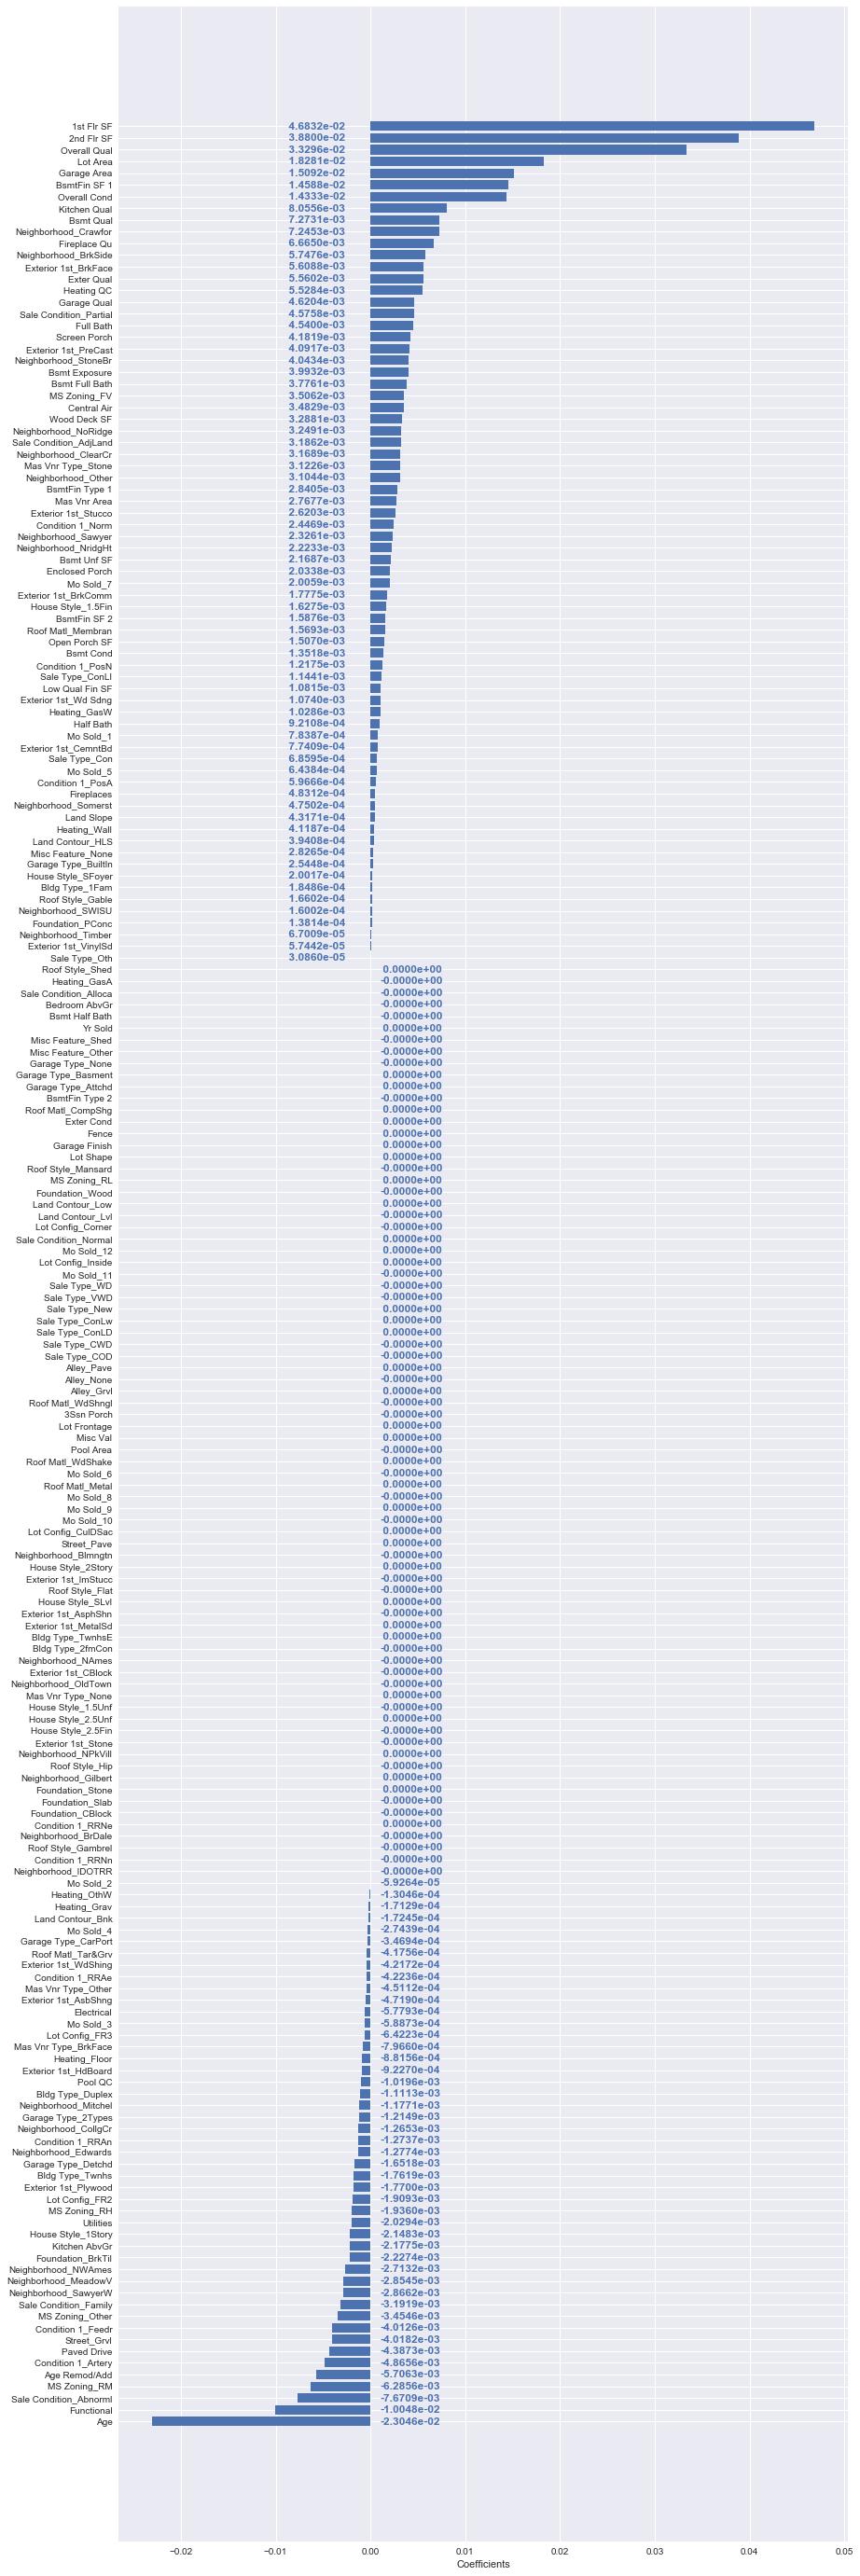

In [96]:
# Apply Lasso Regularization with the best hyperparameter found
model = Lasso(alpha=best_lasso_all_alpha)
ma_all_lasso = ModelAgent(model)
ma_all_lasso.fit_and_evaluate(df, 'SalePriceLog', inverse_fn=log10_inverse_fn)

# print model results
print_scores(ma_all_lasso)
ma_all_lasso.plot_coefs(figsize=(14,50), offset=0.009)

As we can see a lot of variables have been discarded by the algorithm. The test MAE has been improved and the model is simpler. Amazing numerical method !

In [97]:
# Save the MAE for comparison later
mae_all_lasso = 12326.95  # lasso regularization

Here is the list of all variables that have been discarded by the Lasso Regression:

In [98]:
# Show the variables with nullified coefficients
pd.set_option("display.max_rows",101)
df_coefs = ma_all_lasso.coefs()
df_coefs.loc[df_coefs['coef'] == 0, ['label']].sort_values('label')

label
86              3Ssn Porch
88              Alley_Grvl
89              Alley_None
90              Alley_Pave
121          Bedroom AbvGr
66        Bldg Type_2fmCon
67        Bldg Type_TwnhsE
120         Bsmt Half Bath
113         BsmtFin Type 2
51        Condition 1_RRNe
48        Condition 1_RRNn
111             Exter Cond
69    Exterior 1st_AsphShn
64     Exterior 1st_CBlock
72    Exterior 1st_ImStucc
68    Exterior 1st_MetalSd
58      Exterior 1st_Stone
110                  Fence
52       Foundation_CBlock
53         Foundation_Slab
54        Foundation_Stone
105        Foundation_Wood
109          Garage Finish
114     Garage Type_Attchd
115    Garage Type_Basment
116       Garage Type_None
123           Heating_GasA
61      House Style_1.5Unf
59      House Style_2.5Fin
60      House Style_2.5Unf
73      House Style_2Story
70        House Style_SLvl
104       Land Contour_Low
103       Land Contour_Lvl
102      Lot Config_Corner
76      Lot Config_CulDSac
99       Lot Config_Inside
85            Lot Frontage
108              Lot Shape
106           MS Zoning_RL
62       Mas Vnr Type_None
117     Misc Feature_Other
118      Misc Feature_Shed
84                Misc Val
77              Mo Sold_10
98              Mo Sold_11
100             Mo Sold_12
81               Mo Sold_6
79               Mo Sold_8
78               Mo Sold_9
74    Neighborhood_Blmngtn
50     Neighborhood_BrDale
55    Neighborhood_Gilbert
47     Neighborhood_IDOTRR
65      Neighborhood_NAmes
57    Neighborhood_NPkVill
63    Neighborhood_OldTown
83               Pool Area
112      Roof Matl_CompShg
80         Roof Matl_Metal
82       Roof Matl_WdShake
87       Roof Matl_WdShngl
71         Roof Style_Flat
49      Roof Style_Gambrel
56          Roof Style_Hip
107     Roof Style_Mansard
124        Roof Style_Shed
122  Sale Condition_Alloca
101  Sale Condition_Normal
91           Sale Type_COD
92           Sale Type_CWD
93         Sale Type_ConLD
94         Sale Type_ConLw
95           Sale Type_New
96           Sale Type_VWD
97            Sale Type_WD
75             Street_Pave
119                Yr Sold

There are a lot of dummy variables in the list but also some continuous, discrete and ordinal variables.  
What if we rebuild a models without them from the start ? Let's try for curiosity

## 8.3 Curiosity: Model improvement | Remove Lasso Discarded Variables

Here, we copy the same data preparation from the previous section and comment the variables that have been discarded by our Lasso model during the first iteration:

In [99]:
# variables used to build the model
vars = [
    
    Variable('SalePriceLog', VariableType.CONTINUOUS),
    
    # NOT USED VARIABLES: linear combinaison of other features
    #Variable('Gr Liv Area', VariableType.CONTINUOUS),
    #Variable('Total Bsmt SF', VariableType.CONTINUOUS), 
    #Variable('Year Built', VariableType.DISCRETE),
    #Variable('Year Remod/Add', VariableType.DISCRETE),
    
    # NOT USED VARIABLES: colinearity with other variable discovered from the correlation matrix analysis
    #Variable('Garage Cond', VariableType.ORDINAL, mappings['Garage Cond']), 
    #Variable('Garage Cars', VariableType.DISCRETE),
    #Variable('Garage Yr Blt', VariableType.DISCRETE), 
    #Variable('TotRms AbvGrd', VariableType.DISCRETE),
    #Variable('MS SubClass', VariableType.NOMINAL),
    
    # ----------------------------------
    # DISCARDED BY LASSO FIRST ITERATION
    # ----------------------------------
    #Variable('3Ssn Porch', VariableType.CONTINUOUS),
    #Variable('Lot Frontage', VariableType.CONTINUOUS),
    #Variable('Misc Val', VariableType.CONTINUOUS), 
    #Variable('Pool Area', VariableType.CONTINUOUS),
    #Variable('Bedroom AbvGr', VariableType.DISCRETE),
    #Variable('Bsmt Half Bath', VariableType.DISCRETE),
    #Variable('Yr Sold', VariableType.DISCRETE),
    #Variable('BsmtFin Type 2', VariableType.ORDINAL, mappings['BsmtFin Type 2']), 
    #Variable('Exter Cond', VariableType.ORDINAL, mappings['Exter Cond']), 
    #Variable('Fence', VariableType.ORDINAL, mappings['Fence']),
    #Variable('Garage Finish', VariableType.ORDINAL, mappings['Garage Finish']),
    #Variable('Lot Shape', VariableType.ORDINAL, mappings['Lot Shape']), 
    #Variable('Alley', VariableType.NOMINAL),
    #Variable('Sale Type', VariableType.NOMINAL),
    #Variable('Street', VariableType.NOMINAL), 
    
    
    # --------------------
    # Continuous variables
    # --------------------
    Variable('Lot Area', VariableType.CONTINUOUS, fn=np.log10),
    Variable('Mas Vnr Area', VariableType.CONTINUOUS),
    Variable('BsmtFin SF 1', VariableType.CONTINUOUS),
    Variable('BsmtFin SF 2', VariableType.CONTINUOUS),
    Variable('Bsmt Unf SF', VariableType.CONTINUOUS),
    Variable('1st Flr SF', VariableType.CONTINUOUS),
    Variable('2nd Flr SF', VariableType.CONTINUOUS),
    Variable('Low Qual Fin SF', VariableType.CONTINUOUS),
    Variable('Garage Area', VariableType.CONTINUOUS),
    Variable('Wood Deck SF', VariableType.CONTINUOUS), 
    Variable('Open Porch SF', VariableType.CONTINUOUS),
    Variable('Enclosed Porch', VariableType.CONTINUOUS),
    Variable('Screen Porch', VariableType.CONTINUOUS),
    
    # ------------------
    # Discrete variables
    # ------------------
    Variable('Age', VariableType.DISCRETE),
    Variable('Age Remod/Add', VariableType.DISCRETE),
    Variable('Mo Sold', VariableType.NOMINAL),  # Month Sold as Nominal Variable (periodic behaviour)
    Variable('Bsmt Full Bath', VariableType.DISCRETE),
    Variable('Full Bath', VariableType.DISCRETE),
    Variable('Half Bath', VariableType.DISCRETE),
    Variable('Fireplaces', VariableType.DISCRETE),
    Variable('Kitchen AbvGr', VariableType.DISCRETE),
    
    # -----------------
    # Ordinal variables
    # -----------------
    Variable('Utilities', VariableType.ORDINAL, mappings['Utilities']), 
    Variable('Land Slope', VariableType.ORDINAL, mappings['Land Slope']), 
    Variable('Overall Qual', VariableType.ORDINAL, mappings['Overall Qual']), 
    Variable('Overall Cond', VariableType.ORDINAL, mappings['Overall Cond']), 
    Variable('Exter Qual', VariableType.ORDINAL, mappings['Exter Qual']), 
    Variable('Bsmt Qual', VariableType.ORDINAL, mappings['Bsmt Qual']), 
    Variable('Bsmt Cond', VariableType.ORDINAL, mappings['Bsmt Cond']), 
    Variable('Bsmt Exposure', VariableType.ORDINAL, mappings['Bsmt Exposure']), 
    Variable('BsmtFin Type 1', VariableType.ORDINAL, mappings['BsmtFin Type 1']), 
    Variable('Heating QC', VariableType.ORDINAL, mappings['Heating QC']), 
    Variable('Electrical', VariableType.ORDINAL, mappings['Electrical']), 
    Variable('Kitchen Qual', VariableType.ORDINAL, mappings['Kitchen Qual']), 
    Variable('Functional', VariableType.ORDINAL, mappings['Functional']), 
    Variable('Fireplace Qu', VariableType.ORDINAL, mappings['Fireplace Qu']), 
    Variable('Garage Qual', VariableType.ORDINAL, mappings['Garage Qual']), 
    Variable('Paved Drive', VariableType.ORDINAL, mappings['Paved Drive']), 
    Variable('Pool QC', VariableType.ORDINAL, mappings['Pool QC']),     
    
    # ------------------
    # Nominal variables
    # ------------------
    Variable('MS Zoning', VariableType.NOMINAL, mapping=mappings['MS Zoning']), 
    Variable('Land Contour', VariableType.NOMINAL),
    Variable('Lot Config', VariableType.NOMINAL), 
    Variable('Neighborhood', VariableType.NOMINAL, mapping=mappings['Neighborhood']),
    Variable('Condition 1', VariableType.NOMINAL), 
    Variable('Condition 2', VariableType.NOMINAL), 
    Variable('Bldg Type', VariableType.NOMINAL),
    Variable('House Style', VariableType.NOMINAL),
    Variable('Roof Style', VariableType.NOMINAL), 
    Variable('Exterior 1st', VariableType.NOMINAL),
    Variable('Exterior 2nd', VariableType.NOMINAL),
    Variable('Mas Vnr Type', VariableType.NOMINAL, mapping=mappings['Mas Vnr Type']), 
    Variable('Foundation', VariableType.NOMINAL), 
    Variable('Heating', VariableType.NOMINAL), 
    Variable('Central Air', VariableType.ORDINAL, mapping=mappings['Central Air']), 
    Variable('Garage Type', VariableType.NOMINAL),
    Variable('Misc Feature', VariableType.NOMINAL, mapping=mappings['Misc Feature']), 
    Variable('Sale Condition', VariableType.NOMINAL), 
    Variable('Roof Matl', VariableType.NOMINAL), 
]


Train Set Scores:
-----------------
RMSLE Baseline : 0.164798
MAE Baseline : 52417.16

RMSLE : 0.039355
MAE   : 10748.82
R2    : 0.95367

Test Set Scores:
----------------
RMSLE Baseline : 0.170028
MAE Baseline : 54103.79

RMSLE : 0.044601
MAE   : 12212.01
R2    : 0.94421


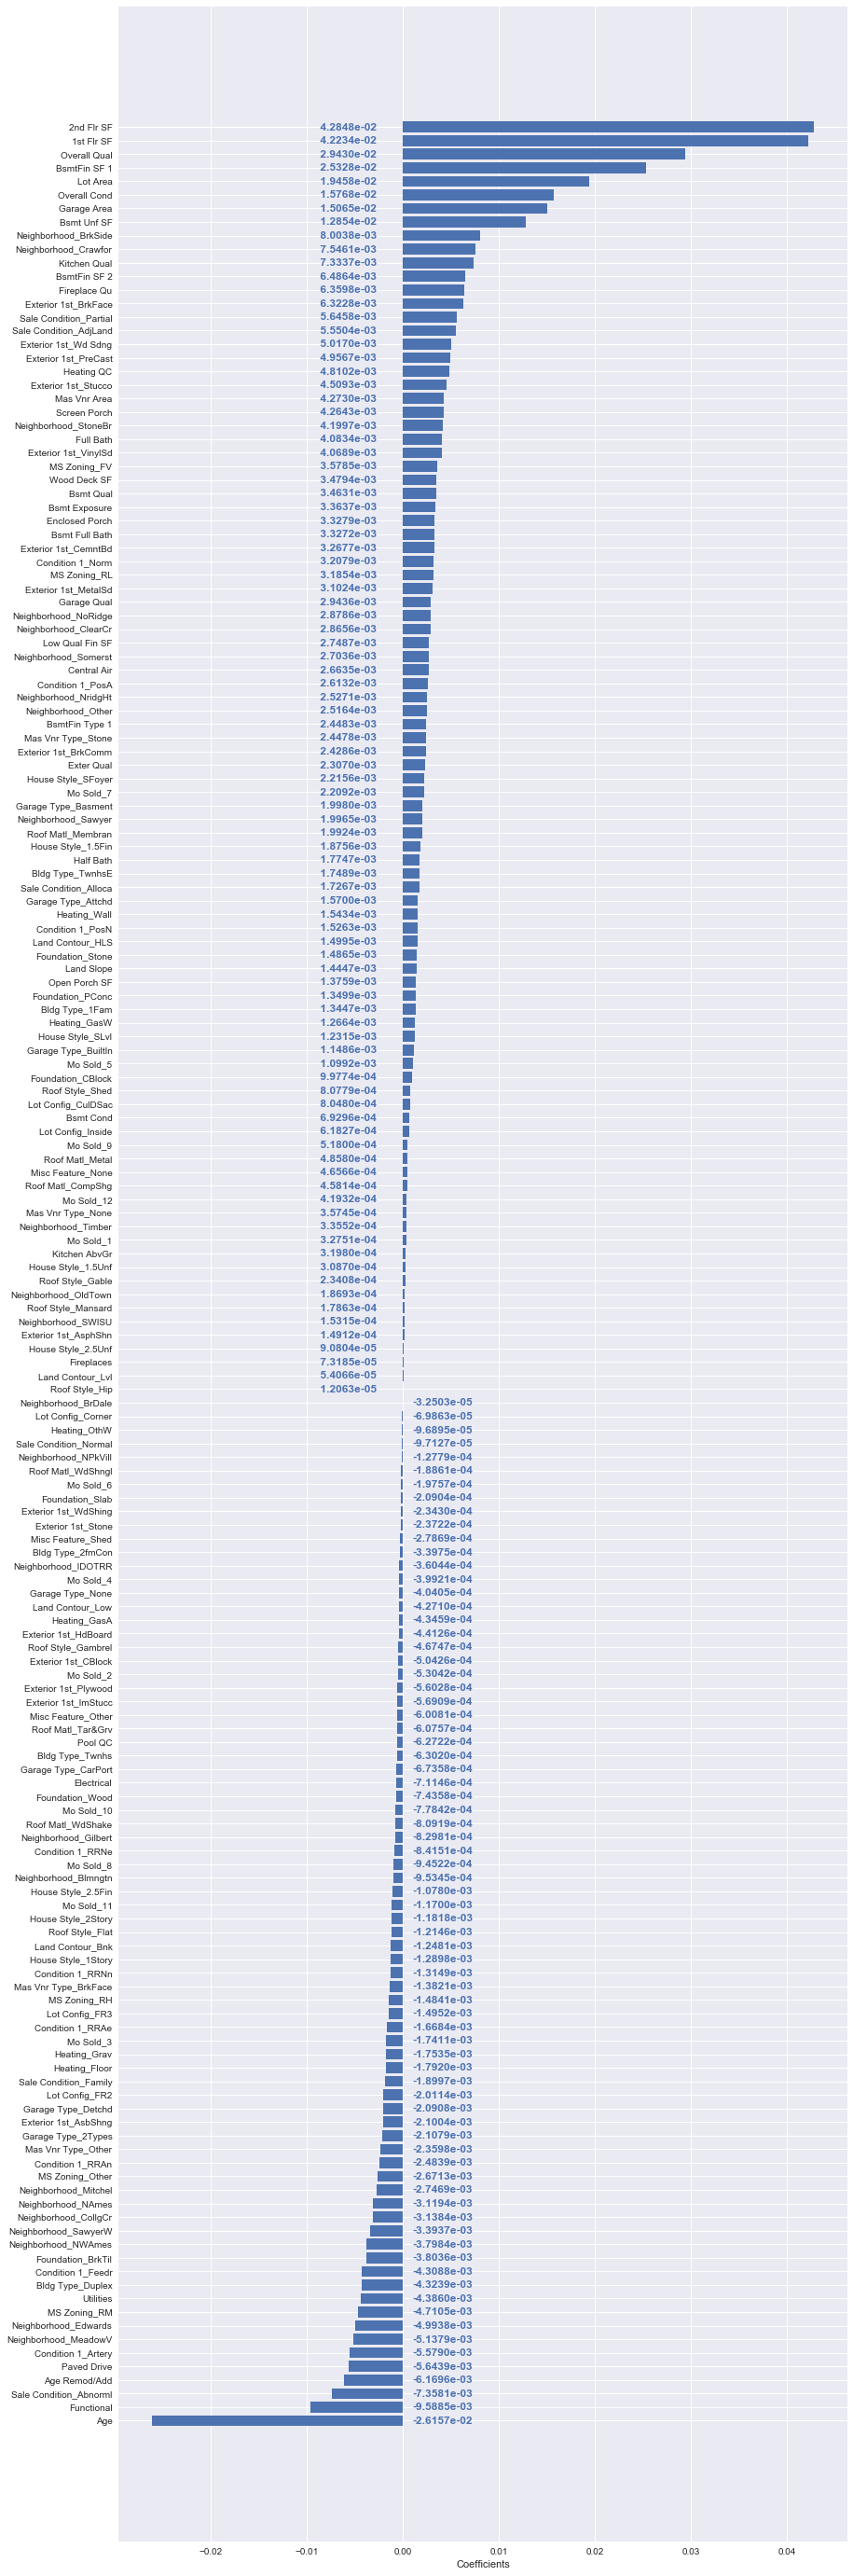

In [100]:
USE_LINEAR_REGRESSION_MODEL = False

# prepare the data
mdfb = ModelDataFrameBuilder()
mdfb.prepare(data, vars)

# Merge nominal variables (Condition & Exterior)
mdfb.merge_dummy_variables('Condition 1', 'Condition 2')
mdfb.merge_dummy_variables('Exterior 1st', 'Exterior 2nd')

# Normalize the data
if not USE_LINEAR_REGRESSION_MODEL:
    mdfb.normalize(exclude=['SalePriceLog'])

# Get the prepared data
df = mdfb.data()

# build the model
if not USE_LINEAR_REGRESSION_MODEL:
    model = HuberRegressor(epsilon=1.9)
else:
    model = LinearRegression()

ma_all = ModelAgent(model)
ma_all.fit_and_evaluate(df, 'SalePriceLog', inverse_fn=log10_inverse_fn)

# print model results
print_scores(ma_all)
if not USE_LINEAR_REGRESSION_MODEL:
    ma_all.plot_coefs(figsize=(14,50), offset=0.009)

Result by using a `LinearRegression` model:  

**Train Set Scores:**

RMSLE Baseline : 0.164798  
MAE Baseline : 52417.16  

RMSLE : 0.038838  
MAE   : 10928.35  
R2    : 0.95458  

**Test Set Scores:**

RMSLE Baseline : 0.170028  
MAE Baseline : 54103.79  

RMSLE : 0.045394  
MAE   : 12487.12  
R2    : 0.94222  

By removing the variables discarded by our first Lasso model, we have improve both the test MAE & RMSLE and greatly simplified the model. It's definitively an impressive result because all the steps done here could have been done by a computer wihtout any help of a human. It is evident that machine learning algorithm will build machine learning models without any or very few help coming from humans (for tabular data at least). I have doubt about the future of data scientist jobs (for simplest and most common needs), I predict that it will become a business analyst specialisation for most people (model understanding principle + Q&A). Only the highly skilled PhD researcher will continue to work on pure data sciences/AI (big companies/campus). It was not the subject but... :)

Note: I can't imagine what a clever algorithm and better data preparation could achieve

In [101]:
# Save the MAE & RMSLE for comparison later
mae_all_improved   = 12212.01  # huber regression
rmsle_all_improved = 0.045394  # linear regression

### Lasso regularization | Second iteration

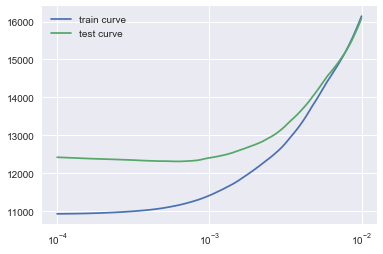

Best Lasso Constraint: 0.0006135907273413176


In [102]:
# Find the best ridge hyper parameter with Grid Search
alphas = np.logspace(-4, -2, num=100)

gs = GridSearch(df, 'SalePriceLog', inverse_fn=log10_inverse_fn)
gs.run(alphas, method='Lasso', max_iter=10000)
best_lasso_all_alpha = gs.best_alpha()

gs.plot_validation_curves()
print('Best Lasso Constraint:', best_lasso_all_alpha)

In [103]:
model = Lasso(alpha=best_lasso_all_alpha)
ma_all_lasso = ModelAgent(model)
ma_all_lasso.fit_and_evaluate(df, 'SalePriceLog', inverse_fn=log10_inverse_fn)

# print model results
print_scores(ma_all_lasso)


Train Set Scores:
-----------------
RMSLE Baseline : 0.164798
MAE Baseline : 52417.16

RMSLE : 0.0396
MAE   : 11150.28
R2    : 0.95283

Test Set Scores:
----------------
RMSLE Baseline : 0.170028
MAE Baseline : 54103.79

RMSLE : 0.044522
MAE   : 12312.26
R2    : 0.9421


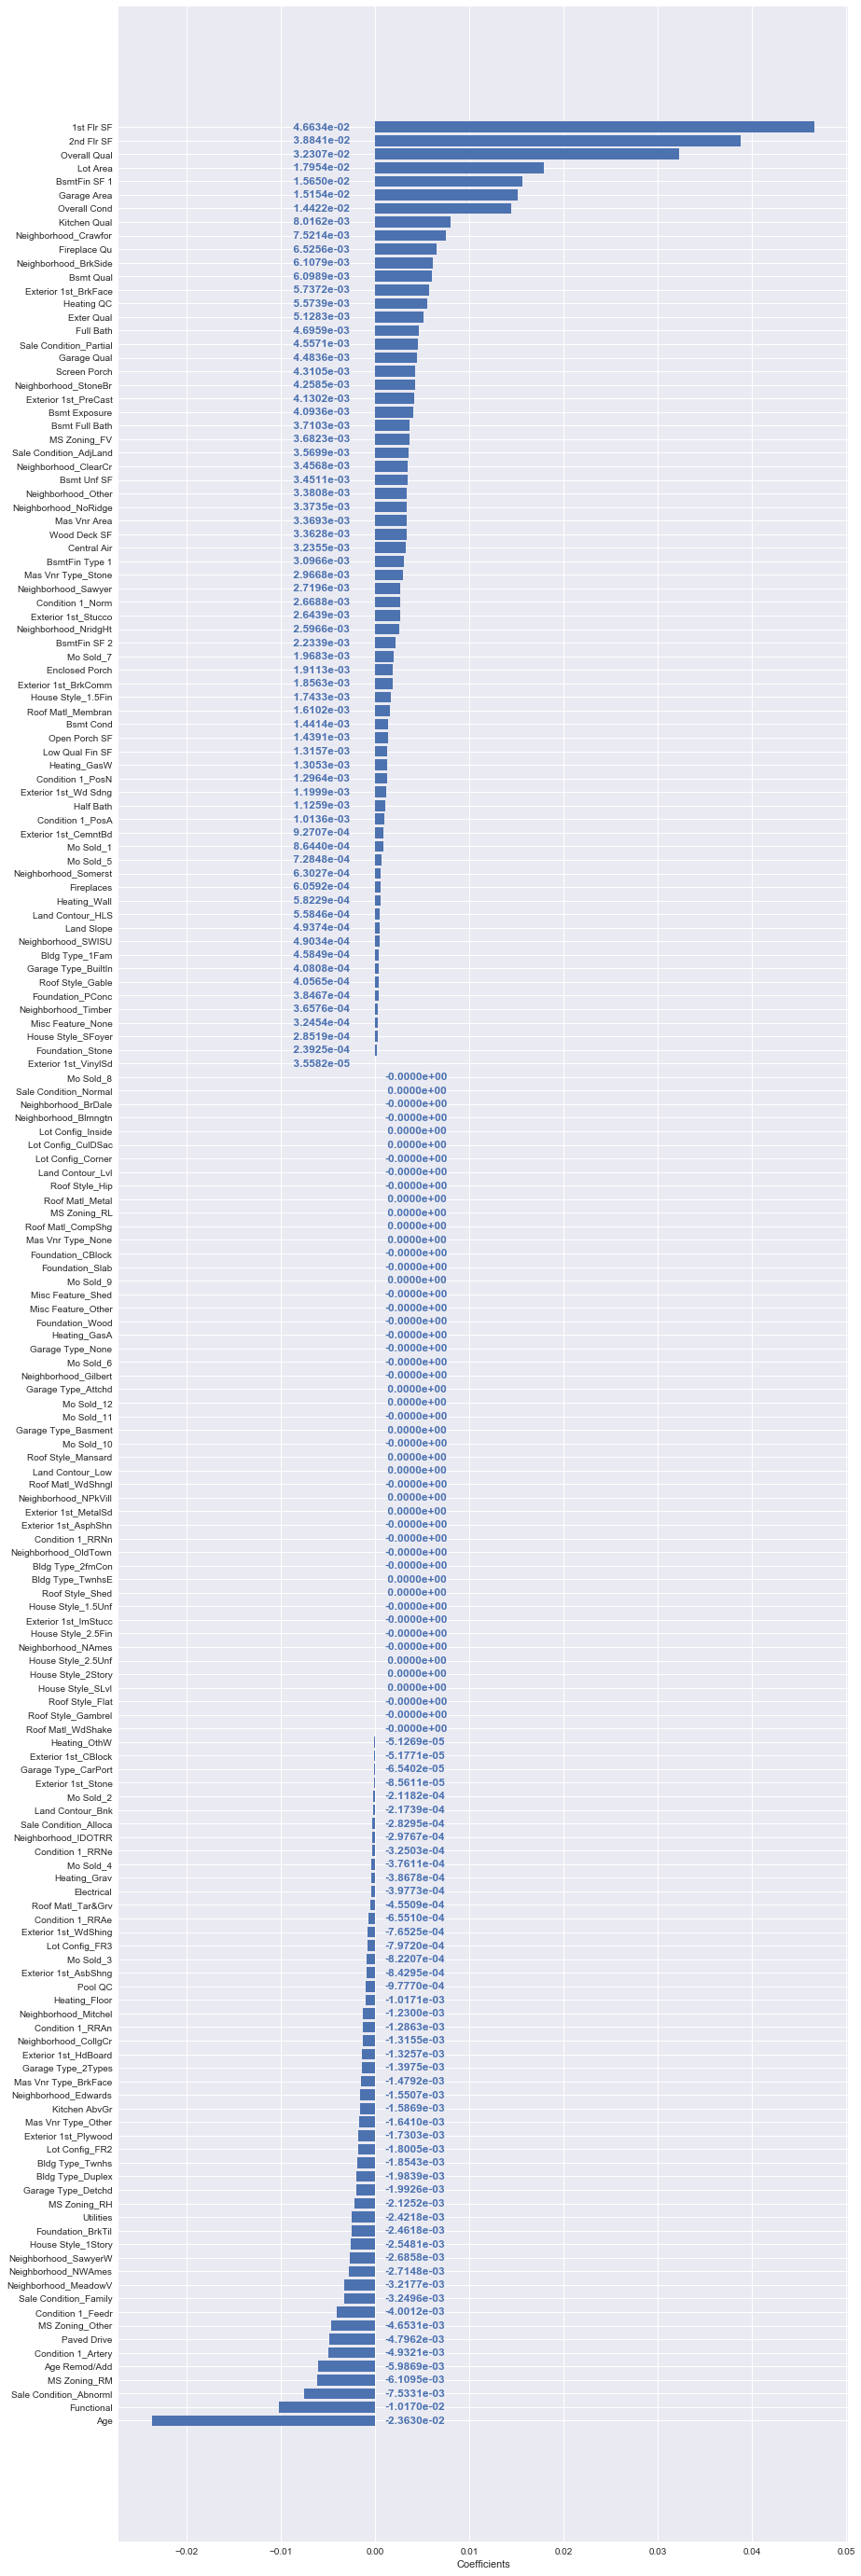

In [104]:
ma_all_lasso.plot_coefs(figsize=(14,50), offset=0.009)

Applying again Lasso Regularization doesn't improve anymore the MAE but reduce the number of dimensions. Note that the discarded variables are now only one hot encoded variables. Lasso Regularization is good to indicate when a nominal variable can be replaced by an indicator variable (because only one of its category is relevant for example).

# 9. Conclusion & Models Comparison

Here are the comparison of the RMSLE scores of our different models:

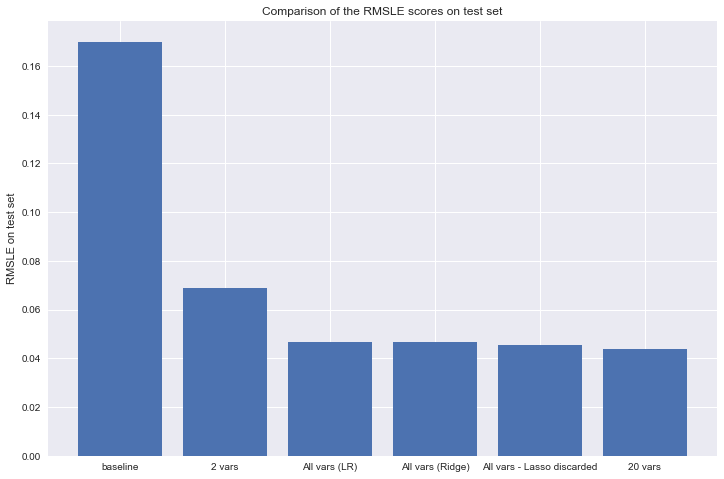

RMSLE Scores:  [0.170028, 0.068888, 0.046904, 0.046564, 0.045394, 0.043681]


In [105]:
# Plot RMSLE Scores comparison
rmsle_scores = [rmsle_baseline, rmsle_2_overallqual, rmsle_all, rmsle_all_ridge, rmsle_all_improved, rmsle_20]
labels = ['baseline', '2 vars', 'All vars (LR)', 'All vars (Ridge)', 'All vars - Lasso discarded', '20 vars']
plt.figure(figsize=(12, 8))
plt.bar(np.arange(len(rmsle_scores)), rmsle_scores, tick_label=labels)
plt.ylabel('RMSLE on test set')
plt.title('Comparison of the RMSLE scores on test set')
plt.show()

print('RMSLE Scores: ', rmsle_scores)

And the MAE scores :

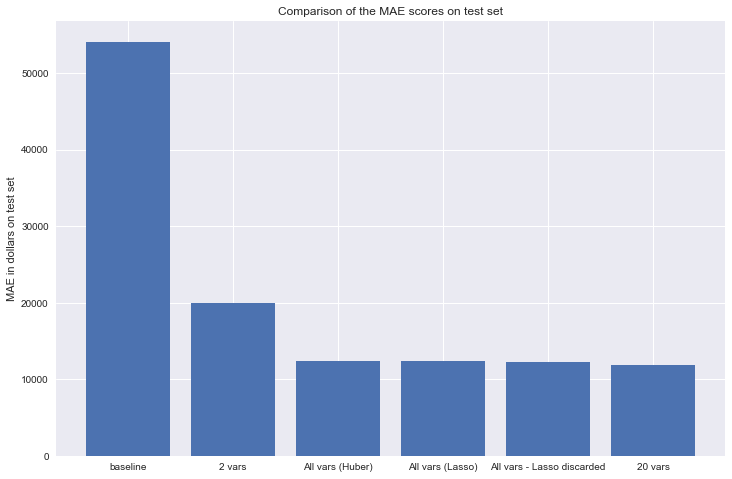

MAE Scores:  [54103.79, 19969.54, 12411.04, 12326.95, 12212.01, 11894.49]


In [106]:
# Plot MAE Scores comparison
mae_scores = [mae_baseline, mae_2_overallqual, mae_all, mae_all_lasso, mae_all_improved, mae_20]
labels = ['baseline', '2 vars', 'All vars (Huber)', 'All vars (Lasso)', 'All vars - Lasso discarded', '20 vars']

plt.figure(figsize=(12, 8))
plt.bar(np.arange(len(mae_scores)), mae_scores, tick_label=labels)
plt.ylabel('MAE in dollars on test set')
plt.title('Comparison of the MAE scores on test set')
plt.show()

print('MAE Scores: ', mae_scores)

We have built three models, one with 2 variables, one with 20 variables and one with all the variables. The best results are obtained with the 20 variables model by a small margin but with a lot of work behind to obtains a MAE score bellow 12'000$. To achieve this result with the 20 variable models, lots of different engineered features and selection have been done and only the best one is presented in this notebook. Is it worth it ? It will depend of the business requirements...

# 10. Prediction of the 500  house sale prices

### Loading the data

In [107]:
# Load the data
data_test = pd.read_csv('data/house-prices-test.csv')

data_test.info(verbose=False)
data_test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 81 entries, Order to Sale Condition
dtypes: float64(11), int64(27), object(43)
memory usage: 316.5+ KB


Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0   2217  909279080           50        RL           NaN     11275   Pave   
1    837  907126050           20        RL          65.0      9757   Pave   
2   2397  528144030           60        RL          86.0     11065   Pave   
3   1963  535452060           20        RL          70.0      7000   Pave   
4    306  911202100           50   C (all)          66.0      8712   Pave   

  Alley Lot Shape Land Contour       ...       Screen Porch Pool Area Pool QC  \
0   NaN       IR1          HLS       ...                  0         0     NaN   
1   NaN       Reg          Low       ...                 92         0     NaN   
2   NaN       IR1          Lvl       ...                  0         0     NaN   
3   NaN       Reg          Lvl       ...                  0         0     NaN   
4  Pave       Reg          HLS       ...                  0         0     NaN   

  Fence Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  Sale Condition  
0   NaN          NaN        0       3    2007        WD           Normal  
1   NaN          NaN        0      10    2009        WD           Normal  
2   NaN          NaN        0      10    2006        New         Partial  
3  MnWw          NaN        0       4    2007        WD           Family  
4   NaN          NaN        0       1    2010        WD          Abnorml  

[5 rows x 81 columns]

### Handling missing values

We apply the same rules to handle the missing values for our previous model. Because our best model don't use the `Lot Frontage` variable, I don't replicate here the job done for it.

In [108]:
# No basement and garage, missing values replaced by 0
vars = [
    'Total Bsmt SF', 
    'BsmtFin SF 1', 
    'BsmtFin SF 2', 
    'Bsmt Unf SF', 
    'Bsmt Half Bath', 
    'Bsmt Full Bath',
    'Garage Area', 
    'Garage Cars',
    'Mas Vnr Area'
]
for var in vars:
    data_test[var].fillna(0, inplace=True)
    
# No Garage, missing garage year built replaced by the house year built
data_test.loc[data_test['Garage Yr Blt'].isnull(), 'Garage Yr Blt'] = data_test.loc[data_test['Garage Yr Blt'].isnull(), 'Year Built']

# Replace missing values by None code
vars = [
    'Misc Feature',
    'Alley',
    'Garage Type',
    'Mas Vnr Type',
    'Pool QC',
    'Fence',
    'Fireplace Qu',
    'Garage Cond',
    'Garage Qual',
    'Garage Finish',
    'Bsmt Exposure',
    'BsmtFin Type 2',
    'BsmtFin Type 1',
    'Bsmt Cond',
    'Bsmt Qual',    
]
for var in vars:
    data_test[var].fillna('None', inplace=True)

# Replace electrical value replaced by its mode (SBrkr by far)
data_test['Electrical'].fillna(data_test['Electrical'].mode().values[0], inplace=True)  

### Feature Engineering

Our best model use the following engineered features:

In [109]:
# Age variable
data_test['Age'] = data_test['Yr Sold'] - data_test['Year Built']

# Age Remod/Add variable
data_test['Age Remod/Add'] = data_test['Yr Sold'] - data_test['Year Remod/Add']

# Total Porch SF variable
data_test['Total Porch SF'] = data_test['Screen Porch'] + data_test['Open Porch SF'] + data_test['3Ssn Porch'] + data_test['Enclosed Porch'] + data_test['Wood Deck SF']

# Total Bath variable
data_test['Total Bath'] = data_test['Full Bath'] + data_test['Bsmt Full Bath'] + 0.5 * (data_test['Half Bath'] + data_test['Bsmt Half Bath'])

### Encoding/Mapping

Here is the encoding/mapping used by our 20 variables model:

In [110]:
# Mappings used for the intermediate model
mappings = {}

mappings['Overall Qual'] = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
mappings['Overall Cond'] = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
mappings['Exter Qual']   = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
mappings['Fireplace Qu'] = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

mappings['Neighborhood'] = {
    'Landmrk': 'Other', 'GrnHill': 'Other', 'Blueste': 'Other', 'Greens': 'Other', 'Veenker': 'Other',
    'Blmngtn': 'Blmngtn', 'NPkVill': 'NPkVill', 'BrDale': 'BrDale', 'MeadowV': 'MeadowV',
    'BrkSide': 'BrkSide', 'ClearCr': 'ClearCr', 'CollgCr': 'CollgCr',
    'Crawfor': 'Crawfor', 'Edwards': 'Edwards', 'Gilbert': 'Gilbert',
    'IDOTRR': 'IDOTRR', 'Mitchel': 'Mitchel', 'NAmes': 'NAmes', 'NoRidge': 'NoRidge', 
    'NridgHt': 'NridgHt', 'NWAmes': 'NWAmes', 'OldTown': 'OldTown',
    'SWISU': 'SWISU', 'Sawyer': 'Sawyer', 'SawyerW': 'SawyerW',
    'Somerst': 'Somerst', 'StoneBr': 'StoneBr', 'Timber': 'Timber'
}

mappings['Condition 1'] = {'Norm': 'Norm', 'Feedr': 'Feedr', 'Artery': 'Artery', 
                           'RRAn': 'RR', 'RRAe': 'RR', 'RRNn': 'RR', 'RRNe': 'RR',
                           'PosN': 'Pos', 'PosA': 'Pos',}

mappings['Sale Condition'] = {'Partial': 'Partial', 'Abnorml': 'Abnorml', 'Family': 'Family',
                              'Normal': 'Normal', 'Alloca': 'Other', 'AdjLand': 'Other'}

mappings['Exterior 1st'] = {
    'ImStucc': 'Other', 'PreCast': 'Other', 'CBlock': 'Other', 'Stone': 'Other', 
    'AsphShn': 'Other', 'BrkComm': 'Other', 'Other': 'Other',
    'VinylSd': 'Other', 'Stucco': 'Other', 'Wd Sdng': 'Other', 'WdShing': 'Other', 'MetalSd': 'Other', 'CemntBd': 'Other',
    'Plywood': 'Plywood', 'BrkFace': 'BrkFace', 'HdBoard': 'HdBoard', 'AsbShng': 'AsbShng'}

mappings['Functional'] = {'Typ': 0, 'Min1': 1, 'Min2': 2, 'Mod': 3, 'Maj1': 4, 'Maj2': 5, 'Sev': 6, 'Sal': 7}

### Data Preparation 

In [111]:
# variables used to build the model
vars = [
    # Area variables
    Variable('Gr Liv Area', VariableType.CONTINUOUS, fn=np.sqrt),
    Variable('BsmtFin SF 1', VariableType.CONTINUOUS, ),
    Variable('BsmtFin SF 2', VariableType.CONTINUOUS, ),
    Variable('Bsmt Unf SF', VariableType.CONTINUOUS),
    Variable('Lot Area', VariableType.CONTINUOUS, fn=np.log10),
    Variable('Garage Area', VariableType.CONTINUOUS),    
    Variable('Total Porch SF', VariableType.CONTINUOUS),  
    
    # Period/Time variables
    Variable('Age', VariableType.DISCRETE),
    Variable('Age Remod/Add', VariableType.DISCRETE),
    
    # Quality variables
    Variable('Overall Qual', VariableType.ORDINAL, mapping=mappings['Overall Qual']),
    Variable('Overall Cond', VariableType.ORDINAL, mapping=mappings['Overall Cond']),
    Variable('Exter Qual', VariableType.ORDINAL, mapping=mappings['Exter Qual']),
    Variable('Fireplace Qu', VariableType.ORDINAL, mapping=mappings['Fireplace Qu']),
    
    # Location & House type variables
    Variable('Neighborhood', VariableType.NOMINAL, mapping=mappings['Neighborhood']),
    Variable('Condition 1', VariableType.NOMINAL, mapping=mappings['Condition 1']),
    Variable('Bldg Type', VariableType.NOMINAL), 
    
    # Sale process variable
    Variable('Sale Condition', VariableType.NOMINAL, mapping=mappings['Sale Condition']),
    
    # Other variables
    Variable('Exterior 1st', VariableType.NOMINAL, mapping=mappings['Exterior 1st']),
    Variable('Functional', VariableType.ORDINAL, mapping=mappings['Functional']),
    Variable('Total Bath', VariableType.DISCRETE),
]

# prepare the data
mdfb = ModelDataFrameBuilder()
mdfb.prepare(data_test, vars)

# Normalize the data
mdfb.normalize()

# Get the prepared data
df_test = mdfb.data()

### Predictions

We want to predict the sale prices, so we use the model that optimize the MAE; in our case the `HuberRegressor` model with `epsilon = 1.31`:

In [112]:
# ------------------------------------------
# WARNING: 
# Because it's possible to play with the USE_LINEAR_BOOLEAN flag, 
# it is important to be sure that the last computation on the ma_20 ModelAgent object
# has be done with the HuberRegressor model
# ------------------------------------------

# Predict the sale prices (ma_20 is the ModelAgent object that embed the model trained with the 20 variables)
predictions = ma_20.predict(df_test, inverse_fn=log10_inverse_fn)

# Build a DataFrame with the PID & SalePrice
predictions_df = pd.DataFrame.from_items([
    ('PID', data_test['PID']),
    ('SalePrice', predictions)
])

# Sale price as integer value
predictions_df['SalePrice'] = predictions_df['SalePrice'].astype(int)
predictions_df.head(10)

PID  SalePrice
0  909279080     188154
1  907126050     151040
2  528144030     264400
3  535452060     133567
4  911202100      90905
5  531382090     167307
6  902477130      56631
7  527402150     138233
8  908102320     144339
9  908276140      97158

### Distribution Verification

In [113]:
# Distribution of the predicted prices
predictions_df.SalePrice.describe()

count       500.000000
mean     178206.192000
std       77100.082168
min       54136.000000
25%      126914.500000
50%      157572.000000
75%      208176.750000
max      798220.000000
Name: SalePrice, dtype: float64

In [114]:
# Distribution of the prices in house-prices.csv
data.SalePrice.describe()

count      2375.000000
mean     177932.169684
std       74012.661483
min       45000.000000
25%      129000.000000
50%      160000.000000
75%      211000.000000
max      591587.000000
Name: SalePrice, dtype: float64

It looks OK, note that the test data contains a very expensive house :)

### Export to CSV

In [115]:
## WARNING: 
# Because it's possible to play with the USE_LINEAR_BOOLEAN flag, 
# it is important to be sure that the last computation on the ma_20 ModelAgent object
# has be done with the HuberRegressor model
OVERRIDE = False

# Save data
if OVERRIDE:
    predictions_df.to_csv('data/house-prices-pred.csv', index=False, float_format='%.0f')